##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 1s

    16384/252872794 [..............................] - ETA: 21:47

    49152/252872794 [..............................] - ETA: 14:32

   106496/252872794 [..............................] - ETA: 10:04

   204800/252872794 [..............................] - ETA: 6:59 

   425984/252872794 [..............................] - ETA: 4:11

   860160/252872794 [..............................] - ETA: 2:29

  1728512/252872794 [..............................] - ETA: 1:26

  3465216/252872794 [..............................] - ETA: 48s 

  6602752/252872794 [..............................] - ETA: 28s

  9682944/252872794 [>.............................] - ETA: 21s

 12812288/252872794 [>.............................] - ETA: 17s

 15941632/252872794 [>.............................] - ETA: 15s

 19062784/252872794 [=>............................] - ETA: 13s

 22192128/252872794 [=>............................] - ETA: 12s

 25329664/252872794 [==>...........................] - ETA: 11s

 28459008/252872794 [==>...........................] - ETA: 10s

 31580160/252872794 [==>...........................] - ETA: 10s

 34725888/252872794 [===>..........................] - ETA: 9s 

 37855232/252872794 [===>..........................] - ETA: 9s

 40984576/252872794 [===>..........................] - ETA: 8s

 44089344/252872794 [====>.........................] - ETA: 8s

 47226880/252872794 [====>.........................] - ETA: 8s

 50356224/252872794 [====>.........................] - ETA: 7s

 53493760/252872794 [=====>........................] - ETA: 7s

 56639488/252872794 [=====>........................] - ETA: 7s

 59777024/252872794 [======>.......................] - ETA: 7s

 62914560/252872794 [======>.......................] - ETA: 6s

 66052096/252872794 [======>.......................] - ETA: 6s

 69156864/252872794 [=======>......................] - ETA: 6s

 72286208/252872794 [=======>......................] - ETA: 6s

 75415552/252872794 [=======>......................] - ETA: 6s

 78553088/252872794 [========>.....................] - ETA: 6s

 81674240/252872794 [========>.....................] - ETA: 5s

 84811776/252872794 [=========>....................] - ETA: 5s

 87941120/252872794 [=========>....................] - ETA: 5s

 91021312/252872794 [=========>....................] - ETA: 5s

 94158848/252872794 [==========>...................] - ETA: 5s

 97304576/252872794 [==========>...................] - ETA: 5s

100442112/252872794 [==========>...................] - ETA: 5s

103563264/252872794 [===========>..................] - ETA: 4s

106692608/252872794 [===========>..................] - ETA: 4s

109813760/252872794 [============>.................] - ETA: 4s

112959488/252872794 [============>.................] - ETA: 4s

116097024/252872794 [============>.................] - ETA: 4s

119234560/252872794 [=============>................] - ETA: 4s

122372096/252872794 [=============>................] - ETA: 4s

125509632/252872794 [=============>................] - ETA: 4s

128647168/252872794 [==============>...............] - ETA: 3s

131784704/252872794 [==============>...............] - ETA: 3s

134922240/252872794 [===============>..............] - ETA: 3s

138059776/252872794 [===============>..............] - ETA: 3s

141197312/252872794 [===============>..............] - ETA: 3s

144334848/252872794 [================>.............] - ETA: 3s

147472384/252872794 [================>.............] - ETA: 3s

150593536/252872794 [================>.............] - ETA: 3s

153731072/252872794 [=================>............] - ETA: 3s

156868608/252872794 [=================>............] - ETA: 2s

160006144/252872794 [=================>............] - ETA: 2s

163143680/252872794 [==================>...........] - ETA: 2s

166281216/252872794 [==================>...........] - ETA: 2s

169426944/252872794 [===================>..........] - ETA: 2s

172531712/252872794 [===================>..........] - ETA: 2s

175652864/252872794 [===================>..........] - ETA: 2s

178774016/252872794 [====================>.........] - ETA: 2s

181903360/252872794 [====================>.........] - ETA: 2s

185024512/252872794 [====================>.........] - ETA: 2s

188153856/252872794 [=====================>........] - ETA: 1s

191258624/252872794 [=====================>........] - ETA: 1s

194387968/252872794 [======================>.......] - ETA: 1s

197492736/252872794 [======================>.......] - ETA: 1s

200638464/252872794 [======================>.......] - ETA: 1s

203759616/252872794 [=======================>......] - ETA: 1s

206888960/252872794 [=======================>......] - ETA: 1s

209993728/252872794 [=======================>......] - ETA: 1s

213123072/252872794 [========================>.....] - ETA: 1s

216227840/252872794 [========================>.....] - ETA: 1s

219373568/252872794 [=========================>....] - ETA: 0s

222511104/252872794 [=========================>....] - ETA: 0s

225640448/252872794 [=========================>....] - ETA: 0s

228745216/252872794 [==========================>...] - ETA: 0s

231858176/252872794 [==========================>...] - ETA: 0s

234987520/252872794 [==========================>...] - ETA: 0s

238125056/252872794 [===========================>..] - ETA: 0s

241270784/252872794 [===========================>..] - ETA: 0s

244383744/252872794 [===========================>..] - ETA: 0s

247521280/252872794 [============================>.] - ETA: 0s

250658816/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 7s 0us/step


       8192/13510573713 [..............................] - ETA: 1:52

      16384/13510573713 [..............................] - ETA: 19:23:38

      49152/13510573713 [..............................] - ETA: 12:57:35

     106496/13510573713 [..............................] - ETA: 8:58:51 

     204800/13510573713 [..............................] - ETA: 6:13:54

     425984/13510573713 [..............................] - ETA: 3:44:36

     860160/13510573713 [..............................] - ETA: 2:13:31

    1728512/13510573713 [..............................] - ETA: 1:17:30

    3465216/13510573713 [..............................] - ETA: 44:11  

    6594560/13510573713 [..............................] - ETA: 26:07

    9732096/13510573713 [..............................] - ETA: 19:39

   12861440/13510573713 [..............................] - ETA: 16:22

   16007168/13510573713 [..............................] - ETA: 14:20

   19111936/13510573713 [..............................] - ETA: 13:00

   22233088/13510573713 [..............................] - ETA: 11:55

   25370624/13510573713 [..............................] - ETA: 11:12

   28393472/13510573713 [..............................] - ETA: 10:24

   28868608/13510573713 [..............................] - ETA: 10:37

   31571968/13510573713 [..............................] - ETA: 10:12

   34627584/13510573713 [..............................] - ETA: 9:38 

   35160064/13510573713 [..............................] - ETA: 9:48

   37855232/13510573713 [..............................] - ETA: 9:31

   40869888/13510573713 [..............................] - ETA: 9:05

   41435136/13510573713 [..............................] - ETA: 9:14

   44130304/13510573713 [..............................] - ETA: 9:01

   47161344/13510573713 [..............................] - ETA: 8:41

   47718400/13510573713 [..............................] - ETA: 8:49

   50405376/13510573713 [..............................] - ETA: 8:39

   53362688/13510573713 [..............................] - ETA: 8:23

   53968896/13510573713 [..............................] - ETA: 8:30

   56680448/13510573713 [..............................] - ETA: 8:22

   59645952/13510573713 [..............................] - ETA: 8:08

   60252160/13510573713 [..............................] - ETA: 8:14

   62881792/13510573713 [..............................] - ETA: 8:09

   65855488/13510573713 [..............................] - ETA: 7:57

   66134016/13510573713 [..............................] - ETA: 8:05

   69165056/13510573713 [..............................] - ETA: 7:58

   72130560/13510573713 [..............................] - ETA: 7:47

   72335360/13510573713 [..............................] - ETA: 7:55

   75431936/13510573713 [..............................] - ETA: 7:48

   78258176/13510573713 [..............................] - ETA: 7:40

   78585856/13510573713 [..............................] - ETA: 7:46

   81715200/13510573713 [..............................] - ETA: 7:40

   84525056/13510573713 [..............................] - ETA: 7:33

   84885504/13510573713 [..............................] - ETA: 7:39

   87998464/13510573713 [..............................] - ETA: 7:33

   90759168/13510573713 [..............................] - ETA: 7:26

   91160576/13510573713 [..............................] - ETA: 7:32

   94281728/13510573713 [..............................] - ETA: 7:27

   96747520/13510573713 [..............................] - ETA: 7:22

   96952320/13510573713 [..............................] - ETA: 7:34

   99246080/13510573713 [..............................] - ETA: 7:30

  100098048/13510573713 [..............................] - ETA: 7:37

  102383616/13510573713 [..............................] - ETA: 7:38

  105496576/13510573713 [..............................] - ETA: 7:35

  108625920/13510573713 [..............................] - ETA: 7:32

  111755264/13510573713 [..............................] - ETA: 7:30

  114892800/13510573713 [..............................] - ETA: 7:28

  118005760/13510573713 [..............................] - ETA: 7:25

  121151488/13510573713 [..............................] - ETA: 7:23

  124239872/13510573713 [..............................] - ETA: 7:21

  127385600/13510573713 [..............................] - ETA: 7:19

  130523136/13510573713 [..............................] - ETA: 7:17

  133660672/13510573713 [..............................] - ETA: 7:14

  136798208/13510573713 [..............................] - ETA: 7:12

  139272192/13510573713 [..............................] - ETA: 7:09

  139960320/13510573713 [..............................] - ETA: 7:12

  143048704/13510573713 [..............................] - ETA: 7:09

  145424384/13510573713 [..............................] - ETA: 7:06

  146243584/13510573713 [..............................] - ETA: 7:09

  149323776/13510573713 [..............................] - ETA: 7:06

  151199744/13510573713 [..............................] - ETA: 7:05

  152526848/13510573713 [..............................] - ETA: 7:06

  155566080/13510573713 [..............................] - ETA: 7:03

  157491200/13510573713 [..............................] - ETA: 7:02

  158801920/13510573713 [..............................] - ETA: 7:03

  161849344/13510573713 [..............................] - ETA: 7:01

  163782656/13510573713 [..............................] - ETA: 7:00

  165093376/13510573713 [..............................] - ETA: 7:00

  168124416/13510573713 [..............................] - ETA: 6:58

  170041344/13510573713 [..............................] - ETA: 6:57

  171384832/13510573713 [..............................] - ETA: 6:58

  174399488/13510573713 [..............................] - ETA: 6:56

  176316416/13510573713 [..............................] - ETA: 6:55

  177627136/13510573713 [..............................] - ETA: 6:56

  180674560/13510573713 [..............................] - ETA: 6:54

  182411264/13510573713 [..............................] - ETA: 6:54

  183836672/13510573713 [..............................] - ETA: 6:54

  186949632/13510573713 [..............................] - ETA: 6:52

  188702720/13510573713 [..............................] - ETA: 6:52

  190111744/13510573713 [..............................] - ETA: 6:52

  193216512/13510573713 [..............................] - ETA: 6:50

  194822144/13510573713 [..............................] - ETA: 6:50

  196370432/13510573713 [..............................] - ETA: 6:50

  199475200/13510573713 [..............................] - ETA: 6:48

  201113600/13510573713 [..............................] - ETA: 6:48

  202629120/13510573713 [..............................] - ETA: 6:48

  205733888/13510573713 [..............................] - ETA: 6:47

  207396864/13510573713 [..............................] - ETA: 6:47

  208920576/13510573713 [..............................] - ETA: 6:47

  211984384/13510573713 [..............................] - ETA: 6:45

  213671936/13510573713 [..............................] - ETA: 6:45

  215138304/13510573713 [..............................] - ETA: 6:45

  218243072/13510573713 [..............................] - ETA: 6:44

  219955200/13510573713 [..............................] - ETA: 6:44

  221429760/13510573713 [..............................] - ETA: 6:44

  224518144/13510573713 [..............................] - ETA: 6:42

  226238464/13510573713 [..............................] - ETA: 6:42

  227688448/13510573713 [..............................] - ETA: 6:43

  230793216/13510573713 [..............................] - ETA: 6:41

  232521728/13510573713 [..............................] - ETA: 6:41

  233979904/13510573713 [..............................] - ETA: 6:42

  237051904/13510573713 [..............................] - ETA: 6:40

  238796800/13510573713 [..............................] - ETA: 6:40

  240254976/13510573713 [..............................] - ETA: 6:40

  243318784/13510573713 [..............................] - ETA: 6:38

  245071872/13510573713 [..............................] - ETA: 6:38

  246530048/13510573713 [..............................] - ETA: 6:39

  249593856/13510573713 [..............................] - ETA: 6:37

  251027456/13510573713 [..............................] - ETA: 6:38

  252813312/13510573713 [..............................] - ETA: 6:38

  255885312/13510573713 [..............................] - ETA: 6:36

  257318912/13510573713 [..............................] - ETA: 6:37

  259104768/13510573713 [..............................] - ETA: 6:37

  262160384/13510573713 [..............................] - ETA: 6:35

  263610368/13510573713 [..............................] - ETA: 6:36

  265379840/13510573713 [..............................] - ETA: 6:36

  268435456/13510573713 [..............................] - ETA: 6:34

  269893632/13510573713 [..............................] - ETA: 6:35

  271663104/13510573713 [..............................] - ETA: 6:35

  274710528/13510573713 [..............................] - ETA: 6:33

  276160512/13510573713 [..............................] - ETA: 6:34

  277913600/13510573713 [..............................] - ETA: 6:34

  280952832/13510573713 [..............................] - ETA: 6:32

  282451968/13510573713 [..............................] - ETA: 6:33

  284188672/13510573713 [..............................] - ETA: 6:33

  287227904/13510573713 [..............................] - ETA: 6:31

  288718848/13510573713 [..............................] - ETA: 6:32

  290381824/13510573713 [..............................] - ETA: 6:32

  293511168/13510573713 [..............................] - ETA: 6:31

  296181760/13510573713 [..............................] - ETA: 6:30

  297025536/13510573713 [..............................] - ETA: 6:31

  299786240/13510573713 [..............................] - ETA: 6:30

  302260224/13510573713 [..............................] - ETA: 6:29

  303333376/13510573713 [..............................] - ETA: 6:30

  306061312/13510573713 [..............................] - ETA: 6:29

  308543488/13510573713 [..............................] - ETA: 6:28

  309592064/13510573713 [..............................] - ETA: 6:29

  312344576/13510573713 [..............................] - ETA: 6:28

  314826752/13510573713 [..............................] - ETA: 6:27

  315850752/13510573713 [..............................] - ETA: 6:28

  318619648/13510573713 [..............................] - ETA: 6:28

  321110016/13510573713 [..............................] - ETA: 6:27

  322125824/13510573713 [..............................] - ETA: 6:27

  324886528/13510573713 [..............................] - ETA: 6:27

  327172096/13510573713 [..............................] - ETA: 6:26

  328392704/13510573713 [..............................] - ETA: 6:27

  331169792/13510573713 [..............................] - ETA: 6:27

  334004224/13510573713 [..............................] - ETA: 6:25

  335249408/13510573713 [..............................] - ETA: 6:26

  337444864/13510573713 [..............................] - ETA: 6:25

  339369984/13510573713 [..............................] - ETA: 6:25

  340705280/13510573713 [..............................] - ETA: 6:26

  343220224/13510573713 [..............................] - ETA: 6:25

  344211456/13510573713 [..............................] - ETA: 6:25

  346595328/13510573713 [..............................] - ETA: 6:25

  348225536/13510573713 [..............................] - ETA: 6:25

  350142464/13510573713 [..............................] - ETA: 6:25

  352280576/13510573713 [..............................] - ETA: 6:24

  353730560/13510573713 [..............................] - ETA: 6:24

  356007936/13510573713 [..............................] - ETA: 6:24

  357556224/13510573713 [..............................] - ETA: 6:24

  359530496/13510573713 [..............................] - ETA: 6:24

  361168896/13510573713 [..............................] - ETA: 6:24

  363053056/13510573713 [..............................] - ETA: 6:23

  365420544/13510573713 [..............................] - ETA: 6:23

  366714880/13510573713 [..............................] - ETA: 6:23

  368959488/13510573713 [..............................] - ETA: 6:23

  370581504/13510573713 [..............................] - ETA: 6:23

  372490240/13510573713 [..............................] - ETA: 6:22

  374849536/13510573713 [..............................] - ETA: 6:22

  376127488/13510573713 [..............................] - ETA: 6:22

  378380288/13510573713 [..............................] - ETA: 6:22

  380010496/13510573713 [..............................] - ETA: 6:22

  381902848/13510573713 [..............................] - ETA: 6:21

  384262144/13510573713 [..............................] - ETA: 6:21

  385523712/13510573713 [..............................] - ETA: 6:21

  387792896/13510573713 [..............................] - ETA: 6:21

  389382144/13510573713 [..............................] - ETA: 6:21

  391290880/13510573713 [..............................] - ETA: 6:20

  393609216/13510573713 [..............................] - ETA: 6:20

  394772480/13510573713 [..............................] - ETA: 6:20

  397131776/13510573713 [..............................] - ETA: 6:20

  398655488/13510573713 [..............................] - ETA: 6:20

  400670720/13510573713 [..............................] - ETA: 6:20

  402620416/13510573713 [..............................] - ETA: 6:19

  404094976/13510573713 [..............................] - ETA: 6:19

  406478848/13510573713 [..............................] - ETA: 6:19

  407699456/13510573713 [..............................] - ETA: 6:19

  410009600/13510573713 [..............................] - ETA: 6:19

  411738112/13510573713 [..............................] - ETA: 6:19

  413401088/13510573713 [..............................] - ETA: 6:19

  415858688/13510573713 [..............................] - ETA: 6:18

  417005568/13510573713 [..............................] - ETA: 6:18

  419266560/13510573713 [..............................] - ETA: 6:18

  420937728/13510573713 [..............................] - ETA: 6:18

  422764544/13510573713 [..............................] - ETA: 6:18

  425164800/13510573713 [..............................] - ETA: 6:17

  426418176/13510573713 [..............................] - ETA: 6:18

  428662784/13510573713 [..............................] - ETA: 6:17

  430268416/13510573713 [..............................] - ETA: 6:17

  432185344/13510573713 [..............................] - ETA: 6:17

  434577408/13510573713 [..............................] - ETA: 6:16

  435814400/13510573713 [..............................] - ETA: 6:17

  438067200/13510573713 [..............................] - ETA: 6:16

  439681024/13510573713 [..............................] - ETA: 6:16

  441606144/13510573713 [..............................] - ETA: 6:16

  443981824/13510573713 [..............................] - ETA: 6:16

  445251584/13510573713 [..............................] - ETA: 6:16

  447504384/13510573713 [..............................] - ETA: 6:16

  449101824/13510573713 [..............................] - ETA: 6:16

  451026944/13510573713 [>.............................] - ETA: 6:15

  453402624/13510573713 [>.............................] - ETA: 6:15

  454672384/13510573713 [>.............................] - ETA: 6:15

  456925184/13510573713 [>.............................] - ETA: 6:15

  458514432/13510573713 [>.............................] - ETA: 6:15

  460406784/13510573713 [>.............................] - ETA: 6:15

  462684160/13510573713 [>.............................] - ETA: 6:14

  464068608/13510573713 [>.............................] - ETA: 6:15

  466264064/13510573713 [>.............................] - ETA: 6:14

  467386368/13510573713 [>.............................] - ETA: 6:15

  469811200/13510573713 [>.............................] - ETA: 6:14

  471416832/13510573713 [>.............................] - ETA: 6:14

  473366528/13510573713 [>.............................] - ETA: 6:14

  475602944/13510573713 [>.............................] - ETA: 6:13

  476815360/13510573713 [>.............................] - ETA: 6:14

  479232000/13510573713 [>.............................] - ETA: 6:13

  480837632/13510573713 [>.............................] - ETA: 6:13

  482779136/13510573713 [>.............................] - ETA: 6:13

  485015552/13510573713 [>.............................] - ETA: 6:13

  486227968/13510573713 [>.............................] - ETA: 6:13

  488652800/13510573713 [>.............................] - ETA: 6:13

  490266624/13510573713 [>.............................] - ETA: 6:13

  492216320/13510573713 [>.............................] - ETA: 6:13

  494444544/13510573713 [>.............................] - ETA: 6:12

  495968256/13510573713 [>.............................] - ETA: 6:12

  498081792/13510573713 [>.............................] - ETA: 6:12

  499703808/13510573713 [>.............................] - ETA: 6:12

  501858304/13510573713 [>.............................] - ETA: 6:12

  504258560/13510573713 [>.............................] - ETA: 6:12

  505708544/13510573713 [>.............................] - ETA: 6:12

  507805696/13510573713 [>.............................] - ETA: 6:11

  509140992/13510573713 [>.............................] - ETA: 6:12

  511270912/13510573713 [>.............................] - ETA: 6:11

  513671168/13510573713 [>.............................] - ETA: 6:11

  515055616/13510573713 [>.............................] - ETA: 6:11

  517242880/13510573713 [>.............................] - ETA: 6:11

  518569984/13510573713 [>.............................] - ETA: 6:11

  520699904/13510573713 [>.............................] - ETA: 6:11

  523075584/13510573713 [>.............................] - ETA: 6:10

  524460032/13510573713 [>.............................] - ETA: 6:10

  526573568/13510573713 [>.............................] - ETA: 6:10

  527990784/13510573713 [>.............................] - ETA: 6:11

  530128896/13510573713 [>.............................] - ETA: 6:10

  532520960/13510573713 [>.............................] - ETA: 6:10

  534265856/13510573713 [>.............................] - ETA: 6:10

  536420352/13510573713 [>.............................] - ETA: 6:10

  538804224/13510573713 [>.............................] - ETA: 6:09

  540549120/13510573713 [>.............................] - ETA: 6:10

  542703616/13510573713 [>.............................] - ETA: 6:09

  545079296/13510573713 [>.............................] - ETA: 6:09

  546832384/13510573713 [>.............................] - ETA: 6:09

  548970496/13510573713 [>.............................] - ETA: 6:09

  551362560/13510573713 [>.............................] - ETA: 6:09

  553115648/13510573713 [>.............................] - ETA: 6:09

  555245568/13510573713 [>.............................] - ETA: 6:09

  557645824/13510573713 [>.............................] - ETA: 6:08

  559390720/13510573713 [>.............................] - ETA: 6:09

  561504256/13510573713 [>.............................] - ETA: 6:08

  563904512/13510573713 [>.............................] - ETA: 6:08

  565673984/13510573713 [>.............................] - ETA: 6:08

  567779328/13510573713 [>.............................] - ETA: 6:08

  570171392/13510573713 [>.............................] - ETA: 6:08

  571949056/13510573713 [>.............................] - ETA: 6:08

  574062592/13510573713 [>.............................] - ETA: 6:08

  576405504/13510573713 [>.............................] - ETA: 6:07

  578232320/13510573713 [>.............................] - ETA: 6:07

  580337664/13510573713 [>.............................] - ETA: 6:07

  582647808/13510573713 [>.............................] - ETA: 6:07

  584507392/13510573713 [>.............................] - ETA: 6:07

  586645504/13510573713 [>.............................] - ETA: 6:07

  588922880/13510573713 [>.............................] - ETA: 6:06

  590782464/13510573713 [>.............................] - ETA: 6:07

  592928768/13510573713 [>.............................] - ETA: 6:06

  595189760/13510573713 [>.............................] - ETA: 6:06

  597065728/13510573713 [>.............................] - ETA: 6:06

  599203840/13510573713 [>.............................] - ETA: 6:06

  601456640/13510573713 [>.............................] - ETA: 6:06

  603348992/13510573713 [>.............................] - ETA: 6:06

  605487104/13510573713 [>.............................] - ETA: 6:06

  607739904/13510573713 [>.............................] - ETA: 6:05

  609624064/13510573713 [>.............................] - ETA: 6:06

  611762176/13510573713 [>.............................] - ETA: 6:05

  613998592/13510573713 [>.............................] - ETA: 6:05

  615899136/13510573713 [>.............................] - ETA: 6:05

  618045440/13510573713 [>.............................] - ETA: 6:05

  620265472/13510573713 [>.............................] - ETA: 6:05

  622182400/13510573713 [>.............................] - ETA: 6:05

  624328704/13510573713 [>.............................] - ETA: 6:05

  626515968/13510573713 [>.............................] - ETA: 6:04

  628465664/13510573713 [>.............................] - ETA: 6:05

  630611968/13510573713 [>.............................] - ETA: 6:04

  632782848/13510573713 [>.............................] - ETA: 6:04

  634740736/13510573713 [>.............................] - ETA: 6:04

  636887040/13510573713 [>.............................] - ETA: 6:04

  639041536/13510573713 [>.............................] - ETA: 6:04

  641032192/13510573713 [>.............................] - ETA: 6:04

  643178496/13510573713 [>.............................] - ETA: 6:04

  645308416/13510573713 [>.............................] - ETA: 6:03

  647307264/13510573713 [>.............................] - ETA: 6:04

  649461760/13510573713 [>.............................] - ETA: 6:03

  651583488/13510573713 [>.............................] - ETA: 6:03

  653590528/13510573713 [>.............................] - ETA: 6:03

  655736832/13510573713 [>.............................] - ETA: 6:03

  657825792/13510573713 [>.............................] - ETA: 6:03

  659873792/13510573713 [>.............................] - ETA: 6:03

  662020096/13510573713 [>.............................] - ETA: 6:03

  664092672/13510573713 [>.............................] - ETA: 6:03

  666157056/13510573713 [>.............................] - ETA: 6:03

  668295168/13510573713 [>.............................] - ETA: 6:02

  670359552/13510573713 [>.............................] - ETA: 6:02

  672432128/13510573713 [>.............................] - ETA: 6:02

  674652160/13510573713 [>.............................] - ETA: 6:02

  676634624/13510573713 [>.............................] - ETA: 6:02

  678715392/13510573713 [>.............................] - ETA: 6:02

  680943616/13510573713 [>.............................] - ETA: 6:02

  682909696/13510573713 [>.............................] - ETA: 6:02

  684949504/13510573713 [>.............................] - ETA: 6:02

  687194112/13510573713 [>.............................] - ETA: 6:01

  689184768/13510573713 [>.............................] - ETA: 6:01

  691232768/13510573713 [>.............................] - ETA: 6:01

  693469184/13510573713 [>.............................] - ETA: 6:01

  695459840/13510573713 [>.............................] - ETA: 6:01

  697499648/13510573713 [>.............................] - ETA: 6:01

  699760640/13510573713 [>.............................] - ETA: 6:01

  701743104/13510573713 [>.............................] - ETA: 6:01

  703782912/13510573713 [>.............................] - ETA: 6:01

  706052096/13510573713 [>.............................] - ETA: 6:01

  708026368/13510573713 [>.............................] - ETA: 6:00

  710049792/13510573713 [>.............................] - ETA: 6:01

  712335360/13510573713 [>.............................] - ETA: 6:00

  714276864/13510573713 [>.............................] - ETA: 6:00

  716324864/13510573713 [>.............................] - ETA: 6:00

  718626816/13510573713 [>.............................] - ETA: 6:00

  720551936/13510573713 [>.............................] - ETA: 6:00

  722591744/13510573713 [>.............................] - ETA: 6:00

  724901888/13510573713 [>.............................] - ETA: 6:00

  726827008/13510573713 [>.............................] - ETA: 6:00

  728866816/13510573713 [>.............................] - ETA: 6:00

  731185152/13510573713 [>.............................] - ETA: 5:59

  733102080/13510573713 [>.............................] - ETA: 5:59

  735141888/13510573713 [>.............................] - ETA: 5:59

  737419264/13510573713 [>.............................] - ETA: 5:59

  739270656/13510573713 [>.............................] - ETA: 5:59

  741425152/13510573713 [>.............................] - ETA: 5:59

  743702528/13510573713 [>.............................] - ETA: 5:59

  745603072/13510573713 [>.............................] - ETA: 5:59

  747700224/13510573713 [>.............................] - ETA: 5:59

  749993984/13510573713 [>.............................] - ETA: 5:59

  751894528/13510573713 [>.............................] - ETA: 5:58

  753975296/13510573713 [>.............................] - ETA: 5:59

  756252672/13510573713 [>.............................] - ETA: 5:58

  758185984/13510573713 [>.............................] - ETA: 5:58

  760250368/13510573713 [>.............................] - ETA: 5:58

  762544128/13510573713 [>.............................] - ETA: 5:58

  764469248/13510573713 [>.............................] - ETA: 5:58

  766525440/13510573713 [>.............................] - ETA: 5:58

  768827392/13510573713 [>.............................] - ETA: 5:58

  770744320/13510573713 [>.............................] - ETA: 5:58

  772800512/13510573713 [>.............................] - ETA: 5:58

  775094272/13510573713 [>.............................] - ETA: 5:57

  777027584/13510573713 [>.............................] - ETA: 5:57

  779075584/13510573713 [>.............................] - ETA: 5:57

  781385728/13510573713 [>.............................] - ETA: 5:57

  783319040/13510573713 [>.............................] - ETA: 5:57

  785358848/13510573713 [>.............................] - ETA: 5:57

  787652608/13510573713 [>.............................] - ETA: 5:57

  789585920/13510573713 [>.............................] - ETA: 5:57

  791633920/13510573713 [>.............................] - ETA: 5:57

  793796608/13510573713 [>.............................] - ETA: 5:57

  795844608/13510573713 [>.............................] - ETA: 5:56

  797908992/13510573713 [>.............................] - ETA: 5:57

  800079872/13510573713 [>.............................] - ETA: 5:56

  802136064/13510573713 [>.............................] - ETA: 5:56

  804192256/13510573713 [>.............................] - ETA: 5:56

  806363136/13510573713 [>.............................] - ETA: 5:56

  808411136/13510573713 [>.............................] - ETA: 5:56

  810467328/13510573713 [>.............................] - ETA: 5:56

  812630016/13510573713 [>.............................] - ETA: 5:56

  814694400/13510573713 [>.............................] - ETA: 5:56

  816742400/13510573713 [>.............................] - ETA: 5:56

  818905088/13510573713 [>.............................] - ETA: 5:55

  820977664/13510573713 [>.............................] - ETA: 5:55

  823017472/13510573713 [>.............................] - ETA: 5:55

  825180160/13510573713 [>.............................] - ETA: 5:55

  827260928/13510573713 [>.............................] - ETA: 5:55

  829292544/13510573713 [>.............................] - ETA: 5:55

  831455232/13510573713 [>.............................] - ETA: 5:55

  833527808/13510573713 [>.............................] - ETA: 5:55

  835575808/13510573713 [>.............................] - ETA: 5:55

  837738496/13510573713 [>.............................] - ETA: 5:55

  839811072/13510573713 [>.............................] - ETA: 5:55

  841842688/13510573713 [>.............................] - ETA: 5:55

  843997184/13510573713 [>.............................] - ETA: 5:54

  846094336/13510573713 [>.............................] - ETA: 5:54

  848125952/13510573713 [>.............................] - ETA: 5:54

  850280448/13510573713 [>.............................] - ETA: 5:54

  852377600/13510573713 [>.............................] - ETA: 5:54

  854409216/13510573713 [>.............................] - ETA: 5:54

  856563712/13510573713 [>.............................] - ETA: 5:54

  858644480/13510573713 [>.............................] - ETA: 5:54

  860692480/13510573713 [>.............................] - ETA: 5:54

  862928896/13510573713 [>.............................] - ETA: 5:54

  865099776/13510573713 [>.............................] - ETA: 5:53

  866959360/13510573713 [>.............................] - ETA: 5:54

  869122048/13510573713 [>.............................] - ETA: 5:53

  871227392/13510573713 [>.............................] - ETA: 5:53

  873250816/13510573713 [>.............................] - ETA: 5:53

  875462656/13510573713 [>.............................] - ETA: 5:53

  877568000/13510573713 [>.............................] - ETA: 5:53

  879484928/13510573713 [>.............................] - ETA: 5:53

  881688576/13510573713 [>.............................] - ETA: 5:53

  883785728/13510573713 [>.............................] - ETA: 5:53

  885760000/13510573713 [>.............................] - ETA: 5:53

  887971840/13510573713 [>.............................] - ETA: 5:53

  890068992/13510573713 [>.............................] - ETA: 5:52

  892026880/13510573713 [>.............................] - ETA: 5:53

  894246912/13510573713 [>.............................] - ETA: 5:52

  896352256/13510573713 [>.............................] - ETA: 5:52

  898293760/13510573713 [>.............................] - ETA: 5:52

  900521984/13510573713 [>.............................] - ETA: 5:52

  902635520/13510573713 [=>............................] - ETA: 5:52

  904577024/13510573713 [=>............................] - ETA: 5:52

  906797056/13510573713 [=>............................] - ETA: 5:52

  908926976/13510573713 [=>............................] - ETA: 5:52

  910852096/13510573713 [=>............................] - ETA: 5:52

  913080320/13510573713 [=>............................] - ETA: 5:52

  915111936/13510573713 [=>............................] - ETA: 5:51

  917127168/13510573713 [=>............................] - ETA: 5:52

  919584768/13510573713 [=>............................] - ETA: 5:51

  922042368/13510573713 [=>............................] - ETA: 5:51

  923394048/13510573713 [=>............................] - ETA: 5:51

  925868032/13510573713 [=>............................] - ETA: 5:51

  927948800/13510573713 [=>............................] - ETA: 5:51

  929669120/13510573713 [=>............................] - ETA: 5:51

  932151296/13510573713 [=>............................] - ETA: 5:51

  934182912/13510573713 [=>............................] - ETA: 5:51

  935944192/13510573713 [=>............................] - ETA: 5:51

  938434560/13510573713 [=>............................] - ETA: 5:51

  940433408/13510573713 [=>............................] - ETA: 5:50

  942211072/13510573713 [=>............................] - ETA: 5:51

  944709632/13510573713 [=>............................] - ETA: 5:50

  946708480/13510573713 [=>............................] - ETA: 5:50

  948477952/13510573713 [=>............................] - ETA: 5:50

  950984704/13510573713 [=>............................] - ETA: 5:50

  952991744/13510573713 [=>............................] - ETA: 5:50

  954761216/13510573713 [=>............................] - ETA: 5:50

  957276160/13510573713 [=>............................] - ETA: 5:50

  959258624/13510573713 [=>............................] - ETA: 5:50

  961044480/13510573713 [=>............................] - ETA: 5:50

  963551232/13510573713 [=>............................] - ETA: 5:50

  965550080/13510573713 [=>............................] - ETA: 5:50

  967327744/13510573713 [=>............................] - ETA: 5:50

  969826304/13510573713 [=>............................] - ETA: 5:49

  971841536/13510573713 [=>............................] - ETA: 5:49

  973602816/13510573713 [=>............................] - ETA: 5:49

  976101376/13510573713 [=>............................] - ETA: 5:49

  978116608/13510573713 [=>............................] - ETA: 5:49

  979877888/13510573713 [=>............................] - ETA: 5:49

  982376448/13510573713 [=>............................] - ETA: 5:49

  984391680/13510573713 [=>............................] - ETA: 5:49

  986136576/13510573713 [=>............................] - ETA: 5:49

  988635136/13510573713 [=>............................] - ETA: 5:49

  990642176/13510573713 [=>............................] - ETA: 5:49

  992419840/13510573713 [=>............................] - ETA: 5:49

  994926592/13510573713 [=>............................] - ETA: 5:48

  996941824/13510573713 [=>............................] - ETA: 5:48

  998694912/13510573713 [=>............................] - ETA: 5:49

 1001185280/13510573713 [=>............................] - ETA: 5:48

 1003216896/13510573713 [=>............................] - ETA: 5:48

 1004969984/13510573713 [=>............................] - ETA: 5:48

 1007427584/13510573713 [=>............................] - ETA: 5:48

 1009500160/13510573713 [=>............................] - ETA: 5:48

 1011236864/13510573713 [=>............................] - ETA: 5:48

 1013620736/13510573713 [=>............................] - ETA: 5:48

 1015791616/13510573713 [=>............................] - ETA: 5:48

 1017520128/13510573713 [=>............................] - ETA: 5:48

 1019797504/13510573713 [=>............................] - ETA: 5:48

 1022074880/13510573713 [=>............................] - ETA: 5:47

 1023795200/13510573713 [=>............................] - ETA: 5:48

 1026048000/13510573713 [=>............................] - ETA: 5:47

 1028358144/13510573713 [=>............................] - ETA: 5:47

 1030070272/13510573713 [=>............................] - ETA: 5:47

 1032331264/13510573713 [=>............................] - ETA: 5:47

 1034641408/13510573713 [=>............................] - ETA: 5:47

 1036345344/13510573713 [=>............................] - ETA: 5:47

 1038614528/13510573713 [=>............................] - ETA: 5:47

 1040932864/13510573713 [=>............................] - ETA: 5:47

 1042620416/13510573713 [=>............................] - ETA: 5:47

 1044897792/13510573713 [=>............................] - ETA: 5:47

 1047207936/13510573713 [=>............................] - ETA: 5:46

 1048887296/13510573713 [=>............................] - ETA: 5:47

 1051164672/13510573713 [=>............................] - ETA: 5:46

 1053483008/13510573713 [=>............................] - ETA: 5:46

 1055145984/13510573713 [=>............................] - ETA: 5:46

 1057431552/13510573713 [=>............................] - ETA: 5:46

 1059758080/13510573713 [=>............................] - ETA: 5:46

 1061412864/13510573713 [=>............................] - ETA: 5:46

 1063698432/13510573713 [=>............................] - ETA: 5:46

 1066016768/13510573713 [=>............................] - ETA: 5:46

 1067696128/13510573713 [=>............................] - ETA: 5:46

 1069965312/13510573713 [=>............................] - ETA: 5:46

 1072291840/13510573713 [=>............................] - ETA: 5:46

 1073963008/13510573713 [=>............................] - ETA: 5:46

 1076240384/13510573713 [=>............................] - ETA: 5:46

 1078575104/13510573713 [=>............................] - ETA: 5:45

 1080246272/13510573713 [=>............................] - ETA: 5:46

 1082515456/13510573713 [=>............................] - ETA: 5:45

 1084858368/13510573713 [=>............................] - ETA: 5:45

 1086521344/13510573713 [=>............................] - ETA: 5:45

 1088798720/13510573713 [=>............................] - ETA: 5:45

 1091133440/13510573713 [=>............................] - ETA: 5:45

 1092796416/13510573713 [=>............................] - ETA: 5:45

 1095073792/13510573713 [=>............................] - ETA: 5:45

 1097416704/13510573713 [=>............................] - ETA: 5:45

 1099079680/13510573713 [=>............................] - ETA: 5:45

 1101348864/13510573713 [=>............................] - ETA: 5:45

 1103699968/13510573713 [=>............................] - ETA: 5:44

 1105346560/13510573713 [=>............................] - ETA: 5:45

 1107632128/13510573713 [=>............................] - ETA: 5:44

 1109983232/13510573713 [=>............................] - ETA: 5:44

 1111621632/13510573713 [=>............................] - ETA: 5:44

 1113907200/13510573713 [=>............................] - ETA: 5:44

 1116266496/13510573713 [=>............................] - ETA: 5:44

 1117904896/13510573713 [=>............................] - ETA: 5:44

 1120206848/13510573713 [=>............................] - ETA: 5:44

 1122549760/13510573713 [=>............................] - ETA: 5:44

 1124179968/13510573713 [=>............................] - ETA: 5:44

 1126498304/13510573713 [=>............................] - ETA: 5:44

 1127817216/13510573713 [=>............................] - ETA: 5:44

 1130430464/13510573713 [=>............................] - ETA: 5:44

 1132781568/13510573713 [=>............................] - ETA: 5:44

 1134067712/13510573713 [=>............................] - ETA: 5:44

 1136705536/13510573713 [=>............................] - ETA: 5:44

 1139064832/13510573713 [=>............................] - ETA: 5:43

 1140342784/13510573713 [=>............................] - ETA: 5:44

 1142980608/13510573713 [=>............................] - ETA: 5:43

 1145339904/13510573713 [=>............................] - ETA: 5:43

 1146617856/13510573713 [=>............................] - ETA: 5:43

 1149247488/13510573713 [=>............................] - ETA: 5:43

 1151631360/13510573713 [=>............................] - ETA: 5:43

 1152892928/13510573713 [=>............................] - ETA: 5:43

 1155514368/13510573713 [=>............................] - ETA: 5:43

 1157906432/13510573713 [=>............................] - ETA: 5:43

 1159176192/13510573713 [=>............................] - ETA: 5:43

 1161797632/13510573713 [=>............................] - ETA: 5:43

 1164181504/13510573713 [=>............................] - ETA: 5:42

 1165451264/13510573713 [=>............................] - ETA: 5:43

 1168064512/13510573713 [=>............................] - ETA: 5:42

 1170472960/13510573713 [=>............................] - ETA: 5:42

 1171726336/13510573713 [=>............................] - ETA: 5:42

 1174339584/13510573713 [=>............................] - ETA: 5:42

 1176748032/13510573713 [=>............................] - ETA: 5:42

 1178001408/13510573713 [=>............................] - ETA: 5:42

 1180614656/13510573713 [=>............................] - ETA: 5:42

 1183014912/13510573713 [=>............................] - ETA: 5:42

 1184276480/13510573713 [=>............................] - ETA: 5:42

 1186897920/13510573713 [=>............................] - ETA: 5:42

 1189306368/13510573713 [=>............................] - ETA: 5:42

 1190559744/13510573713 [=>............................] - ETA: 5:42

 1193181184/13510573713 [=>............................] - ETA: 5:42

 1195606016/13510573713 [=>............................] - ETA: 5:41

 1196834816/13510573713 [=>............................] - ETA: 5:42

 1199456256/13510573713 [=>............................] - ETA: 5:41

 1201897472/13510573713 [=>............................] - ETA: 5:41

 1203109888/13510573713 [=>............................] - ETA: 5:41

 1205731328/13510573713 [=>............................] - ETA: 5:41

 1208172544/13510573713 [=>............................] - ETA: 5:41

 1209384960/13510573713 [=>............................] - ETA: 5:41

 1212006400/13510573713 [=>............................] - ETA: 5:41

 1214447616/13510573713 [=>............................] - ETA: 5:41

 1215668224/13510573713 [=>............................] - ETA: 5:41

 1218281472/13510573713 [=>............................] - ETA: 5:41

 1220722688/13510573713 [=>............................] - ETA: 5:40

 1221943296/13510573713 [=>............................] - ETA: 5:41

 1224556544/13510573713 [=>............................] - ETA: 5:41

 1226997760/13510573713 [=>............................] - ETA: 5:40

 1228218368/13510573713 [=>............................] - ETA: 5:40

 1230831616/13510573713 [=>............................] - ETA: 5:40

 1233289216/13510573713 [=>............................] - ETA: 5:40

 1234501632/13510573713 [=>............................] - ETA: 5:40

 1237098496/13510573713 [=>............................] - ETA: 5:41

 1240252416/13510573713 [=>............................] - ETA: 5:40

 1241907200/13510573713 [=>............................] - ETA: 5:40

 1243455488/13510573713 [=>............................] - ETA: 5:40

 1245904896/13510573713 [=>............................] - ETA: 5:40

 1248174080/13510573713 [=>............................] - ETA: 5:40

 1249255424/13510573713 [=>............................] - ETA: 5:40

 1252163584/13510573713 [=>............................] - ETA: 5:40

 1254457344/13510573713 [=>............................] - ETA: 5:40

 1255538688/13510573713 [=>............................] - ETA: 5:40

 1258438656/13510573713 [=>............................] - ETA: 5:40

 1260716032/13510573713 [=>............................] - ETA: 5:40

 1261805568/13510573713 [=>............................] - ETA: 5:40

 1264705536/13510573713 [=>............................] - ETA: 5:40

 1266958336/13510573713 [=>............................] - ETA: 5:39

 1268080640/13510573713 [=>............................] - ETA: 5:40

 1270980608/13510573713 [=>............................] - ETA: 5:39

 1273241600/13510573713 [=>............................] - ETA: 5:39

 1274322944/13510573713 [=>............................] - ETA: 5:39

 1277255680/13510573713 [=>............................] - ETA: 5:39

 1279516672/13510573713 [=>............................] - ETA: 5:39

 1280573440/13510573713 [=>............................] - ETA: 5:39

 1283530752/13510573713 [=>............................] - ETA: 5:39

 1285767168/13510573713 [=>............................] - ETA: 5:39

 1286832128/13510573713 [=>............................] - ETA: 5:39

 1289814016/13510573713 [=>............................] - ETA: 5:39

 1292034048/13510573713 [=>............................] - ETA: 5:39

 1293115392/13510573713 [=>............................] - ETA: 5:39

 1296089088/13510573713 [=>............................] - ETA: 5:39

 1298309120/13510573713 [=>............................] - ETA: 5:38

 1299390464/13510573713 [=>............................] - ETA: 5:39

 1302331392/13510573713 [=>............................] - ETA: 5:38

 1304567808/13510573713 [=>............................] - ETA: 5:38

 1305665536/13510573713 [=>............................] - ETA: 5:38

 1308598272/13510573713 [=>............................] - ETA: 5:38

 1310851072/13510573713 [=>............................] - ETA: 5:38

 1311948800/13510573713 [=>............................] - ETA: 5:38

 1314873344/13510573713 [=>............................] - ETA: 5:38

 1317117952/13510573713 [=>............................] - ETA: 5:38

 1318232064/13510573713 [=>............................] - ETA: 5:38

 1321148416/13510573713 [=>............................] - ETA: 5:38

 1323384832/13510573713 [=>............................] - ETA: 5:38

 1324474368/13510573713 [=>............................] - ETA: 5:38

 1327423488/13510573713 [=>............................] - ETA: 5:37

 1329643520/13510573713 [=>............................] - ETA: 5:37

 1330700288/13510573713 [=>............................] - ETA: 5:38

 1333690368/13510573713 [=>............................] - ETA: 5:37

 1335918592/13510573713 [=>............................] - ETA: 5:37

 1336958976/13510573713 [=>............................] - ETA: 5:37

 1339957248/13510573713 [=>............................] - ETA: 5:37

 1342185472/13510573713 [=>............................] - ETA: 5:37

 1343209472/13510573713 [=>............................] - ETA: 5:37

 1346224128/13510573713 [=>............................] - ETA: 5:37

 1348460544/13510573713 [=>............................] - ETA: 5:37

 1349476352/13510573713 [=>............................] - ETA: 5:37

 1352441856/13510573713 [==>...........................] - ETA: 5:37

 1354653696/13510573713 [==>...........................] - ETA: 5:37

 1355759616/13510573713 [==>...........................] - ETA: 5:37

 1358700544/13510573713 [==>...........................] - ETA: 5:36

 1360928768/13510573713 [==>...........................] - ETA: 5:36

 1361985536/13510573713 [==>...........................] - ETA: 5:37

 1364983808/13510573713 [==>...........................] - ETA: 5:36

 1367195648/13510573713 [==>...........................] - ETA: 5:36

 1368170496/13510573713 [==>...........................] - ETA: 5:36

 1371250688/13510573713 [==>...........................] - ETA: 5:36

 1373478912/13510573713 [==>...........................] - ETA: 5:36

 1374429184/13510573713 [==>...........................] - ETA: 5:36

 1377533952/13510573713 [==>...........................] - ETA: 5:36

 1379762176/13510573713 [==>...........................] - ETA: 5:36

 1380696064/13510573713 [==>...........................] - ETA: 5:36

 1383792640/13510573713 [==>...........................] - ETA: 5:36

 1385897984/13510573713 [==>...........................] - ETA: 5:36

 1386971136/13510573713 [==>...........................] - ETA: 5:36

 1390059520/13510573713 [==>...........................] - ETA: 5:35

 1392181248/13510573713 [==>...........................] - ETA: 5:35

 1393246208/13510573713 [==>...........................] - ETA: 5:36

 1396334592/13510573713 [==>...........................] - ETA: 5:35

 1398472704/13510573713 [==>...........................] - ETA: 5:35

 1399513088/13510573713 [==>...........................] - ETA: 5:35

 1402609664/13510573713 [==>...........................] - ETA: 5:35

 1404755968/13510573713 [==>...........................] - ETA: 5:35

 1405779968/13510573713 [==>...........................] - ETA: 5:35

 1408851968/13510573713 [==>...........................] - ETA: 5:35

 1411039232/13510573713 [==>...........................] - ETA: 5:35

 1412030464/13510573713 [==>...........................] - ETA: 5:35

 1415118848/13510573713 [==>...........................] - ETA: 5:35

 1417117696/13510573713 [==>...........................] - ETA: 5:35

 1418305536/13510573713 [==>...........................] - ETA: 5:35

 1421385728/13510573713 [==>...........................] - ETA: 5:34

 1422131200/13510573713 [==>...........................] - ETA: 5:35

 1425268736/13510573713 [==>...........................] - ETA: 5:35

 1427259392/13510573713 [==>...........................] - ETA: 5:35

 1430339584/13510573713 [==>...........................] - ETA: 5:35

 1432518656/13510573713 [==>...........................] - ETA: 5:36

 1435656192/13510573713 [==>...........................] - ETA: 5:36

 1437597696/13510573713 [==>...........................] - ETA: 5:36

 1439793152/13510573713 [==>...........................] - ETA: 5:36

 1442004992/13510573713 [==>...........................] - ETA: 5:36

 1444233216/13510573713 [==>...........................] - ETA: 5:36

 1446469632/13510573713 [==>...........................] - ETA: 5:36

 1448714240/13510573713 [==>...........................] - ETA: 5:36

 1450975232/13510573713 [==>...........................] - ETA: 5:37

 1453244416/13510573713 [==>...........................] - ETA: 5:37

 1455529984/13510573713 [==>...........................] - ETA: 5:37

 1457815552/13510573713 [==>...........................] - ETA: 5:37

 1460125696/13510573713 [==>...........................] - ETA: 5:37

 1462435840/13510573713 [==>...........................] - ETA: 5:37

 1464754176/13510573713 [==>...........................] - ETA: 5:37

 1467088896/13510573713 [==>...........................] - ETA: 5:37

 1469431808/13510573713 [==>...........................] - ETA: 5:37

 1471782912/13510573713 [==>...........................] - ETA: 5:38

 1474142208/13510573713 [==>...........................] - ETA: 5:38

 1476517888/13510573713 [==>...........................] - ETA: 5:38

 1478893568/13510573713 [==>...........................] - ETA: 5:38

 1481285632/13510573713 [==>...........................] - ETA: 5:38

 1483677696/13510573713 [==>...........................] - ETA: 5:38

 1486086144/13510573713 [==>...........................] - ETA: 5:38

 1488494592/13510573713 [==>...........................] - ETA: 5:38

 1490911232/13510573713 [==>...........................] - ETA: 5:38

 1493336064/13510573713 [==>...........................] - ETA: 5:38

 1495777280/13510573713 [==>...........................] - ETA: 5:38

 1498218496/13510573713 [==>...........................] - ETA: 5:38

 1500667904/13510573713 [==>...........................] - ETA: 5:38

 1503125504/13510573713 [==>...........................] - ETA: 5:38

 1505591296/13510573713 [==>...........................] - ETA: 5:38

 1508057088/13510573713 [==>...........................] - ETA: 5:39

 1510531072/13510573713 [==>...........................] - ETA: 5:39

 1513013248/13510573713 [==>...........................] - ETA: 5:39

 1515503616/13510573713 [==>...........................] - ETA: 5:39

 1518002176/13510573713 [==>...........................] - ETA: 5:39

 1520500736/13510573713 [==>...........................] - ETA: 5:39

 1523007488/13510573713 [==>...........................] - ETA: 5:39

 1525522432/13510573713 [==>...........................] - ETA: 5:39

 1528037376/13510573713 [==>...........................] - ETA: 5:39

 1530560512/13510573713 [==>...........................] - ETA: 5:39

 1533083648/13510573713 [==>...........................] - ETA: 5:39

 1535623168/13510573713 [==>...........................] - ETA: 5:39

 1538154496/13510573713 [==>...........................] - ETA: 5:39

 1540702208/13510573713 [==>...........................] - ETA: 5:39

 1543241728/13510573713 [==>...........................] - ETA: 5:39

 1545789440/13510573713 [==>...........................] - ETA: 5:39

 1548345344/13510573713 [==>...........................] - ETA: 5:39

 1550909440/13510573713 [==>...........................] - ETA: 5:39

 1553465344/13510573713 [==>...........................] - ETA: 5:39

 1556029440/13510573713 [==>...........................] - ETA: 5:39

 1558601728/13510573713 [==>...........................] - ETA: 5:39

 1561174016/13510573713 [==>...........................] - ETA: 5:39

 1563754496/13510573713 [==>...........................] - ETA: 5:39

 1566334976/13510573713 [==>...........................] - ETA: 5:39

 1568923648/13510573713 [==>...........................] - ETA: 5:39

 1571504128/13510573713 [==>...........................] - ETA: 5:39

 1574100992/13510573713 [==>...........................] - ETA: 5:39

 1576689664/13510573713 [==>...........................] - ETA: 5:39

 1579286528/13510573713 [==>...........................] - ETA: 5:39

 1581883392/13510573713 [==>...........................] - ETA: 5:39

 1584488448/13510573713 [==>...........................] - ETA: 5:39

 1587093504/13510573713 [==>...........................] - ETA: 5:39

 1589698560/13510573713 [==>...........................] - ETA: 5:39

 1592303616/13510573713 [==>...........................] - ETA: 5:39

 1594916864/13510573713 [==>...........................] - ETA: 5:39

 1597530112/13510573713 [==>...........................] - ETA: 5:39

 1600143360/13510573713 [==>...........................] - ETA: 5:39

 1602756608/13510573713 [==>...........................] - ETA: 5:39

 1605378048/13510573713 [==>...........................] - ETA: 5:39

 1607999488/13510573713 [==>...........................] - ETA: 5:39

 1610620928/13510573713 [==>...........................] - ETA: 5:39

 1613242368/13510573713 [==>...........................] - ETA: 5:39

 1615863808/13510573713 [==>...........................] - ETA: 5:39

 1618493440/13510573713 [==>...........................] - ETA: 5:39

 1621114880/13510573713 [==>...........................] - ETA: 5:39

 1623744512/13510573713 [==>...........................] - ETA: 5:39

 1626374144/13510573713 [==>...........................] - ETA: 5:39

 1629003776/13510573713 [==>...........................] - ETA: 5:39

 1631641600/13510573713 [==>...........................] - ETA: 5:39

 1634271232/13510573713 [==>...........................] - ETA: 5:39

 1636909056/13510573713 [==>...........................] - ETA: 5:39

 1639546880/13510573713 [==>...........................] - ETA: 5:39

 1642176512/13510573713 [==>...........................] - ETA: 5:39

 1644814336/13510573713 [==>...........................] - ETA: 5:39

 1647452160/13510573713 [==>...........................] - ETA: 5:39

 1650089984/13510573713 [==>...........................] - ETA: 5:39

 1652736000/13510573713 [==>...........................] - ETA: 5:39

 1655373824/13510573713 [==>...........................] - ETA: 5:39

 1658011648/13510573713 [==>...........................] - ETA: 5:39

 1660657664/13510573713 [==>...........................] - ETA: 5:39

 1663295488/13510573713 [==>...........................] - ETA: 5:39

 1665933312/13510573713 [==>...........................] - ETA: 5:39

 1668579328/13510573713 [==>...........................] - ETA: 5:39

 1671217152/13510573713 [==>...........................] - ETA: 5:39

 1673863168/13510573713 [==>...........................] - ETA: 5:39

 1676509184/13510573713 [==>...........................] - ETA: 5:39

 1679147008/13510573713 [==>...........................] - ETA: 5:39

 1681793024/13510573713 [==>...........................] - ETA: 5:39

 1684430848/13510573713 [==>...........................] - ETA: 5:39

 1687076864/13510573713 [==>...........................] - ETA: 5:39

 1689722880/13510573713 [==>...........................] - ETA: 5:39

 1692360704/13510573713 [==>...........................] - ETA: 5:39

 1695006720/13510573713 [==>...........................] - ETA: 5:39

 1697644544/13510573713 [==>...........................] - ETA: 5:39

 1700290560/13510573713 [==>...........................] - ETA: 5:39

 1702928384/13510573713 [==>...........................] - ETA: 5:39

 1705574400/13510573713 [==>...........................] - ETA: 5:39

 1708220416/13510573713 [==>...........................] - ETA: 5:39

 1708351488/13510573713 [==>...........................] - ETA: 5:40

 1709506560/13510573713 [==>...........................] - ETA: 5:40

 1711587328/13510573713 [==>...........................] - ETA: 5:40

 1713446912/13510573713 [==>...........................] - ETA: 5:40

 1715322880/13510573713 [==>...........................] - ETA: 5:40

 1717223424/13510573713 [==>...........................] - ETA: 5:40

 1719140352/13510573713 [==>...........................] - ETA: 5:41

 1721081856/13510573713 [==>...........................] - ETA: 5:41

 1723031552/13510573713 [==>...........................] - ETA: 5:41

 1725005824/13510573713 [==>...........................] - ETA: 5:41

 1726988288/13510573713 [==>...........................] - ETA: 5:41

 1728995328/13510573713 [==>...........................] - ETA: 5:41

 1731010560/13510573713 [==>...........................] - ETA: 5:41

 1733050368/13510573713 [==>...........................] - ETA: 5:42

 1735098368/13510573713 [==>...........................] - ETA: 5:42

 1737162752/13510573713 [==>...........................] - ETA: 5:42

 1739235328/13510573713 [==>...........................] - ETA: 5:42

 1741332480/13510573713 [==>...........................] - ETA: 5:42

 1743437824/13510573713 [==>...........................] - ETA: 5:42

 1745395712/13510573713 [==>...........................] - ETA: 5:42

 1745608704/13510573713 [==>...........................] - ETA: 5:42

 1747689472/13510573713 [==>...........................] - ETA: 5:42

 1749680128/13510573713 [==>...........................] - ETA: 5:42

 1749884928/13510573713 [==>...........................] - ETA: 5:42

 1751998464/13510573713 [==>...........................] - ETA: 5:42

 1754021888/13510573713 [==>...........................] - ETA: 5:42

 1754226688/13510573713 [==>...........................] - ETA: 5:43

 1756356608/13510573713 [==>...........................] - ETA: 5:43

 1758404608/13510573713 [==>...........................] - ETA: 5:42

 1758609408/13510573713 [==>...........................] - ETA: 5:43

 1760763904/13510573713 [==>...........................] - ETA: 5:43

 1762754560/13510573713 [==>...........................] - ETA: 5:43

 1763041280/13510573713 [==>...........................] - ETA: 5:43

 1765220352/13510573713 [==>...........................] - ETA: 5:43

 1767251968/13510573713 [==>...........................] - ETA: 5:43

 1767522304/13510573713 [==>...........................] - ETA: 5:43

 1769717760/13510573713 [==>...........................] - ETA: 5:43

 1771683840/13510573713 [==>...........................] - ETA: 5:43

 1772044288/13510573713 [==>...........................] - ETA: 5:43

 1774272512/13510573713 [==>...........................] - ETA: 5:43

 1776263168/13510573713 [==>...........................] - ETA: 5:43

 1776615424/13510573713 [==>...........................] - ETA: 5:43

 1778860032/13510573713 [==>...........................] - ETA: 5:43

 1780867072/13510573713 [==>...........................] - ETA: 5:43

 1781227520/13510573713 [==>...........................] - ETA: 5:43

 1783488512/13510573713 [==>...........................] - ETA: 5:43

 1785520128/13510573713 [==>...........................] - ETA: 5:43

 1785872384/13510573713 [==>...........................] - ETA: 5:43

 1788157952/13510573713 [==>...........................] - ETA: 5:43

 1790214144/13510573713 [==>...........................] - ETA: 5:43

 1790566400/13510573713 [==>...........................] - ETA: 5:44

 1792868352/13510573713 [==>...........................] - ETA: 5:43

 1794940928/13510573713 [==>...........................] - ETA: 5:43

 1795293184/13510573713 [==>...........................] - ETA: 5:44

 1797611520/13510573713 [==>...........................] - ETA: 5:44

 1799102464/13510573713 [==>...........................] - ETA: 5:44

 1800052736/13510573713 [==>...........................] - ETA: 5:44

 1802387456/13510573713 [===>..........................] - ETA: 5:44

 1803862016/13510573713 [===>..........................] - ETA: 5:44

 1804845056/13510573713 [===>..........................] - ETA: 5:44

 1807196160/13510573713 [===>..........................] - ETA: 5:44

 1808539648/13510573713 [===>..........................] - ETA: 5:44

 1809670144/13510573713 [===>..........................] - ETA: 5:44

 1812037632/13510573713 [===>..........................] - ETA: 5:44

 1813340160/13510573713 [===>..........................] - ETA: 5:44

 1814536192/13510573713 [===>..........................] - ETA: 5:44

 1816911872/13510573713 [===>..........................] - ETA: 5:44

 1818230784/13510573713 [===>..........................] - ETA: 5:44

 1819418624/13510573713 [===>..........................] - ETA: 5:44

 1821810688/13510573713 [===>..........................] - ETA: 5:44

 1823145984/13510573713 [===>..........................] - ETA: 5:44

 1824333824/13510573713 [===>..........................] - ETA: 5:44

 1826742272/13510573713 [===>..........................] - ETA: 5:44

 1828085760/13510573713 [===>..........................] - ETA: 5:44

 1829281792/13510573713 [===>..........................] - ETA: 5:44

 1831698432/13510573713 [===>..........................] - ETA: 5:44

 1833050112/13510573713 [===>..........................] - ETA: 5:44

 1834246144/13510573713 [===>..........................] - ETA: 5:44

 1836679168/13510573713 [===>..........................] - ETA: 5:44

 1838014464/13510573713 [===>..........................] - ETA: 5:44

 1839243264/13510573713 [===>..........................] - ETA: 5:44

 1841684480/13510573713 [===>..........................] - ETA: 5:44

 1843027968/13510573713 [===>..........................] - ETA: 5:44

 1844256768/13510573713 [===>..........................] - ETA: 5:44

 1846706176/13510573713 [===>..........................] - ETA: 5:44

 1848066048/13510573713 [===>..........................] - ETA: 5:44

 1849294848/13510573713 [===>..........................] - ETA: 5:44

 1851752448/13510573713 [===>..........................] - ETA: 5:44

 1853120512/13510573713 [===>..........................] - ETA: 5:44

 1854349312/13510573713 [===>..........................] - ETA: 5:44

 1856823296/13510573713 [===>..........................] - ETA: 5:44

 1858191360/13510573713 [===>..........................] - ETA: 5:44

 1859428352/13510573713 [===>..........................] - ETA: 5:44

 1861902336/13510573713 [===>..........................] - ETA: 5:44

 1862795264/13510573713 [===>..........................] - ETA: 5:44

 1864523776/13510573713 [===>..........................] - ETA: 5:44

 1867014144/13510573713 [===>..........................] - ETA: 5:44

 1867464704/13510573713 [===>..........................] - ETA: 5:44

 1869635584/13510573713 [===>..........................] - ETA: 5:44

 1871675392/13510573713 [===>..........................] - ETA: 5:44

 1872273408/13510573713 [===>..........................] - ETA: 5:44

 1874722816/13510573713 [===>..........................] - ETA: 5:44

 1875214336/13510573713 [===>..........................] - ETA: 5:44

 1877336064/13510573713 [===>..........................] - ETA: 5:44

 1879154688/13510573713 [===>..........................] - ETA: 5:44

 1879982080/13510573713 [===>..........................] - ETA: 5:44

 1882439680/13510573713 [===>..........................] - ETA: 5:44

 1882718208/13510573713 [===>..........................] - ETA: 5:44

 1885061120/13510573713 [===>..........................] - ETA: 5:44

 1886175232/13510573713 [===>..........................] - ETA: 5:44

 1887731712/13510573713 [===>..........................] - ETA: 5:44

 1890189312/13510573713 [===>..........................] - ETA: 5:44

 1890508800/13510573713 [===>..........................] - ETA: 5:44

 1892827136/13510573713 [===>..........................] - ETA: 5:44

 1893990400/13510573713 [===>..........................] - ETA: 5:44

 1895505920/13510573713 [===>..........................] - ETA: 5:44

 1897512960/13510573713 [===>..........................] - ETA: 5:44

 1898307584/13510573713 [===>..........................] - ETA: 5:44

 1900666880/13510573713 [===>..........................] - ETA: 5:44

 1901142016/13510573713 [===>..........................] - ETA: 5:44

 1903304704/13510573713 [===>..........................] - ETA: 5:44

 1905041408/13510573713 [===>..........................] - ETA: 5:44

 1906122752/13510573713 [===>..........................] - ETA: 5:44

 1908490240/13510573713 [===>..........................] - ETA: 5:43

 1908957184/13510573713 [===>..........................] - ETA: 5:44

 1911119872/13510573713 [===>..........................] - ETA: 5:44

 1912848384/13510573713 [===>..........................] - ETA: 5:43

 1913913344/13510573713 [===>..........................] - ETA: 5:44

 1916321792/13510573713 [===>..........................] - ETA: 5:43

 1916715008/13510573713 [===>..........................] - ETA: 5:44

 1918959616/13510573713 [===>..........................] - ETA: 5:43

 1920327680/13510573713 [===>..........................] - ETA: 5:43

 1921761280/13510573713 [===>..........................] - ETA: 5:43

 1923973120/13510573713 [===>..........................] - ETA: 5:43

 1924571136/13510573713 [===>..........................] - ETA: 5:43

 1926823936/13510573713 [===>..........................] - ETA: 5:43

 1927995392/13510573713 [===>..........................] - ETA: 5:43

 1929633792/13510573713 [===>..........................] - ETA: 5:43

 1931608064/13510573713 [===>..........................] - ETA: 5:43

 1932443648/13510573713 [===>..........................] - ETA: 5:43

 1934147584/13510573713 [===>..........................] - ETA: 5:43

 1935261696/13510573713 [===>..........................] - ETA: 5:43

 1937391616/13510573713 [===>..........................] - ETA: 5:43

 1938366464/13510573713 [===>..........................] - ETA: 5:43

 1940324352/13510573713 [===>..........................] - ETA: 5:43

 1941979136/13510573713 [===>..........................] - ETA: 5:43

 1943158784/13510573713 [===>..........................] - ETA: 5:43

 1945305088/13510573713 [===>..........................] - ETA: 5:43

 1946255360/13510573713 [===>..........................] - ETA: 5:43

 1948213248/13510573713 [===>..........................] - ETA: 5:43

 1949876224/13510573713 [===>..........................] - ETA: 5:43

 1951055872/13510573713 [===>..........................] - ETA: 5:43

 1953193984/13510573713 [===>..........................] - ETA: 5:43

 1954160640/13510573713 [===>..........................] - ETA: 5:43

 1956118528/13510573713 [===>..........................] - ETA: 5:43

 1957756928/13510573713 [===>..........................] - ETA: 5:43

 1958961152/13510573713 [===>..........................] - ETA: 5:43

 1961091072/13510573713 [===>..........................] - ETA: 5:43

 1962074112/13510573713 [===>..........................] - ETA: 5:43

 1964032000/13510573713 [===>..........................] - ETA: 5:43

 1965645824/13510573713 [===>..........................] - ETA: 5:43

 1966874624/13510573713 [===>..........................] - ETA: 5:43

 1969012736/13510573713 [===>..........................] - ETA: 5:43

 1969987584/13510573713 [===>..........................] - ETA: 5:43

 1971953664/13510573713 [===>..........................] - ETA: 5:43

 1973567488/13510573713 [===>..........................] - ETA: 5:43

 1974804480/13510573713 [===>..........................] - ETA: 5:43

 1976942592/13510573713 [===>..........................] - ETA: 5:43

 1977901056/13510573713 [===>..........................] - ETA: 5:43

 1979875328/13510573713 [===>..........................] - ETA: 5:43

 1981505536/13510573713 [===>..........................] - ETA: 5:43

 1982742528/13510573713 [===>..........................] - ETA: 5:43

 1984970752/13510573713 [===>..........................] - ETA: 5:43

 1985863680/13510573713 [===>..........................] - ETA: 5:43

 1987780608/13510573713 [===>..........................] - ETA: 5:43

 1989320704/13510573713 [===>..........................] - ETA: 5:43

 1990574080/13510573713 [===>..........................] - ETA: 5:43

 1992630272/13510573713 [===>..........................] - ETA: 5:42

 1993752576/13510573713 [===>..........................] - ETA: 5:43

 1995694080/13510573713 [===>..........................] - ETA: 5:42

 1997029376/13510573713 [===>..........................] - ETA: 5:42

 1998487552/13510573713 [===>..........................] - ETA: 5:42

 2000560128/13510573713 [===>..........................] - ETA: 5:42

 2001543168/13510573713 [===>..........................] - ETA: 5:42

 2003623936/13510573713 [===>..........................] - ETA: 5:42

 2004967424/13510573713 [===>..........................] - ETA: 5:42

 2006409216/13510573713 [===>..........................] - ETA: 5:42

 2008252416/13510573713 [===>..........................] - ETA: 5:42

 2009464832/13510573713 [===>..........................] - ETA: 5:42

 2011553792/13510573713 [===>..........................] - ETA: 5:42

 2012905472/13510573713 [===>..........................] - ETA: 5:42

 2014347264/13510573713 [===>..........................] - ETA: 5:42

 2016190464/13510573713 [===>..........................] - ETA: 5:42

 2017419264/13510573713 [===>..........................] - ETA: 5:42

 2019393536/13510573713 [===>..........................] - ETA: 5:42

 2020376576/13510573713 [===>..........................] - ETA: 5:42

 2022211584/13510573713 [===>..........................] - ETA: 5:42

 2023563264/13510573713 [===>..........................] - ETA: 5:42

 2025078784/13510573713 [===>..........................] - ETA: 5:42

 2026414080/13510573713 [===>..........................] - ETA: 5:42

 2028249088/13510573713 [===>..........................] - ETA: 5:42

 2030182400/13510573713 [===>..........................] - ETA: 5:42

 2031468544/13510573713 [===>..........................] - ETA: 5:42

 2033041408/13510573713 [===>..........................] - ETA: 5:42

 2034343936/13510573713 [===>..........................] - ETA: 5:42

 2036178944/13510573713 [===>..........................] - ETA: 5:42

 2038120448/13510573713 [===>..........................] - ETA: 5:42

 2039398400/13510573713 [===>..........................] - ETA: 5:42

 2040938496/13510573713 [===>..........................] - ETA: 5:42

 2042314752/13510573713 [===>..........................] - ETA: 5:42

 2044100608/13510573713 [===>..........................] - ETA: 5:42

 2046017536/13510573713 [===>..........................] - ETA: 5:42

 2047320064/13510573713 [===>..........................] - ETA: 5:42

 2048876544/13510573713 [===>..........................] - ETA: 5:42

 2050244608/13510573713 [===>..........................] - ETA: 5:42

 2052038656/13510573713 [===>..........................] - ETA: 5:42

 2053939200/13510573713 [===>..........................] - ETA: 5:42

 2055249920/13510573713 [===>..........................] - ETA: 5:42

 2056798208/13510573713 [===>..........................] - ETA: 5:42

 2058174464/13510573713 [===>..........................] - ETA: 5:42

 2059960320/13510573713 [===>..........................] - ETA: 5:42

 2061869056/13510573713 [===>..........................] - ETA: 5:41

 2063179776/13510573713 [===>..........................] - ETA: 5:42

 2064728064/13510573713 [===>..........................] - ETA: 5:41

 2066104320/13510573713 [===>..........................] - ETA: 5:41

 2067890176/13510573713 [===>..........................] - ETA: 5:41

 2069798912/13510573713 [===>..........................] - ETA: 5:41

 2071117824/13510573713 [===>..........................] - ETA: 5:41

 2072780800/13510573713 [===>..........................] - ETA: 5:41

 2074165248/13510573713 [===>..........................] - ETA: 5:41

 2075852800/13510573713 [===>..........................] - ETA: 5:41

 2077728768/13510573713 [===>..........................] - ETA: 5:41

 2079047680/13510573713 [===>..........................] - ETA: 5:41

 2080718848/13510573713 [===>..........................] - ETA: 5:41

 2082103296/13510573713 [===>..........................] - ETA: 5:41

 2083790848/13510573713 [===>..........................] - ETA: 5:41

 2085666816/13510573713 [===>..........................] - ETA: 5:41

 2086985728/13510573713 [===>..........................] - ETA: 5:41

 2088656896/13510573713 [===>..........................] - ETA: 5:41

 2090041344/13510573713 [===>..........................] - ETA: 5:41

 2091737088/13510573713 [===>..........................] - ETA: 5:41

 2093604864/13510573713 [===>..........................] - ETA: 5:41

 2094923776/13510573713 [===>..........................] - ETA: 5:41

 2096603136/13510573713 [===>..........................] - ETA: 5:41

 2097987584/13510573713 [===>..........................] - ETA: 5:41

 2099683328/13510573713 [===>..........................] - ETA: 5:41

 2101551104/13510573713 [===>..........................] - ETA: 5:41

 2102870016/13510573713 [===>..........................] - ETA: 5:41

 2104549376/13510573713 [===>..........................] - ETA: 5:41

 2105942016/13510573713 [===>..........................] - ETA: 5:41

 2107637760/13510573713 [===>..........................] - ETA: 5:41

 2109497344/13510573713 [===>..........................] - ETA: 5:41

 2110824448/13510573713 [===>..........................] - ETA: 5:41

 2112512000/13510573713 [===>..........................] - ETA: 5:41

 2113904640/13510573713 [===>..........................] - ETA: 5:41

 2115608576/13510573713 [===>..........................] - ETA: 5:41

 2117468160/13510573713 [===>..........................] - ETA: 5:41

 2118795264/13510573713 [===>..........................] - ETA: 5:41

 2120474624/13510573713 [===>..........................] - ETA: 5:40

 2121867264/13510573713 [===>..........................] - ETA: 5:40

 2123571200/13510573713 [===>..........................] - ETA: 5:40

 2125438976/13510573713 [===>..........................] - ETA: 5:40

 2126766080/13510573713 [===>..........................] - ETA: 5:40

 2128461824/13510573713 [===>..........................] - ETA: 5:40

 2129862656/13510573713 [===>..........................] - ETA: 5:40

 2131574784/13510573713 [===>..........................] - ETA: 5:40

 2133475328/13510573713 [===>..........................] - ETA: 5:40

 2134753280/13510573713 [===>..........................] - ETA: 5:40

 2136408064/13510573713 [===>..........................] - ETA: 5:40

 2137849856/13510573713 [===>..........................] - ETA: 5:40

 2139553792/13510573713 [===>..........................] - ETA: 5:40

 2141429760/13510573713 [===>..........................] - ETA: 5:40

 2142756864/13510573713 [===>..........................] - ETA: 5:40

 2144444416/13510573713 [===>..........................] - ETA: 5:40

 2145869824/13510573713 [===>..........................] - ETA: 5:40

 2147581952/13510573713 [===>..........................] - ETA: 5:40

 2149507072/13510573713 [===>..........................] - ETA: 5:40

 2150776832/13510573713 [===>..........................] - ETA: 5:40

 2152472576/13510573713 [===>..........................] - ETA: 5:40

 2153897984/13510573713 [===>..........................] - ETA: 5:40

 2155610112/13510573713 [===>..........................] - ETA: 5:40

 2157527040/13510573713 [===>..........................] - ETA: 5:40

 2158813184/13510573713 [===>..........................] - ETA: 5:40

 2160508928/13510573713 [===>..........................] - ETA: 5:40

 2161950720/13510573713 [===>..........................] - ETA: 5:40

 2163654656/13510573713 [===>..........................] - ETA: 5:40

 2165587968/13510573713 [===>..........................] - ETA: 5:40

 2166874112/13510573713 [===>..........................] - ETA: 5:40

 2168578048/13510573713 [===>..........................] - ETA: 5:40

 2170011648/13510573713 [===>..........................] - ETA: 5:40

 2171863040/13510573713 [===>..........................] - ETA: 5:39

 2173796352/13510573713 [===>..........................] - ETA: 5:39

 2175082496/13510573713 [===>..........................] - ETA: 5:39

 2176696320/13510573713 [===>..........................] - ETA: 5:39

 2178105344/13510573713 [===>..........................] - ETA: 5:39

 2179964928/13510573713 [===>..........................] - ETA: 5:39

 2181545984/13510573713 [===>..........................] - ETA: 5:39

 2183176192/13510573713 [===>..........................] - ETA: 5:39

 2184847360/13510573713 [===>..........................] - ETA: 5:39

 2186240000/13510573713 [===>..........................] - ETA: 5:39

 2188214272/13510573713 [===>..........................] - ETA: 5:39

 2190090240/13510573713 [===>..........................] - ETA: 5:39

 2191491072/13510573713 [===>..........................] - ETA: 5:39

 2193276928/13510573713 [===>..........................] - ETA: 5:39

 2194399232/13510573713 [===>..........................] - ETA: 5:39

 2196381696/13510573713 [===>..........................] - ETA: 5:39

 2198241280/13510573713 [===>..........................] - ETA: 5:39

 2199666688/13510573713 [===>..........................] - ETA: 5:39

 2201419776/13510573713 [===>..........................] - ETA: 5:39

 2202591232/13510573713 [===>..........................] - ETA: 5:39

 2204590080/13510573713 [===>..........................] - ETA: 5:39

 2206433280/13510573713 [===>..........................] - ETA: 5:39

 2207940608/13510573713 [===>..........................] - ETA: 5:39

 2209652736/13510573713 [===>..........................] - ETA: 5:39

 2210824192/13510573713 [===>..........................] - ETA: 5:39

 2212839424/13510573713 [===>..........................] - ETA: 5:39

 2214690816/13510573713 [===>..........................] - ETA: 5:38

 2216214528/13510573713 [===>..........................] - ETA: 5:38

 2217943040/13510573713 [===>..........................] - ETA: 5:38

 2219106304/13510573713 [===>..........................] - ETA: 5:38

 2221137920/13510573713 [===>..........................] - ETA: 5:38

 2222989312/13510573713 [===>..........................] - ETA: 5:38

 2224521216/13510573713 [===>..........................] - ETA: 5:38

 2226249728/13510573713 [===>..........................] - ETA: 5:38

 2227437568/13510573713 [===>..........................] - ETA: 5:38

 2229477376/13510573713 [===>..........................] - ETA: 5:38

 2231345152/13510573713 [===>..........................] - ETA: 5:38

 2232893440/13510573713 [===>..........................] - ETA: 5:38

 2234630144/13510573713 [===>..........................] - ETA: 5:38

 2235817984/13510573713 [===>..........................] - ETA: 5:38

 2237865984/13510573713 [===>..........................] - ETA: 5:38

 2239750144/13510573713 [===>..........................] - ETA: 5:38

 2241306624/13510573713 [===>..........................] - ETA: 5:38

 2243059712/13510573713 [===>..........................] - ETA: 5:38

 2244247552/13510573713 [===>..........................] - ETA: 5:38

 2246320128/13510573713 [===>..........................] - ETA: 5:38

 2248179712/13510573713 [===>..........................] - ETA: 5:38

 2249760768/13510573713 [===>..........................] - ETA: 5:38

 2251538432/13510573713 [===>..........................] - ETA: 5:37

 2252742656/13510573713 [====>.........................] - ETA: 5:37

 2254839808/13510573713 [====>.........................] - ETA: 5:37

 2256773120/13510573713 [====>.........................] - ETA: 5:37

 2258329600/13510573713 [====>.........................] - ETA: 5:37

 2260107264/13510573713 [====>.........................] - ETA: 5:37

 2261311488/13510573713 [====>.........................] - ETA: 5:37

 2263416832/13510573713 [====>.........................] - ETA: 5:37

 2265374720/13510573713 [====>.........................] - ETA: 5:37

 2266939392/13510573713 [====>.........................] - ETA: 5:37

 2268733440/13510573713 [====>.........................] - ETA: 5:37

 2269945856/13510573713 [====>.........................] - ETA: 5:37

 2272067584/13510573713 [====>.........................] - ETA: 5:37

 2274017280/13510573713 [====>.........................] - ETA: 5:37

 2275622912/13510573713 [====>.........................] - ETA: 5:37

 2277433344/13510573713 [====>.........................] - ETA: 5:37

 2278653952/13510573713 [====>.........................] - ETA: 5:37

 2280792064/13510573713 [====>.........................] - ETA: 5:37

 2282766336/13510573713 [====>.........................] - ETA: 5:36

 2284388352/13510573713 [====>.........................] - ETA: 5:36

 2286247936/13510573713 [====>.........................] - ETA: 5:36

 2287443968/13510573713 [====>.........................] - ETA: 5:36

 2289606656/13510573713 [====>.........................] - ETA: 5:36

 2291326976/13510573713 [====>.........................] - ETA: 5:36

 2293235712/13510573713 [====>.........................] - ETA: 5:36

 2294996992/13510573713 [====>.........................] - ETA: 5:36

 2296315904/13510573713 [====>.........................] - ETA: 5:36

 2298503168/13510573713 [====>.........................] - ETA: 5:36

 2300248064/13510573713 [====>.........................] - ETA: 5:36

 2302173184/13510573713 [====>.........................] - ETA: 5:36

 2303959040/13510573713 [====>.........................] - ETA: 5:36

 2305286144/13510573713 [====>.........................] - ETA: 5:36

 2307497984/13510573713 [====>.........................] - ETA: 5:36

 2309259264/13510573713 [====>.........................] - ETA: 5:35

 2311200768/13510573713 [====>.........................] - ETA: 5:35

 2311331840/13510573713 [====>.........................] - ETA: 5:36

 2314903552/13510573713 [====>.........................] - ETA: 5:36

 2316156928/13510573713 [====>.........................] - ETA: 5:36

 2318123008/13510573713 [====>.........................] - ETA: 5:36

 2320179200/13510573713 [====>.........................] - ETA: 5:35

 2322292736/13510573713 [====>.........................] - ETA: 5:35

 2324275200/13510573713 [====>.........................] - ETA: 5:35

 2326347776/13510573713 [====>.........................] - ETA: 5:35

 2328477696/13510573713 [====>.........................] - ETA: 5:35

 2330476544/13510573713 [====>.........................] - ETA: 5:35

 2332565504/13510573713 [====>.........................] - ETA: 5:35

 2334711808/13510573713 [====>.........................] - ETA: 5:35

 2336727040/13510573713 [====>.........................] - ETA: 5:35

 2338766848/13510573713 [====>.........................] - ETA: 5:35

 2340978688/13510573713 [====>.........................] - ETA: 5:35

 2343010304/13510573713 [====>.........................] - ETA: 5:34

 2345033728/13510573713 [====>.........................] - ETA: 5:34

 2347245568/13510573713 [====>.........................] - ETA: 5:34

 2349285376/13510573713 [====>.........................] - ETA: 5:34

 2351316992/13510573713 [====>.........................] - ETA: 5:34

 2353528832/13510573713 [====>.........................] - ETA: 5:34

 2355560448/13510573713 [====>.........................] - ETA: 5:34

 2357600256/13510573713 [====>.........................] - ETA: 5:34

 2359812096/13510573713 [====>.........................] - ETA: 5:34

 2361819136/13510573713 [====>.........................] - ETA: 5:34

 2363867136/13510573713 [====>.........................] - ETA: 5:34

 2366087168/13510573713 [====>.........................] - ETA: 5:33

 2368102400/13510573713 [====>.........................] - ETA: 5:33

 2370158592/13510573713 [====>.........................] - ETA: 5:33

 2372370432/13510573713 [====>.........................] - ETA: 5:33

 2374385664/13510573713 [====>.........................] - ETA: 5:33

 2376425472/13510573713 [====>.........................] - ETA: 5:33

 2378653696/13510573713 [====>.........................] - ETA: 5:33

 2380652544/13510573713 [====>.........................] - ETA: 5:33

 2382700544/13510573713 [====>.........................] - ETA: 5:33

 2384896000/13510573713 [====>.........................] - ETA: 5:33

 2386935808/13510573713 [====>.........................] - ETA: 5:33

 2388983808/13510573713 [====>.........................] - ETA: 5:33

 2391130112/13510573713 [====>.........................] - ETA: 5:32

 2393210880/13510573713 [====>.........................] - ETA: 5:32

 2395217920/13510573713 [====>.........................] - ETA: 5:32

 2397405184/13510573713 [====>.........................] - ETA: 5:32

 2399485952/13510573713 [====>.........................] - ETA: 5:32

 2401492992/13510573713 [====>.........................] - ETA: 5:32

 2403688448/13510573713 [====>.........................] - ETA: 5:32

 2405761024/13510573713 [====>.........................] - ETA: 5:32

 2407768064/13510573713 [====>.........................] - ETA: 5:32

 2409979904/13510573713 [====>.........................] - ETA: 5:32

 2412011520/13510573713 [====>.........................] - ETA: 5:32

 2414043136/13510573713 [====>.........................] - ETA: 5:31

 2416254976/13510573713 [====>.........................] - ETA: 5:31

 2418278400/13510573713 [====>.........................] - ETA: 5:31

 2420244480/13510573713 [====>.........................] - ETA: 5:31

 2422013952/13510573713 [====>.........................] - ETA: 5:31

 2423644160/13510573713 [====>.........................] - ETA: 5:31

 2425683968/13510573713 [====>.........................] - ETA: 5:31

 2427699200/13510573713 [====>.........................] - ETA: 5:31

 2429665280/13510573713 [====>.........................] - ETA: 5:31

 2431442944/13510573713 [====>.........................] - ETA: 5:31

 2433048576/13510573713 [====>.........................] - ETA: 5:31

 2435088384/13510573713 [====>.........................] - ETA: 5:31

 2437103616/13510573713 [====>.........................] - ETA: 5:30

 2438873088/13510573713 [====>.........................] - ETA: 5:30

 2440863744/13510573713 [====>.........................] - ETA: 5:30

 2442461184/13510573713 [====>.........................] - ETA: 5:30

 2444492800/13510573713 [====>.........................] - ETA: 5:30

 2446508032/13510573713 [====>.........................] - ETA: 5:30

 2448285696/13510573713 [====>.........................] - ETA: 5:30

 2450276352/13510573713 [====>.........................] - ETA: 5:30

 2451873792/13510573713 [====>.........................] - ETA: 5:30

 2453897216/13510573713 [====>.........................] - ETA: 5:30

 2455855104/13510573713 [====>.........................] - ETA: 5:30

 2457714688/13510573713 [====>.........................] - ETA: 5:30

 2459697152/13510573713 [====>.........................] - ETA: 5:29

 2461278208/13510573713 [====>.........................] - ETA: 5:29

 2463318016/13510573713 [====>.........................] - ETA: 5:29

 2465259520/13510573713 [====>.........................] - ETA: 5:29

 2467094528/13510573713 [====>.........................] - ETA: 5:29

 2469085184/13510573713 [====>.........................] - ETA: 5:29

 2470559744/13510573713 [====>.........................] - ETA: 5:29

 2472574976/13510573713 [====>.........................] - ETA: 5:29

 2474344448/13510573713 [====>.........................] - ETA: 5:29

 2476253184/13510573713 [====>.........................] - ETA: 5:29

 2478366720/13510573713 [====>.........................] - ETA: 5:29

 2479824896/13510573713 [====>.........................] - ETA: 5:29

 2481979392/13510573713 [====>.........................] - ETA: 5:29

 2483773440/13510573713 [====>.........................] - ETA: 5:28

 2485673984/13510573713 [====>.........................] - ETA: 5:28

 2487787520/13510573713 [====>.........................] - ETA: 5:28

 2489253888/13510573713 [====>.........................] - ETA: 5:28

 2491408384/13510573713 [====>.........................] - ETA: 5:28

 2493136896/13510573713 [====>.........................] - ETA: 5:28

 2495094784/13510573713 [====>.........................] - ETA: 5:28

 2497208320/13510573713 [====>.........................] - ETA: 5:28

 2498658304/13510573713 [====>.........................] - ETA: 5:28

 2500837376/13510573713 [====>.........................] - ETA: 5:28

 2502238208/13510573713 [====>.........................] - ETA: 5:28

 2504212480/13510573713 [====>.........................] - ETA: 5:28

 2506039296/13510573713 [====>.........................] - ETA: 5:28

 2507972608/13510573713 [====>.........................] - ETA: 5:28

 2509914112/13510573713 [====>.........................] - ETA: 5:27

 2511593472/13510573713 [====>.........................] - ETA: 5:27

 2513559552/13510573713 [====>.........................] - ETA: 5:27

 2515402752/13510573713 [====>.........................] - ETA: 5:27

 2517368832/13510573713 [====>.........................] - ETA: 5:27

 2519236608/13510573713 [====>.........................] - ETA: 5:27

 2520891392/13510573713 [====>.........................] - ETA: 5:27

 2522824704/13510573713 [====>.........................] - ETA: 5:27

 2524626944/13510573713 [====>.........................] - ETA: 5:27

 2526650368/13510573713 [====>.........................] - ETA: 5:27

 2528567296/13510573713 [====>.........................] - ETA: 5:27

 2530074624/13510573713 [====>.........................] - ETA: 5:27

 2532081664/13510573713 [====>.........................] - ETA: 5:27

 2533900288/13510573713 [====>.........................] - ETA: 5:26

 2535907328/13510573713 [====>.........................] - ETA: 5:26

 2537734144/13510573713 [====>.........................] - ETA: 5:26

 2539479040/13510573713 [====>.........................] - ETA: 5:26

 2541436928/13510573713 [====>.........................] - ETA: 5:26

 2543108096/13510573713 [====>.........................] - ETA: 5:26

 2545115136/13510573713 [====>.........................] - ETA: 5:26

 2546917376/13510573713 [====>.........................] - ETA: 5:26

 2548801536/13510573713 [====>.........................] - ETA: 5:26

 2550759424/13510573713 [====>.........................] - ETA: 5:26

 2552438784/13510573713 [====>.........................] - ETA: 5:26

 2554396672/13510573713 [====>.........................] - ETA: 5:26

 2556223488/13510573713 [====>.........................] - ETA: 5:26

 2558205952/13510573713 [====>.........................] - ETA: 5:25

 2560114688/13510573713 [====>.........................] - ETA: 5:25

 2561720320/13510573713 [====>.........................] - ETA: 5:25

 2563760128/13510573713 [====>.........................] - ETA: 5:25

 2565586944/13510573713 [====>.........................] - ETA: 5:25

 2567602176/13510573713 [====>.........................] - ETA: 5:25

 2569412608/13510573713 [====>.........................] - ETA: 5:25

 2570985472/13510573713 [====>.........................] - ETA: 5:25

 2573041664/13510573713 [====>.........................] - ETA: 5:25

 2574835712/13510573713 [====>.........................] - ETA: 5:25

 2576826368/13510573713 [====>.........................] - ETA: 5:25

 2578751488/13510573713 [====>.........................] - ETA: 5:25

 2580316160/13510573713 [====>.........................] - ETA: 5:25

 2582306816/13510573713 [====>.........................] - ETA: 5:24

 2584109056/13510573713 [====>.........................] - ETA: 5:24

 2586058752/13510573713 [====>.........................] - ETA: 5:24

 2587942912/13510573713 [====>.........................] - ETA: 5:24

 2589704192/13510573713 [====>.........................] - ETA: 5:24

 2591653888/13510573713 [====>.........................] - ETA: 5:24

 2593243136/13510573713 [====>.........................] - ETA: 5:24

 2595258368/13510573713 [====>.........................] - ETA: 5:24

 2597093376/13510573713 [====>.........................] - ETA: 5:24

 2599018496/13510573713 [====>.........................] - ETA: 5:24

 2600894464/13510573713 [====>.........................] - ETA: 5:24

 2602541056/13510573713 [====>.........................] - ETA: 5:24

 2604597248/13510573713 [====>.........................] - ETA: 5:24

 2606432256/13510573713 [====>.........................] - ETA: 5:23

 2608431104/13510573713 [====>.........................] - ETA: 5:23

 2610290688/13510573713 [====>.........................] - ETA: 5:23

 2611961856/13510573713 [====>.........................] - ETA: 5:23

 2613952512/13510573713 [====>.........................] - ETA: 5:23

 2615812096/13510573713 [====>.........................] - ETA: 5:23

 2617794560/13510573713 [====>.........................] - ETA: 5:23

 2619621376/13510573713 [====>.........................] - ETA: 5:23

 2621194240/13510573713 [====>.........................] - ETA: 5:23

 2623275008/13510573713 [====>.........................] - ETA: 5:23

 2625028096/13510573713 [====>.........................] - ETA: 5:23

 2626969600/13510573713 [====>.........................] - ETA: 5:23

 2628984832/13510573713 [====>.........................] - ETA: 5:23

 2630565888/13510573713 [====>.........................] - ETA: 5:23

 2632482816/13510573713 [====>.........................] - ETA: 5:22

 2634309632/13510573713 [====>.........................] - ETA: 5:22

 2636161024/13510573713 [====>.........................] - ETA: 5:22

 2638225408/13510573713 [====>.........................] - ETA: 5:22

 2639937536/13510573713 [====>.........................] - ETA: 5:22

 2641911808/13510573713 [====>.........................] - ETA: 5:22

 2643738624/13510573713 [====>.........................] - ETA: 5:22

 2645573632/13510573713 [====>.........................] - ETA: 5:22

 2647638016/13510573713 [====>.........................] - ETA: 5:22

 2649350144/13510573713 [====>.........................] - ETA: 5:22

 2651340800/13510573713 [====>.........................] - ETA: 5:22

 2653159424/13510573713 [====>.........................] - ETA: 5:22

 2655019008/13510573713 [====>.........................] - ETA: 5:22

 2657067008/13510573713 [====>.........................] - ETA: 5:21

 2658779136/13510573713 [====>.........................] - ETA: 5:21

 2660761600/13510573713 [====>.........................] - ETA: 5:21

 2662588416/13510573713 [====>.........................] - ETA: 5:21

 2664488960/13510573713 [====>.........................] - ETA: 5:21

 2666536960/13510573713 [====>.........................] - ETA: 5:21

 2668216320/13510573713 [====>.........................] - ETA: 5:21

 2670182400/13510573713 [====>.........................] - ETA: 5:21

 2672009216/13510573713 [====>.........................] - ETA: 5:21

 2673893376/13510573713 [====>.........................] - ETA: 5:21

 2675949568/13510573713 [====>.........................] - ETA: 5:21

 2677637120/13510573713 [====>.........................] - ETA: 5:21

 2679603200/13510573713 [====>.........................] - ETA: 5:21

 2681421824/13510573713 [====>.........................] - ETA: 5:20

 2683314176/13510573713 [====>.........................] - ETA: 5:20

 2685386752/13510573713 [====>.........................] - ETA: 5:20

 2687057920/13510573713 [====>.........................] - ETA: 5:20

 2689015808/13510573713 [====>.........................] - ETA: 5:20

 2690842624/13510573713 [====>.........................] - ETA: 5:20

 2692734976/13510573713 [====>.........................] - ETA: 5:20

 2694815744/13510573713 [====>.........................] - ETA: 5:20

 2696454144/13510573713 [====>.........................] - ETA: 5:20

 2698436608/13510573713 [====>.........................] - ETA: 5:20

 2700263424/13510573713 [====>.........................] - ETA: 5:20

 2702155776/13510573713 [=====>........................] - ETA: 5:20

 2704244736/13510573713 [=====>........................] - ETA: 5:20

 2705866752/13510573713 [=====>........................] - ETA: 5:20

 2707857408/13510573713 [=====>........................] - ETA: 5:19

 2709684224/13510573713 [=====>........................] - ETA: 5:19

 2711552000/13510573713 [=====>........................] - ETA: 5:19

 2713665536/13510573713 [=====>........................] - ETA: 5:19

 2715295744/13510573713 [=====>........................] - ETA: 5:19

 2717270016/13510573713 [=====>........................] - ETA: 5:19

 2719023104/13510573713 [=====>........................] - ETA: 5:19

 2720948224/13510573713 [=====>........................] - ETA: 5:19

 2723004416/13510573713 [=====>........................] - ETA: 5:19

 2724716544/13510573713 [=====>........................] - ETA: 5:19

 2726682624/13510573713 [=====>........................] - ETA: 5:19

 2728468480/13510573713 [=====>........................] - ETA: 5:19

 2730369024/13510573713 [=====>........................] - ETA: 5:19

 2732392448/13510573713 [=====>........................] - ETA: 5:18

 2734137344/13510573713 [=====>........................] - ETA: 5:18

 2736111616/13510573713 [=====>........................] - ETA: 5:18

 2737889280/13510573713 [=====>........................] - ETA: 5:18

 2739798016/13510573713 [=====>........................] - ETA: 5:18

 2741698560/13510573713 [=====>........................] - ETA: 5:18

 2743558144/13510573713 [=====>........................] - ETA: 5:18

 2745524224/13510573713 [=====>........................] - ETA: 5:18

 2747277312/13510573713 [=====>........................] - ETA: 5:18

 2749218816/13510573713 [=====>........................] - ETA: 5:18

 2751111168/13510573713 [=====>........................] - ETA: 5:18

 2752978944/13510573713 [=====>........................] - ETA: 5:18

 2754928640/13510573713 [=====>........................] - ETA: 5:18

 2756665344/13510573713 [=====>........................] - ETA: 5:18

 2758647808/13510573713 [=====>........................] - ETA: 5:17

 2760171520/13510573713 [=====>........................] - ETA: 5:17

 2762407936/13510573713 [=====>........................] - ETA: 5:17

 2764341248/13510573713 [=====>........................] - ETA: 5:17

 2766028800/13510573713 [=====>........................] - ETA: 5:17

 2768084992/13510573713 [=====>........................] - ETA: 5:17

 2769608704/13510573713 [=====>........................] - ETA: 5:17

 2771828736/13510573713 [=====>........................] - ETA: 5:17

 2773762048/13510573713 [=====>........................] - ETA: 5:17

 2775449600/13510573713 [=====>........................] - ETA: 5:17

 2777497600/13510573713 [=====>........................] - ETA: 5:17

 2779013120/13510573713 [=====>........................] - ETA: 5:17

 2780946432/13510573713 [=====>........................] - ETA: 5:17

 2783182848/13510573713 [=====>........................] - ETA: 5:16

 2784763904/13510573713 [=====>........................] - ETA: 5:16

 2786893824/13510573713 [=====>........................] - ETA: 5:16

 2788433920/13510573713 [=====>........................] - ETA: 5:16

 2790375424/13510573713 [=====>........................] - ETA: 5:16

 2792570880/13510573713 [=====>........................] - ETA: 5:16

 2794168320/13510573713 [=====>........................] - ETA: 5:16

 2796306432/13510573713 [=====>........................] - ETA: 5:16

 2797854720/13510573713 [=====>........................] - ETA: 5:16

 2799788032/13510573713 [=====>........................] - ETA: 5:16

 2801385472/13510573713 [=====>........................] - ETA: 5:16

 2803589120/13510573713 [=====>........................] - ETA: 5:16

 2805719040/13510573713 [=====>........................] - ETA: 5:16

 2806890496/13510573713 [=====>........................] - ETA: 5:16

 2809184256/13510573713 [=====>........................] - ETA: 5:15

 2810757120/13510573713 [=====>........................] - ETA: 5:15

 2812993536/13510573713 [=====>........................] - ETA: 5:15

 2814836736/13510573713 [=====>........................] - ETA: 5:15

 2816303104/13510573713 [=====>........................] - ETA: 5:15

 2818605056/13510573713 [=====>........................] - ETA: 5:15

 2820186112/13510573713 [=====>........................] - ETA: 5:15

 2822422528/13510573713 [=====>........................] - ETA: 5:15

 2824560640/13510573713 [=====>........................] - ETA: 5:15

 2825715712/13510573713 [=====>........................] - ETA: 5:15

 2827919360/13510573713 [=====>........................] - ETA: 5:15

 2829664256/13510573713 [=====>........................] - ETA: 5:15

 2831835136/13510573713 [=====>........................] - ETA: 5:15

 2833989632/13510573713 [=====>........................] - ETA: 5:15

 2835144704/13510573713 [=====>........................] - ETA: 5:15

 2837331968/13510573713 [=====>........................] - ETA: 5:14

 2839093248/13510573713 [=====>........................] - ETA: 5:14

 2841247744/13510573713 [=====>........................] - ETA: 5:14

 2843410432/13510573713 [=====>........................] - ETA: 5:14

 2844565504/13510573713 [=====>........................] - ETA: 5:14

 2846752768/13510573713 [=====>........................] - ETA: 5:14

 2848489472/13510573713 [=====>........................] - ETA: 5:14

 2850652160/13510573713 [=====>........................] - ETA: 5:14

 2852782080/13510573713 [=====>........................] - ETA: 5:14

 2853986304/13510573713 [=====>........................] - ETA: 5:14

 2856181760/13510573713 [=====>........................] - ETA: 5:14

 2857918464/13510573713 [=====>........................] - ETA: 5:14

 2860040192/13510573713 [=====>........................] - ETA: 5:14

 2862194688/13510573713 [=====>........................] - ETA: 5:13

 2863407104/13510573713 [=====>........................] - ETA: 5:13

 2865594368/13510573713 [=====>........................] - ETA: 5:13

 2867331072/13510573713 [=====>........................] - ETA: 5:13

 2869460992/13510573713 [=====>........................] - ETA: 5:13

 2871648256/13510573713 [=====>........................] - ETA: 5:13

 2872827904/13510573713 [=====>........................] - ETA: 5:13

 2874990592/13510573713 [=====>........................] - ETA: 5:13

 2876760064/13510573713 [=====>........................] - ETA: 5:13

 2878889984/13510573713 [=====>........................] - ETA: 5:13

 2881085440/13510573713 [=====>........................] - ETA: 5:13

 2882256896/13510573713 [=====>........................] - ETA: 5:13

 2884403200/13510573713 [=====>........................] - ETA: 5:13

 2886180864/13510573713 [=====>........................] - ETA: 5:13

 2888286208/13510573713 [=====>........................] - ETA: 5:12

 2890473472/13510573713 [=====>........................] - ETA: 5:12

 2891653120/13510573713 [=====>........................] - ETA: 5:12

 2893824000/13510573713 [=====>........................] - ETA: 5:12

 2895618048/13510573713 [=====>........................] - ETA: 5:12

 2897715200/13510573713 [=====>........................] - ETA: 5:12

 2899894272/13510573713 [=====>........................] - ETA: 5:12

 2901073920/13510573713 [=====>........................] - ETA: 5:12

 2903244800/13510573713 [=====>........................] - ETA: 5:12

 2905030656/13510573713 [=====>........................] - ETA: 5:12

 2907127808/13510573713 [=====>........................] - ETA: 5:12

 2909323264/13510573713 [=====>........................] - ETA: 5:12

 2910494720/13510573713 [=====>........................] - ETA: 5:12

 2912657408/13510573713 [=====>........................] - ETA: 5:12

 2914476032/13510573713 [=====>........................] - ETA: 5:11

 2916581376/13510573713 [=====>........................] - ETA: 5:11

 2918744064/13510573713 [=====>........................] - ETA: 5:11

 2919923712/13510573713 [=====>........................] - ETA: 5:11

 2922070016/13510573713 [=====>........................] - ETA: 5:11

 2923896832/13510573713 [=====>........................] - ETA: 5:11

 2925993984/13510573713 [=====>........................] - ETA: 5:11

 2928173056/13510573713 [=====>........................] - ETA: 5:11

 2929336320/13510573713 [=====>........................] - ETA: 5:11

 2931482624/13510573713 [=====>........................] - ETA: 5:11

 2933325824/13510573713 [=====>........................] - ETA: 5:11

 2935406592/13510573713 [=====>........................] - ETA: 5:11

 2937585664/13510573713 [=====>........................] - ETA: 5:11

 2938748928/13510573713 [=====>........................] - ETA: 5:11

 2940895232/13510573713 [=====>........................] - ETA: 5:10

 2942746624/13510573713 [=====>........................] - ETA: 5:10

 2944827392/13510573713 [=====>........................] - ETA: 5:10

 2947014656/13510573713 [=====>........................] - ETA: 5:10

 2948169728/13510573713 [=====>........................] - ETA: 5:10

 2950299648/13510573713 [=====>........................] - ETA: 5:10

 2952167424/13510573713 [=====>........................] - ETA: 5:10

 2954248192/13510573713 [=====>........................] - ETA: 5:10

 2956443648/13510573713 [=====>........................] - ETA: 5:10

 2957582336/13510573713 [=====>........................] - ETA: 5:10

 2959712256/13510573713 [=====>........................] - ETA: 5:10

 2961588224/13510573713 [=====>........................] - ETA: 5:10

 2963668992/13510573713 [=====>........................] - ETA: 5:10

 2965856256/13510573713 [=====>........................] - ETA: 5:09

 2966994944/13510573713 [=====>........................] - ETA: 5:10

 2969059328/13510573713 [=====>........................] - ETA: 5:09

 2971017216/13510573713 [=====>........................] - ETA: 5:09

 2973089792/13510573713 [=====>........................] - ETA: 5:09

 2975252480/13510573713 [=====>........................] - ETA: 5:09

 2976415744/13510573713 [=====>........................] - ETA: 5:09

 2978488320/13510573713 [=====>........................] - ETA: 5:09

 2980438016/13510573713 [=====>........................] - ETA: 5:09

 2982510592/13510573713 [=====>........................] - ETA: 5:09

 2984681472/13510573713 [=====>........................] - ETA: 5:09

 2985836544/13510573713 [=====>........................] - ETA: 5:09

 2987868160/13510573713 [=====>........................] - ETA: 5:09

 2989858816/13510573713 [=====>........................] - ETA: 5:09

 2991923200/13510573713 [=====>........................] - ETA: 5:09

 2994094080/13510573713 [=====>........................] - ETA: 5:08

 2995249152/13510573713 [=====>........................] - ETA: 5:08

 2997272576/13510573713 [=====>........................] - ETA: 5:08

 2999287808/13510573713 [=====>........................] - ETA: 5:08

 3001360384/13510573713 [=====>........................] - ETA: 5:08

 3003523072/13510573713 [=====>........................] - ETA: 5:08

 3004661760/13510573713 [=====>........................] - ETA: 5:08

 3006685184/13510573713 [=====>........................] - ETA: 5:08

 3008700416/13510573713 [=====>........................] - ETA: 5:08

 3010772992/13510573713 [=====>........................] - ETA: 5:08

 3012927488/13510573713 [=====>........................] - ETA: 5:08

 3014082560/13510573713 [=====>........................] - ETA: 5:08

 3016105984/13510573713 [=====>........................] - ETA: 5:08

 3018113024/13510573713 [=====>........................] - ETA: 5:08

 3020177408/13510573713 [=====>........................] - ETA: 5:08

 3022356480/13510573713 [=====>........................] - ETA: 5:07

 3023495168/13510573713 [=====>........................] - ETA: 5:07

 3025510400/13510573713 [=====>........................] - ETA: 5:07

 3027542016/13510573713 [=====>........................] - ETA: 5:07

 3029606400/13510573713 [=====>........................] - ETA: 5:07

 3031777280/13510573713 [=====>........................] - ETA: 5:07

 3032915968/13510573713 [=====>........................] - ETA: 5:07

 3034931200/13510573713 [=====>........................] - ETA: 5:07

 3036962816/13510573713 [=====>........................] - ETA: 5:07

 3039035392/13510573713 [=====>........................] - ETA: 5:07

 3041206272/13510573713 [=====>........................] - ETA: 5:07

 3042336768/13510573713 [=====>........................] - ETA: 5:07

 3044352000/13510573713 [=====>........................] - ETA: 5:07

 3046375424/13510573713 [=====>........................] - ETA: 5:07

 3048448000/13510573713 [=====>........................] - ETA: 5:06

 3050627072/13510573713 [=====>........................] - ETA: 5:06

 3052658688/13510573713 [=====>........................] - ETA: 5:06

 3054731264/13510573713 [=====>........................] - ETA: 5:06

 3056893952/13510573713 [=====>........................] - ETA: 5:06

 3058933760/13510573713 [=====>........................] - ETA: 5:06

 3061006336/13510573713 [=====>........................] - ETA: 5:06

 3063177216/13510573713 [=====>........................] - ETA: 5:06

 3065217024/13510573713 [=====>........................] - ETA: 5:06

 3067289600/13510573713 [=====>........................] - ETA: 5:06

 3069460480/13510573713 [=====>........................] - ETA: 5:06

 3071557632/13510573713 [=====>........................] - ETA: 5:06

 3073589248/13510573713 [=====>........................] - ETA: 5:06

 3075735552/13510573713 [=====>........................] - ETA: 5:05

 3077832704/13510573713 [=====>........................] - ETA: 5:05

 3079872512/13510573713 [=====>........................] - ETA: 5:05

 3082018816/13510573713 [=====>........................] - ETA: 5:05

 3084746752/13510573713 [=====>........................] - ETA: 5:05

 3086180352/13510573713 [=====>........................] - ETA: 5:05

 3088293888/13510573713 [=====>........................] - ETA: 5:05

 3090391040/13510573713 [=====>........................] - ETA: 5:05

 3092430848/13510573713 [=====>........................] - ETA: 5:05

 3094560768/13510573713 [=====>........................] - ETA: 5:05

 3096666112/13510573713 [=====>........................] - ETA: 5:05

 3098705920/13510573713 [=====>........................] - ETA: 5:05

 3100844032/13510573713 [=====>........................] - ETA: 5:05

 3102957568/13510573713 [=====>........................] - ETA: 5:04

 3104997376/13510573713 [=====>........................] - ETA: 5:04

 3107119104/13510573713 [=====>........................] - ETA: 5:04

 3109232640/13510573713 [=====>........................] - ETA: 5:04

 3111280640/13510573713 [=====>........................] - ETA: 5:04

 3113385984/13510573713 [=====>........................] - ETA: 5:04

 3115515904/13510573713 [=====>........................] - ETA: 5:04

 3117555712/13510573713 [=====>........................] - ETA: 5:04

 3119661056/13510573713 [=====>........................] - ETA: 5:04

 3121807360/13510573713 [=====>........................] - ETA: 5:04

 3123830784/13510573713 [=====>........................] - ETA: 5:04

 3125944320/13510573713 [=====>........................] - ETA: 5:04

 3128090624/13510573713 [=====>........................] - ETA: 5:04

 3130114048/13510573713 [=====>........................] - ETA: 5:04

 3132235776/13510573713 [=====>........................] - ETA: 5:03

 3134742528/13510573713 [=====>........................] - ETA: 5:03

 3136389120/13510573713 [=====>........................] - ETA: 5:03

 3138519040/13510573713 [=====>........................] - ETA: 5:03

 3141033984/13510573713 [=====>........................] - ETA: 5:03

 3142672384/13510573713 [=====>........................] - ETA: 5:03

 3144794112/13510573713 [=====>........................] - ETA: 5:03

 3147292672/13510573713 [=====>........................] - ETA: 5:03

 3148947456/13510573713 [=====>........................] - ETA: 5:03

 3151069184/13510573713 [=====>........................] - ETA: 5:03

 3153559552/13510573713 [======>.......................] - ETA: 5:03

 3155230720/13510573713 [======>.......................] - ETA: 5:03

 3157352448/13510573713 [======>.......................] - ETA: 5:03

 3159769088/13510573713 [======>.......................] - ETA: 5:02

 3161505792/13510573713 [======>.......................] - ETA: 5:02

 3163627520/13510573713 [======>.......................] - ETA: 5:02

 3166060544/13510573713 [======>.......................] - ETA: 5:02

 3167789056/13510573713 [======>.......................] - ETA: 5:02

 3169902592/13510573713 [======>.......................] - ETA: 5:02

 3172343808/13510573713 [======>.......................] - ETA: 5:02

 3174072320/13510573713 [======>.......................] - ETA: 5:02

 3176177664/13510573713 [======>.......................] - ETA: 5:02

 3178635264/13510573713 [======>.......................] - ETA: 5:02

 3180339200/13510573713 [======>.......................] - ETA: 5:02

 3182444544/13510573713 [======>.......................] - ETA: 5:02

 3184910336/13510573713 [======>.......................] - ETA: 5:01

 3186614272/13510573713 [======>.......................] - ETA: 5:01

 3188703232/13510573713 [======>.......................] - ETA: 5:01

 3191177216/13510573713 [======>.......................] - ETA: 5:01

 3192889344/13510573713 [======>.......................] - ETA: 5:01

 3194978304/13510573713 [======>.......................] - ETA: 5:01

 3197452288/13510573713 [======>.......................] - ETA: 5:01

 3199172608/13510573713 [======>.......................] - ETA: 5:01

 3201245184/13510573713 [======>.......................] - ETA: 5:01

 3203727360/13510573713 [======>.......................] - ETA: 5:01

 3205455872/13510573713 [======>.......................] - ETA: 5:01

 3207479296/13510573713 [======>.......................] - ETA: 5:01

 3210018816/13510573713 [======>.......................] - ETA: 5:01

 3211730944/13510573713 [======>.......................] - ETA: 5:01

 3213754368/13510573713 [======>.......................] - ETA: 5:00

 3216310272/13510573713 [======>.......................] - ETA: 5:00

 3218006016/13510573713 [======>.......................] - ETA: 5:00

 3220037632/13510573713 [======>.......................] - ETA: 5:00

 3222585344/13510573713 [======>.......................] - ETA: 5:00

 3224281088/13510573713 [======>.......................] - ETA: 5:00

 3226312704/13510573713 [======>.......................] - ETA: 5:00

 3228860416/13510573713 [======>.......................] - ETA: 5:00

 3230547968/13510573713 [======>.......................] - ETA: 5:00

 3232595968/13510573713 [======>.......................] - ETA: 5:00

 3235168256/13510573713 [======>.......................] - ETA: 5:00

 3236823040/13510573713 [======>.......................] - ETA: 5:00

 3238879232/13510573713 [======>.......................] - ETA: 5:00

 3241435136/13510573713 [======>.......................] - ETA: 4:59

 3243098112/13510573713 [======>.......................] - ETA: 4:59

 3245154304/13510573713 [======>.......................] - ETA: 4:59

 3247718400/13510573713 [======>.......................] - ETA: 4:59

 3249340416/13510573713 [======>.......................] - ETA: 4:59

 3251412992/13510573713 [======>.......................] - ETA: 4:59

 3254001664/13510573713 [======>.......................] - ETA: 4:59

 3255631872/13510573713 [======>.......................] - ETA: 4:59

 3257671680/13510573713 [======>.......................] - ETA: 4:59

 3260293120/13510573713 [======>.......................] - ETA: 4:59

 3261890560/13510573713 [======>.......................] - ETA: 4:59

 3263922176/13510573713 [======>.......................] - ETA: 4:59

 3266576384/13510573713 [======>.......................] - ETA: 4:59

 3268165632/13510573713 [======>.......................] - ETA: 4:59

 3270205440/13510573713 [======>.......................] - ETA: 4:58

 3272851456/13510573713 [======>.......................] - ETA: 4:58

 3274448896/13510573713 [======>.......................] - ETA: 4:58

 3276480512/13510573713 [======>.......................] - ETA: 4:58

 3279134720/13510573713 [======>.......................] - ETA: 4:58

 3280642048/13510573713 [======>.......................] - ETA: 4:58

 3282755584/13510573713 [======>.......................] - ETA: 4:58

 3285417984/13510573713 [======>.......................] - ETA: 4:58

 3286917120/13510573713 [======>.......................] - ETA: 4:58

 3289030656/13510573713 [======>.......................] - ETA: 4:58

 3291504640/13510573713 [======>.......................] - ETA: 4:58

 3293208576/13510573713 [======>.......................] - ETA: 4:58

 3295281152/13510573713 [======>.......................] - ETA: 4:58

 3297771520/13510573713 [======>.......................] - ETA: 4:57

 3299483648/13510573713 [======>.......................] - ETA: 4:57

 3301556224/13510573713 [======>.......................] - ETA: 4:57

 3304046592/13510573713 [======>.......................] - ETA: 4:57

 3305758720/13510573713 [======>.......................] - ETA: 4:57

 3307798528/13510573713 [======>.......................] - ETA: 4:57

 3310313472/13510573713 [======>.......................] - ETA: 4:57

 3312041984/13510573713 [======>.......................] - ETA: 4:57

 3314081792/13510573713 [======>.......................] - ETA: 4:57

 3316596736/13510573713 [======>.......................] - ETA: 4:57

 3318325248/13510573713 [======>.......................] - ETA: 4:57

 3320356864/13510573713 [======>.......................] - ETA: 4:57

 3322880000/13510573713 [======>.......................] - ETA: 4:57

 3324592128/13510573713 [======>.......................] - ETA: 4:57

 3326640128/13510573713 [======>.......................] - ETA: 4:56

 3329163264/13510573713 [======>.......................] - ETA: 4:56

 3330859008/13510573713 [======>.......................] - ETA: 4:56

 3332915200/13510573713 [======>.......................] - ETA: 4:56

 3335454720/13510573713 [======>.......................] - ETA: 4:56

 3337134080/13510573713 [======>.......................] - ETA: 4:56

 3339190272/13510573713 [======>.......................] - ETA: 4:56

 3341721600/13510573713 [======>.......................] - ETA: 4:56

 3343400960/13510573713 [======>.......................] - ETA: 4:56

 3345465344/13510573713 [======>.......................] - ETA: 4:56

 3348004864/13510573713 [======>.......................] - ETA: 4:56

 3349684224/13510573713 [======>.......................] - ETA: 4:56

 3351732224/13510573713 [======>.......................] - ETA: 4:56

 3354263552/13510573713 [======>.......................] - ETA: 4:55

 3355959296/13510573713 [======>.......................] - ETA: 4:55

 3358007296/13510573713 [======>.......................] - ETA: 4:55

 3360522240/13510573713 [======>.......................] - ETA: 4:55

 3362226176/13510573713 [======>.......................] - ETA: 4:55

 3364298752/13510573713 [======>.......................] - ETA: 4:55

 3366797312/13510573713 [======>.......................] - ETA: 4:55

 3368509440/13510573713 [======>.......................] - ETA: 4:55

 3370573824/13510573713 [======>.......................] - ETA: 4:55

 3373072384/13510573713 [======>.......................] - ETA: 4:55

 3374784512/13510573713 [======>.......................] - ETA: 4:55

 3376848896/13510573713 [======>.......................] - ETA: 4:55

 3379339264/13510573713 [======>.......................] - ETA: 4:55

 3381067776/13510573713 [======>.......................] - ETA: 4:55

 3383132160/13510573713 [======>.......................] - ETA: 4:55

 3385614336/13510573713 [======>.......................] - ETA: 4:54

 3387334656/13510573713 [======>.......................] - ETA: 4:54

 3389415424/13510573713 [======>.......................] - ETA: 4:54

 3391897600/13510573713 [======>.......................] - ETA: 4:54

 3393626112/13510573713 [======>.......................] - ETA: 4:54

 3395690496/13510573713 [======>.......................] - ETA: 4:54

 3398172672/13510573713 [======>.......................] - ETA: 4:54

 3399901184/13510573713 [======>.......................] - ETA: 4:54

 3401973760/13510573713 [======>.......................] - ETA: 4:54

 3404464128/13510573713 [======>.......................] - ETA: 4:54

 3406168064/13510573713 [======>.......................] - ETA: 4:54

 3408257024/13510573713 [======>.......................] - ETA: 4:54

 3410739200/13510573713 [======>.......................] - ETA: 4:53

 3412434944/13510573713 [======>.......................] - ETA: 4:53

 3414507520/13510573713 [======>.......................] - ETA: 4:53

 3417022464/13510573713 [======>.......................] - ETA: 4:53

 3418710016/13510573713 [======>.......................] - ETA: 4:53

 3420790784/13510573713 [======>.......................] - ETA: 4:53

 3423297536/13510573713 [======>.......................] - ETA: 4:53

 3424985088/13510573713 [======>.......................] - ETA: 4:53

 3427041280/13510573713 [======>.......................] - ETA: 4:53

 3429564416/13510573713 [======>.......................] - ETA: 4:53

 3431260160/13510573713 [======>.......................] - ETA: 4:53

 3433308160/13510573713 [======>.......................] - ETA: 4:53

 3435831296/13510573713 [======>.......................] - ETA: 4:53

 3437543424/13510573713 [======>.......................] - ETA: 4:53

 3439566848/13510573713 [======>.......................] - ETA: 4:53

 3442114560/13510573713 [======>.......................] - ETA: 4:52

 3443810304/13510573713 [======>.......................] - ETA: 4:52

 3445841920/13510573713 [======>.......................] - ETA: 4:52

 3448389632/13510573713 [======>.......................] - ETA: 4:52

 3450077184/13510573713 [======>.......................] - ETA: 4:52

 3452108800/13510573713 [======>.......................] - ETA: 4:52

 3454664704/13510573713 [======>.......................] - ETA: 4:52

 3456352256/13510573713 [======>.......................] - ETA: 4:52

 3458392064/13510573713 [======>.......................] - ETA: 4:52

 3460947968/13510573713 [======>.......................] - ETA: 4:52

 3462619136/13510573713 [======>.......................] - ETA: 4:52

 3464667136/13510573713 [======>.......................] - ETA: 4:52

 3467223040/13510573713 [======>.......................] - ETA: 4:52

 3468894208/13510573713 [======>.......................] - ETA: 4:52

 3470942208/13510573713 [======>.......................] - ETA: 4:51

 3473498112/13510573713 [======>.......................] - ETA: 4:51

 3475169280/13510573713 [======>.......................] - ETA: 4:51

 3477217280/13510573713 [======>.......................] - ETA: 4:51

 3479773184/13510573713 [======>.......................] - ETA: 4:51

 3481436160/13510573713 [======>.......................] - ETA: 4:51

 3483492352/13510573713 [======>.......................] - ETA: 4:51

 3486056448/13510573713 [======>.......................] - ETA: 4:51

 3487719424/13510573713 [======>.......................] - ETA: 4:51

 3489751040/13510573713 [======>.......................] - ETA: 4:51

 3492331520/13510573713 [======>.......................] - ETA: 4:51

 3493986304/13510573713 [======>.......................] - ETA: 4:51

 3496034304/13510573713 [======>.......................] - ETA: 4:51

 3498614784/13510573713 [======>.......................] - ETA: 4:50

 3500261376/13510573713 [======>.......................] - ETA: 4:50

 3502317568/13510573713 [======>.......................] - ETA: 4:50

 3504881664/13510573713 [======>.......................] - ETA: 4:50

 3506536448/13510573713 [======>.......................] - ETA: 4:50

 3508576256/13510573713 [======>.......................] - ETA: 4:50

 3511156736/13510573713 [======>.......................] - ETA: 4:50

 3512803328/13510573713 [======>.......................] - ETA: 4:50

 3514834944/13510573713 [======>.......................] - ETA: 4:50

 3517431808/13510573713 [======>.......................] - ETA: 4:50

 3519078400/13510573713 [======>.......................] - ETA: 4:50

 3521093632/13510573713 [======>.......................] - ETA: 4:50

 3523723264/13510573713 [======>.......................] - ETA: 4:50

 3525345280/13510573713 [======>.......................] - ETA: 4:50

 3527376896/13510573713 [======>.......................] - ETA: 4:50

 3529998336/13510573713 [======>.......................] - ETA: 4:49

 3531612160/13510573713 [======>.......................] - ETA: 4:49

 3533651968/13510573713 [======>.......................] - ETA: 4:49

 3536265216/13510573713 [======>.......................] - ETA: 4:49

 3537862656/13510573713 [======>.......................] - ETA: 4:49

 3539927040/13510573713 [======>.......................] - ETA: 4:49

 3542532096/13510573713 [======>.......................] - ETA: 4:49

 3544121344/13510573713 [======>.......................] - ETA: 4:49

 3546210304/13510573713 [======>.......................] - ETA: 4:49

 3548782592/13510573713 [======>.......................] - ETA: 4:49

 3550396416/13510573713 [======>.......................] - ETA: 4:49

 3552485376/13510573713 [======>.......................] - ETA: 4:49

 3555041280/13510573713 [======>.......................] - ETA: 4:48

 3556679680/13510573713 [======>.......................] - ETA: 4:48

 3558752256/13510573713 [======>.......................] - ETA: 4:48

 3561308160/13510573713 [======>.......................] - ETA: 4:48

 3562946560/13510573713 [======>.......................] - ETA: 4:48

 3565027328/13510573713 [======>.......................] - ETA: 4:48

 3567566848/13510573713 [======>.......................] - ETA: 4:48

 3569221632/13510573713 [======>.......................] - ETA: 4:48

 3571310592/13510573713 [======>.......................] - ETA: 4:48

 3573850112/13510573713 [======>.......................] - ETA: 4:48

 3575504896/13510573713 [======>.......................] - ETA: 4:48

 3577585664/13510573713 [======>.......................] - ETA: 4:48

 3580133376/13510573713 [======>.......................] - ETA: 4:48

 3581788160/13510573713 [======>.......................] - ETA: 4:48

 3583852544/13510573713 [======>.......................] - ETA: 4:48

 3586400256/13510573713 [======>.......................] - ETA: 4:47

 3588063232/13510573713 [======>.......................] - ETA: 4:47

 3590127616/13510573713 [======>.......................] - ETA: 4:47

 3592683520/13510573713 [======>.......................] - ETA: 4:47

 3594346496/13510573713 [======>.......................] - ETA: 4:47

 3596402688/13510573713 [======>.......................] - ETA: 4:47

 3598950400/13510573713 [======>.......................] - ETA: 4:47

 3599548416/13510573713 [======>.......................] - ETA: 4:47

 3602685952/13510573713 [======>.......................] - ETA: 4:47

 3605225472/13510573713 [=======>......................] - ETA: 4:47

 3605839872/13510573713 [=======>......................] - ETA: 4:47

 3608887296/13510573713 [=======>......................] - ETA: 4:47

 3611484160/13510573713 [=======>......................] - ETA: 4:47

 3612065792/13510573713 [=======>......................] - ETA: 4:47

 3615039488/13510573713 [=======>......................] - ETA: 4:47

 3617734656/13510573713 [=======>......................] - ETA: 4:46

 3618226176/13510573713 [=======>......................] - ETA: 4:46

 3621273600/13510573713 [=======>......................] - ETA: 4:46

 3623976960/13510573713 [=======>......................] - ETA: 4:46

 3624443904/13510573713 [=======>......................] - ETA: 4:46

 3627556864/13510573713 [=======>......................] - ETA: 4:46

 3630243840/13510573713 [=======>......................] - ETA: 4:46

 3630710784/13510573713 [=======>......................] - ETA: 4:46

 3633766400/13510573713 [=======>......................] - ETA: 4:46

 3636518912/13510573713 [=======>......................] - ETA: 4:46

 3636936704/13510573713 [=======>......................] - ETA: 4:46

 3640033280/13510573713 [=======>......................] - ETA: 4:46

 3642793984/13510573713 [=======>......................] - ETA: 4:46

 3643203584/13510573713 [=======>......................] - ETA: 4:46

 3646275584/13510573713 [=======>......................] - ETA: 4:45

 3649052672/13510573713 [=======>......................] - ETA: 4:45

 3649437696/13510573713 [=======>......................] - ETA: 4:45

 3652542464/13510573713 [=======>......................] - ETA: 4:45

 3655335936/13510573713 [=======>......................] - ETA: 4:45

 3655696384/13510573713 [=======>......................] - ETA: 4:45

 3658801152/13510573713 [=======>......................] - ETA: 4:45

 3661602816/13510573713 [=======>......................] - ETA: 4:45

 3661971456/13510573713 [=======>......................] - ETA: 4:45

 3665084416/13510573713 [=======>......................] - ETA: 4:45

 3667877888/13510573713 [=======>......................] - ETA: 4:45

 3668238336/13510573713 [=======>......................] - ETA: 4:45

 3671367680/13510573713 [=======>......................] - ETA: 4:45

 3674112000/13510573713 [=======>......................] - ETA: 4:44

 3674513408/13510573713 [=======>......................] - ETA: 4:45

 3677642752/13510573713 [=======>......................] - ETA: 4:44

 3680378880/13510573713 [=======>......................] - ETA: 4:44

 3680796672/13510573713 [=======>......................] - ETA: 4:44

 3683917824/13510573713 [=======>......................] - ETA: 4:44

 3686645760/13510573713 [=======>......................] - ETA: 4:44

 3687071744/13510573713 [=======>......................] - ETA: 4:44

 3690192896/13510573713 [=======>......................] - ETA: 4:44

 3692552192/13510573713 [=======>......................] - ETA: 4:44

 3693355008/13510573713 [=======>......................] - ETA: 4:44

 3696467968/13510573713 [=======>......................] - ETA: 4:44

 3698827264/13510573713 [=======>......................] - ETA: 4:44

 3699630080/13510573713 [=======>......................] - ETA: 4:44

 3702685696/13510573713 [=======>......................] - ETA: 4:44

 3705102336/13510573713 [=======>......................] - ETA: 4:43

 3705856000/13510573713 [=======>......................] - ETA: 4:44

 3708944384/13510573713 [=======>......................] - ETA: 4:43

 3711377408/13510573713 [=======>......................] - ETA: 4:43

 3712098304/13510573713 [=======>......................] - ETA: 4:43

 3715203072/13510573713 [=======>......................] - ETA: 4:43

 3717644288/13510573713 [=======>......................] - ETA: 4:43

 3718356992/13510573713 [=======>......................] - ETA: 4:43

 3721461760/13510573713 [=======>......................] - ETA: 4:43

 3723919360/13510573713 [=======>......................] - ETA: 4:43

 3724615680/13510573713 [=======>......................] - ETA: 4:43

 3727736832/13510573713 [=======>......................] - ETA: 4:43

 3730194432/13510573713 [=======>......................] - ETA: 4:43

 3730882560/13510573713 [=======>......................] - ETA: 4:43

 3734020096/13510573713 [=======>......................] - ETA: 4:43

 3736469504/13510573713 [=======>......................] - ETA: 4:42

 3737165824/13510573713 [=======>......................] - ETA: 4:42

 3740278784/13510573713 [=======>......................] - ETA: 4:42

 3742760960/13510573713 [=======>......................] - ETA: 4:42

 3743424512/13510573713 [=======>......................] - ETA: 4:42

 3746545664/13510573713 [=======>......................] - ETA: 4:42

 3749044224/13510573713 [=======>......................] - ETA: 4:42

 3749699584/13510573713 [=======>......................] - ETA: 4:42

 3752828928/13510573713 [=======>......................] - ETA: 4:42

 3755319296/13510573713 [=======>......................] - ETA: 4:42

 3755982848/13510573713 [=======>......................] - ETA: 4:42

 3759112192/13510573713 [=======>......................] - ETA: 4:42

 3762249728/13510573713 [=======>......................] - ETA: 4:42

 3765370880/13510573713 [=======>......................] - ETA: 4:42

 3768500224/13510573713 [=======>......................] - ETA: 4:41

 3771596800/13510573713 [=======>......................] - ETA: 4:41

 3774717952/13510573713 [=======>......................] - ETA: 4:41

 3777863680/13510573713 [=======>......................] - ETA: 4:41

 3781001216/13510573713 [=======>......................] - ETA: 4:41

 3784146944/13510573713 [=======>......................] - ETA: 4:41

 3787243520/13510573713 [=======>......................] - ETA: 4:41

 3790381056/13510573713 [=======>......................] - ETA: 4:41

 3793510400/13510573713 [=======>......................] - ETA: 4:41

 3796647936/13510573713 [=======>......................] - ETA: 4:40

 3799785472/13510573713 [=======>......................] - ETA: 4:40

 3802931200/13510573713 [=======>......................] - ETA: 4:40

 3806068736/13510573713 [=======>......................] - ETA: 4:40

 3809206272/13510573713 [=======>......................] - ETA: 4:40

 3812335616/13510573713 [=======>......................] - ETA: 4:40

 3815473152/13510573713 [=======>......................] - ETA: 4:40

 3818610688/13510573713 [=======>......................] - ETA: 4:40

 3821723648/13510573713 [=======>......................] - ETA: 4:40

 3824852992/13510573713 [=======>......................] - ETA: 4:40

 3827998720/13510573713 [=======>......................] - ETA: 4:39

 3831128064/13510573713 [=======>......................] - ETA: 4:39

 3834265600/13510573713 [=======>......................] - ETA: 4:39

 3837411328/13510573713 [=======>......................] - ETA: 4:39

 3840548864/13510573713 [=======>......................] - ETA: 4:39

 3843678208/13510573713 [=======>......................] - ETA: 4:39

 3846815744/13510573713 [=======>......................] - ETA: 4:39

 3849961472/13510573713 [=======>......................] - ETA: 4:39

 3853090816/13510573713 [=======>......................] - ETA: 4:39

 3856220160/13510573713 [=======>......................] - ETA: 4:39

 3859357696/13510573713 [=======>......................] - ETA: 4:38

 3862503424/13510573713 [=======>......................] - ETA: 4:38

 3865649152/13510573713 [=======>......................] - ETA: 4:38

 3868786688/13510573713 [=======>......................] - ETA: 4:38

 3871924224/13510573713 [=======>......................] - ETA: 4:38

 3875061760/13510573713 [=======>......................] - ETA: 4:38

 3878199296/13510573713 [=======>......................] - ETA: 4:38

 3881328640/13510573713 [=======>......................] - ETA: 4:38

 3884474368/13510573713 [=======>......................] - ETA: 4:38

 3887611904/13510573713 [=======>......................] - ETA: 4:37

 3890749440/13510573713 [=======>......................] - ETA: 4:37

 3893895168/13510573713 [=======>......................] - ETA: 4:37

 3897032704/13510573713 [=======>......................] - ETA: 4:37

 3900170240/13510573713 [=======>......................] - ETA: 4:37

 3903307776/13510573713 [=======>......................] - ETA: 4:37

 3906453504/13510573713 [=======>......................] - ETA: 4:37

 3909599232/13510573713 [=======>......................] - ETA: 4:37

 3912736768/13510573713 [=======>......................] - ETA: 4:37

 3915882496/13510573713 [=======>......................] - ETA: 4:37

 3919011840/13510573713 [=======>......................] - ETA: 4:36

 3922141184/13510573713 [=======>......................] - ETA: 4:36

 3925270528/13510573713 [=======>......................] - ETA: 4:36

 3928408064/13510573713 [=======>......................] - ETA: 4:36

 3931537408/13510573713 [=======>......................] - ETA: 4:36

 3934666752/13510573713 [=======>......................] - ETA: 4:36

 3937812480/13510573713 [=======>......................] - ETA: 4:36

 3940958208/13510573713 [=======>......................] - ETA: 4:36

 3944095744/13510573713 [=======>......................] - ETA: 4:36

 3947225088/13510573713 [=======>......................] - ETA: 4:36

 3950362624/13510573713 [=======>......................] - ETA: 4:35

 3953500160/13510573713 [=======>......................] - ETA: 4:35

 3956637696/13510573713 [=======>......................] - ETA: 4:35

 3959775232/13510573713 [=======>......................] - ETA: 4:35

 3962912768/13510573713 [=======>......................] - ETA: 4:35

 3966050304/13510573713 [=======>......................] - ETA: 4:35

 3969179648/13510573713 [=======>......................] - ETA: 4:35

 3972317184/13510573713 [=======>......................] - ETA: 4:35

 3975446528/13510573713 [=======>......................] - ETA: 4:35

 3978584064/13510573713 [=======>......................] - ETA: 4:34

 3981721600/13510573713 [=======>......................] - ETA: 4:34

 3984859136/13510573713 [=======>......................] - ETA: 4:34

 3987996672/13510573713 [=======>......................] - ETA: 4:34

 3991117824/13510573713 [=======>......................] - ETA: 4:34

 3994247168/13510573713 [=======>......................] - ETA: 4:34

 3997376512/13510573713 [=======>......................] - ETA: 4:34

 4000514048/13510573713 [=======>......................] - ETA: 4:34

 4003659776/13510573713 [=======>......................] - ETA: 4:34

 4006789120/13510573713 [=======>......................] - ETA: 4:34

 4009926656/13510573713 [=======>......................] - ETA: 4:33

 4013064192/13510573713 [=======>......................] - ETA: 4:33

 4016201728/13510573713 [=======>......................] - ETA: 4:33

 4019347456/13510573713 [=======>......................] - ETA: 4:33

 4022476800/13510573713 [=======>......................] - ETA: 4:33

 4025614336/13510573713 [=======>......................] - ETA: 4:33

 4028760064/13510573713 [=======>......................] - ETA: 4:33

 4031897600/13510573713 [=======>......................] - ETA: 4:33

 4035043328/13510573713 [=======>......................] - ETA: 4:33

 4038180864/13510573713 [=======>......................] - ETA: 4:33

 4041326592/13510573713 [=======>......................] - ETA: 4:32

 4044447744/13510573713 [=======>......................] - ETA: 4:32

 4047577088/13510573713 [=======>......................] - ETA: 4:32

 4050706432/13510573713 [=======>......................] - ETA: 4:32

 4053852160/13510573713 [========>.....................] - ETA: 4:32

 4056989696/13510573713 [========>.....................] - ETA: 4:32

 4060127232/13510573713 [========>.....................] - ETA: 4:32

 4063264768/13510573713 [========>.....................] - ETA: 4:32

 4066402304/13510573713 [========>.....................] - ETA: 4:32

 4069539840/13510573713 [========>.....................] - ETA: 4:32

 4072685568/13510573713 [========>.....................] - ETA: 4:31

 4075823104/13510573713 [========>.....................] - ETA: 4:31

 4078960640/13510573713 [========>.....................] - ETA: 4:31

 4082098176/13510573713 [========>.....................] - ETA: 4:31

 4085219328/13510573713 [========>.....................] - ETA: 4:31

 4088365056/13510573713 [========>.....................] - ETA: 4:31

 4091510784/13510573713 [========>.....................] - ETA: 4:31

 4094648320/13510573713 [========>.....................] - ETA: 4:31

 4097785856/13510573713 [========>.....................] - ETA: 4:31

 4100923392/13510573713 [========>.....................] - ETA: 4:31

 4104060928/13510573713 [========>.....................] - ETA: 4:30

 4107206656/13510573713 [========>.....................] - ETA: 4:30

 4110352384/13510573713 [========>.....................] - ETA: 4:30

 4113498112/13510573713 [========>.....................] - ETA: 4:30

 4116635648/13510573713 [========>.....................] - ETA: 4:30

 4119781376/13510573713 [========>.....................] - ETA: 4:30

 4122910720/13510573713 [========>.....................] - ETA: 4:30

 4126056448/13510573713 [========>.....................] - ETA: 4:30

 4128194560/13510573713 [========>.....................] - ETA: 4:30

 4129873920/13510573713 [========>.....................] - ETA: 4:30

 4132339712/13510573713 [========>.....................] - ETA: 4:29

 4134141952/13510573713 [========>.....................] - ETA: 4:29

 4136165376/13510573713 [========>.....................] - ETA: 4:29

 4138622976/13510573713 [========>.....................] - ETA: 4:29

 4140417024/13510573713 [========>.....................] - ETA: 4:29

 4142727168/13510573713 [========>.....................] - ETA: 4:29

 4144898048/13510573713 [========>.....................] - ETA: 4:29

 4146577408/13510573713 [========>.....................] - ETA: 4:29

 4148715520/13510573713 [========>.....................] - ETA: 4:29

 4151156736/13510573713 [========>.....................] - ETA: 4:29

 4152844288/13510573713 [========>.....................] - ETA: 4:29

 4154998784/13510573713 [========>.....................] - ETA: 4:29

 4157423616/13510573713 [========>.....................] - ETA: 4:29

 4159135744/13510573713 [========>.....................] - ETA: 4:29

 4161282048/13510573713 [========>.....................] - ETA: 4:29

 4163682304/13510573713 [========>.....................] - ETA: 4:28

 4165287936/13510573713 [========>.....................] - ETA: 4:28

 4167450624/13510573713 [========>.....................] - ETA: 4:28

 4169875456/13510573713 [========>.....................] - ETA: 4:28

 4171563008/13510573713 [========>.....................] - ETA: 4:28

 4173733888/13510573713 [========>.....................] - ETA: 4:28

 4176183296/13510573713 [========>.....................] - ETA: 4:28

 4177985536/13510573713 [========>.....................] - ETA: 4:28

 4180008960/13510573713 [========>.....................] - ETA: 4:28

 4182466560/13510573713 [========>.....................] - ETA: 4:28

 4184260608/13510573713 [========>.....................] - ETA: 4:28

 4186292224/13510573713 [========>.....................] - ETA: 4:28

 4188504064/13510573713 [========>.....................] - ETA: 4:28

 4190380032/13510573713 [========>.....................] - ETA: 4:28

 4192567296/13510573713 [========>.....................] - ETA: 4:28

 4194779136/13510573713 [========>.....................] - ETA: 4:27

 4196663296/13510573713 [========>.....................] - ETA: 4:27

 4198842368/13510573713 [========>.....................] - ETA: 4:27

 4201062400/13510573713 [========>.....................] - ETA: 4:27

 4202930176/13510573713 [========>.....................] - ETA: 4:27

 4205125632/13510573713 [========>.....................] - ETA: 4:27

 4207353856/13510573713 [========>.....................] - ETA: 4:27

 4209369088/13510573713 [========>.....................] - ETA: 4:27

 4211400704/13510573713 [========>.....................] - ETA: 4:27

 4213620736/13510573713 [========>.....................] - ETA: 4:27

 4215652352/13510573713 [========>.....................] - ETA: 4:27

 4217675776/13510573713 [========>.....................] - ETA: 4:27

 4219904000/13510573713 [========>.....................] - ETA: 4:27

 4221927424/13510573713 [========>.....................] - ETA: 4:27

 4223959040/13510573713 [========>.....................] - ETA: 4:27

 4226170880/13510573713 [========>.....................] - ETA: 4:26

 4228202496/13510573713 [========>.....................] - ETA: 4:26

 4230242304/13510573713 [========>.....................] - ETA: 4:26

 4232429568/13510573713 [========>.....................] - ETA: 4:26

 4234477568/13510573713 [========>.....................] - ETA: 4:26

 4236525568/13510573713 [========>.....................] - ETA: 4:26

 4238696448/13510573713 [========>.....................] - ETA: 4:26

 4240736256/13510573713 [========>.....................] - ETA: 4:26

 4242792448/13510573713 [========>.....................] - ETA: 4:26

 4244971520/13510573713 [========>.....................] - ETA: 4:26

 4247019520/13510573713 [========>.....................] - ETA: 4:26

 4249075712/13510573713 [========>.....................] - ETA: 4:26

 4251238400/13510573713 [========>.....................] - ETA: 4:26

 4253286400/13510573713 [========>.....................] - ETA: 4:26

 4255350784/13510573713 [========>.....................] - ETA: 4:26

 4257521664/13510573713 [========>.....................] - ETA: 4:25

 4259561472/13510573713 [========>.....................] - ETA: 4:25

 4261617664/13510573713 [========>.....................] - ETA: 4:25

 4263796736/13510573713 [========>.....................] - ETA: 4:25

 4265820160/13510573713 [========>.....................] - ETA: 4:25

 4267851776/13510573713 [========>.....................] - ETA: 4:25

 4270071808/13510573713 [========>.....................] - ETA: 4:25

 4272078848/13510573713 [========>.....................] - ETA: 4:25

 4274118656/13510573713 [========>.....................] - ETA: 4:25

 4276338688/13510573713 [========>.....................] - ETA: 4:25

 4278345728/13510573713 [========>.....................] - ETA: 4:25

 4280393728/13510573713 [========>.....................] - ETA: 4:25

 4282605568/13510573713 [========>.....................] - ETA: 4:25

 4284604416/13510573713 [========>.....................] - ETA: 4:25

 4286676992/13510573713 [========>.....................] - ETA: 4:25

 4288888832/13510573713 [========>.....................] - ETA: 4:24

 4290879488/13510573713 [========>.....................] - ETA: 4:24

 4292952064/13510573713 [========>.....................] - ETA: 4:24

 4295172096/13510573713 [========>.....................] - ETA: 4:24

 4297211904/13510573713 [========>.....................] - ETA: 4:24

 4299603968/13510573713 [========>.....................] - ETA: 4:24

 4301455360/13510573713 [========>.....................] - ETA: 4:24

 4303495168/13510573713 [========>.....................] - ETA: 4:24

 4305895424/13510573713 [========>.....................] - ETA: 4:24

 4307738624/13510573713 [========>.....................] - ETA: 4:24

 4309770240/13510573713 [========>.....................] - ETA: 4:24

 4312170496/13510573713 [========>.....................] - ETA: 4:24

 4314005504/13510573713 [========>.....................] - ETA: 4:24

 4316045312/13510573713 [========>.....................] - ETA: 4:24

 4318920704/13510573713 [========>.....................] - ETA: 4:23

 4321124352/13510573713 [========>.....................] - ETA: 4:23

 4323393536/13510573713 [========>.....................] - ETA: 4:23

 4325457920/13510573713 [========>.....................] - ETA: 4:23

 4328333312/13510573713 [========>.....................] - ETA: 4:23

 4330512384/13510573713 [========>.....................] - ETA: 4:23

 4331732992/13510573713 [========>.....................] - ETA: 4:23

 4334616576/13510573713 [========>.....................] - ETA: 4:23

 4336795648/13510573713 [========>.....................] - ETA: 4:23

 4337983488/13510573713 [========>.....................] - ETA: 4:23

 4340826112/13510573713 [========>.....................] - ETA: 4:23

 4342185984/13510573713 [========>.....................] - ETA: 4:23

 4344258560/13510573713 [========>.....................] - ETA: 4:23

 4347109376/13510573713 [========>.....................] - ETA: 4:23

 4348469248/13510573713 [========>.....................] - ETA: 4:23

 4350533632/13510573713 [========>.....................] - ETA: 4:22

 4353392640/13510573713 [========>.....................] - ETA: 4:22

 4354744320/13510573713 [========>.....................] - ETA: 4:22

 4356808704/13510573713 [========>.....................] - ETA: 4:22

 4359675904/13510573713 [========>.....................] - ETA: 4:22

 4361011200/13510573713 [========>.....................] - ETA: 4:22

 4363083776/13510573713 [========>.....................] - ETA: 4:22

 4365910016/13510573713 [========>.....................] - ETA: 4:22

 4367286272/13510573713 [========>.....................] - ETA: 4:22

 4369350656/13510573713 [========>.....................] - ETA: 4:22

 4372193280/13510573713 [========>.....................] - ETA: 4:22

 4373569536/13510573713 [========>.....................] - ETA: 4:22

 4375617536/13510573713 [========>.....................] - ETA: 4:22

 4378460160/13510573713 [========>.....................] - ETA: 4:22

 4379836416/13510573713 [========>.....................] - ETA: 4:22

 4381868032/13510573713 [========>.....................] - ETA: 4:21

 4384727040/13510573713 [========>.....................] - ETA: 4:21

 4386119680/13510573713 [========>.....................] - ETA: 4:21

 4388093952/13510573713 [========>.....................] - ETA: 4:21

 4391018496/13510573713 [========>.....................] - ETA: 4:21

 4392386560/13510573713 [========>.....................] - ETA: 4:21

 4394360832/13510573713 [========>.....................] - ETA: 4:21

 4397301760/13510573713 [========>.....................] - ETA: 4:21

 4399554560/13510573713 [========>.....................] - ETA: 4:21

 4401790976/13510573713 [========>.....................] - ETA: 4:21

 4403634176/13510573713 [========>.....................] - ETA: 4:21

 4406583296/13510573713 [========>.....................] - ETA: 4:21

 4408066048/13510573713 [========>.....................] - ETA: 4:21

 4409901056/13510573713 [========>.....................] - ETA: 4:21

 4412981248/13510573713 [========>.....................] - ETA: 4:20

 4415250432/13510573713 [========>.....................] - ETA: 4:20

 4416233472/13510573713 [========>.....................] - ETA: 4:20

 4419166208/13510573713 [========>.....................] - ETA: 4:20

 4420616192/13510573713 [========>.....................] - ETA: 4:20

 4422418432/13510573713 [========>.....................] - ETA: 4:20

 4425072640/13510573713 [========>.....................] - ETA: 4:20

 4426571776/13510573713 [========>.....................] - ETA: 4:20

 4428636160/13510573713 [========>.....................] - ETA: 4:20

 4431355904/13510573713 [========>.....................] - ETA: 4:20

 4432642048/13510573713 [========>.....................] - ETA: 4:20

 4434919424/13510573713 [========>.....................] - ETA: 4:20

 4437663744/13510573713 [========>.....................] - ETA: 4:20

 4439007232/13510573713 [========>.....................] - ETA: 4:20

 4441194496/13510573713 [========>.....................] - ETA: 4:20

 4443881472/13510573713 [========>.....................] - ETA: 4:19

 4445224960/13510573713 [========>.....................] - ETA: 4:19

 4447469568/13510573713 [========>.....................] - ETA: 4:19

 4450238464/13510573713 [========>.....................] - ETA: 4:19

 4451655680/13510573713 [========>.....................] - ETA: 4:19

 4453728256/13510573713 [========>.....................] - ETA: 4:19

 4456505344/13510573713 [========>.....................] - ETA: 4:19

 4457906176/13510573713 [========>.....................] - ETA: 4:19

 4460011520/13510573713 [========>.....................] - ETA: 4:19

 4462796800/13510573713 [========>.....................] - ETA: 4:19

 4464197632/13510573713 [========>.....................] - ETA: 4:19

 4466286592/13510573713 [========>.....................] - ETA: 4:19

 4469063680/13510573713 [========>.....................] - ETA: 4:19

 4470472704/13510573713 [========>.....................] - ETA: 4:19

 4472569856/13510573713 [========>.....................] - ETA: 4:19

 4475355136/13510573713 [========>.....................] - ETA: 4:18

 4476764160/13510573713 [========>.....................] - ETA: 4:18

 4478836736/13510573713 [========>.....................] - ETA: 4:18

 4481638400/13510573713 [========>.....................] - ETA: 4:18

 4483047424/13510573713 [========>.....................] - ETA: 4:18

 4485103616/13510573713 [========>.....................] - ETA: 4:18

 4487921664/13510573713 [========>.....................] - ETA: 4:18

 4489330688/13510573713 [========>.....................] - ETA: 4:18

 4491378688/13510573713 [========>.....................] - ETA: 4:18

 4494221312/13510573713 [========>.....................] - ETA: 4:18

 4495622144/13510573713 [========>.....................] - ETA: 4:18

 4497645568/13510573713 [========>.....................] - ETA: 4:18

 4500512768/13510573713 [========>.....................] - ETA: 4:18

 4501913600/13510573713 [========>.....................] - ETA: 4:18

 4503920640/13510573713 [=========>....................] - ETA: 4:18

 4506787840/13510573713 [=========>....................] - ETA: 4:17

 4508188672/13510573713 [=========>....................] - ETA: 4:17

 4510195712/13510573713 [=========>....................] - ETA: 4:17

 4513071104/13510573713 [=========>....................] - ETA: 4:17

 4514480128/13510573713 [=========>....................] - ETA: 4:17

 4516470784/13510573713 [=========>....................] - ETA: 4:17

 4519354368/13510573713 [=========>....................] - ETA: 4:17

 4520755200/13510573713 [=========>....................] - ETA: 4:17

 4522745856/13510573713 [=========>....................] - ETA: 4:17

 4525629440/13510573713 [=========>....................] - ETA: 4:17

 4527030272/13510573713 [=========>....................] - ETA: 4:17

 4528988160/13510573713 [=========>....................] - ETA: 4:17

 4531929088/13510573713 [=========>....................] - ETA: 4:17

 4533534720/13510573713 [=========>....................] - ETA: 4:17

 4535132160/13510573713 [=========>....................] - ETA: 4:17

 4538204160/13510573713 [=========>....................] - ETA: 4:17

 4539719680/13510573713 [=========>....................] - ETA: 4:16

 4541390848/13510573713 [=========>....................] - ETA: 4:16

 4544487424/13510573713 [=========>....................] - ETA: 4:16

 4546011136/13510573713 [=========>....................] - ETA: 4:16

 4547649536/13510573713 [=========>....................] - ETA: 4:16

 4550770688/13510573713 [=========>....................] - ETA: 4:16

 4552286208/13510573713 [=========>....................] - ETA: 4:16

 4553932800/13510573713 [=========>....................] - ETA: 4:16

 4557062144/13510573713 [=========>....................] - ETA: 4:16

 4558585856/13510573713 [=========>....................] - ETA: 4:16

 4560207872/13510573713 [=========>....................] - ETA: 4:16

 4563345408/13510573713 [=========>....................] - ETA: 4:16

 4566491136/13510573713 [=========>....................] - ETA: 4:16

 4569628672/13510573713 [=========>....................] - ETA: 4:16

 4572766208/13510573713 [=========>....................] - ETA: 4:15

 4575911936/13510573713 [=========>....................] - ETA: 4:15

 4579049472/13510573713 [=========>....................] - ETA: 4:15

 4582187008/13510573713 [=========>....................] - ETA: 4:15

 4585332736/13510573713 [=========>....................] - ETA: 4:15

 4588470272/13510573713 [=========>....................] - ETA: 4:15

 4591607808/13510573713 [=========>....................] - ETA: 4:15

 4594745344/13510573713 [=========>....................] - ETA: 4:15

 4597891072/13510573713 [=========>....................] - ETA: 4:15

 4601028608/13510573713 [=========>....................] - ETA: 4:15

 4604166144/13510573713 [=========>....................] - ETA: 4:14

 4607303680/13510573713 [=========>....................] - ETA: 4:14

 4610441216/13510573713 [=========>....................] - ETA: 4:14

 4613578752/13510573713 [=========>....................] - ETA: 4:14

 4616724480/13510573713 [=========>....................] - ETA: 4:14

 4619862016/13510573713 [=========>....................] - ETA: 4:14

 4622999552/13510573713 [=========>....................] - ETA: 4:14

 4626137088/13510573713 [=========>....................] - ETA: 4:14

 4629274624/13510573713 [=========>....................] - ETA: 4:14

 4632420352/13510573713 [=========>....................] - ETA: 4:14

 4635557888/13510573713 [=========>....................] - ETA: 4:14

 4638695424/13510573713 [=========>....................] - ETA: 4:13

 4641832960/13510573713 [=========>....................] - ETA: 4:13

 4644970496/13510573713 [=========>....................] - ETA: 4:13

 4648108032/13510573713 [=========>....................] - ETA: 4:13

 4651245568/13510573713 [=========>....................] - ETA: 4:13

 4654383104/13510573713 [=========>....................] - ETA: 4:13

 4657520640/13510573713 [=========>....................] - ETA: 4:13

 4660658176/13510573713 [=========>....................] - ETA: 4:13

 4663795712/13510573713 [=========>....................] - ETA: 4:13

 4666916864/13510573713 [=========>....................] - ETA: 4:13

 4670054400/13510573713 [=========>....................] - ETA: 4:12

 4673191936/13510573713 [=========>....................] - ETA: 4:12

 4676329472/13510573713 [=========>....................] - ETA: 4:12

 4679475200/13510573713 [=========>....................] - ETA: 4:12

 4682612736/13510573713 [=========>....................] - ETA: 4:12

 4685750272/13510573713 [=========>....................] - ETA: 4:12

 4688887808/13510573713 [=========>....................] - ETA: 4:12

 4692008960/13510573713 [=========>....................] - ETA: 4:12

 4695138304/13510573713 [=========>....................] - ETA: 4:12

 4698275840/13510573713 [=========>....................] - ETA: 4:12

 4701413376/13510573713 [=========>....................] - ETA: 4:11

 4704559104/13510573713 [=========>....................] - ETA: 4:11

 4707696640/13510573713 [=========>....................] - ETA: 4:11

 4710834176/13510573713 [=========>....................] - ETA: 4:11

 4713979904/13510573713 [=========>....................] - ETA: 4:11

 4717117440/13510573713 [=========>....................] - ETA: 4:11

 4720254976/13510573713 [=========>....................] - ETA: 4:11

 4723400704/13510573713 [=========>....................] - ETA: 4:11

 4726538240/13510573713 [=========>....................] - ETA: 4:11

 4729675776/13510573713 [=========>....................] - ETA: 4:11

 4732813312/13510573713 [=========>....................] - ETA: 4:10

 4735959040/13510573713 [=========>....................] - ETA: 4:10

 4739096576/13510573713 [=========>....................] - ETA: 4:10

 4742242304/13510573713 [=========>....................] - ETA: 4:10

 4745363456/13510573713 [=========>....................] - ETA: 4:10

 4748492800/13510573713 [=========>....................] - ETA: 4:10

 4751613952/13510573713 [=========>....................] - ETA: 4:10

 4754726912/13510573713 [=========>....................] - ETA: 4:10

 4757807104/13510573713 [=========>....................] - ETA: 4:10

 4760928256/13510573713 [=========>....................] - ETA: 4:10

 4763426816/13510573713 [=========>....................] - ETA: 4:09

 4764835840/13510573713 [=========>....................] - ETA: 4:09

 4767178752/13510573713 [=========>....................] - ETA: 4:09

 4769710080/13510573713 [=========>....................] - ETA: 4:09

 4771086336/13510573713 [=========>....................] - ETA: 4:09

 4773445632/13510573713 [=========>....................] - ETA: 4:09

 4775968768/13510573713 [=========>....................] - ETA: 4:09

 4777369600/13510573713 [=========>....................] - ETA: 4:09

 4779720704/13510573713 [=========>....................] - ETA: 4:09

 4782211072/13510573713 [=========>....................] - ETA: 4:09

 4783603712/13510573713 [=========>....................] - ETA: 4:09

 4786003968/13510573713 [=========>....................] - ETA: 4:09

 4788412416/13510573713 [=========>....................] - ETA: 4:09

 4789895168/13510573713 [=========>....................] - ETA: 4:09

 4792270848/13510573713 [=========>....................] - ETA: 4:09

 4794671104/13510573713 [=========>....................] - ETA: 4:09

 4796162048/13510573713 [=========>....................] - ETA: 4:08

 4798545920/13510573713 [=========>....................] - ETA: 4:08

 4800962560/13510573713 [=========>....................] - ETA: 4:08

 4802445312/13510573713 [=========>....................] - ETA: 4:08

 4804829184/13510573713 [=========>....................] - ETA: 4:08

 4807090176/13510573713 [=========>....................] - ETA: 4:08

 4808728576/13510573713 [=========>....................] - ETA: 4:08

 4811104256/13510573713 [=========>....................] - ETA: 4:08

 4813381632/13510573713 [=========>....................] - ETA: 4:08

 4815011840/13510573713 [=========>....................] - ETA: 4:08

 4817387520/13510573713 [=========>....................] - ETA: 4:08

 4819615744/13510573713 [=========>....................] - ETA: 4:08

 4821295104/13510573713 [=========>....................] - ETA: 4:08

 4823662592/13510573713 [=========>....................] - ETA: 4:08

 4825899008/13510573713 [=========>....................] - ETA: 4:08

 4827586560/13510573713 [=========>....................] - ETA: 4:08

 4829954048/13510573713 [=========>....................] - ETA: 4:07

 4832206848/13510573713 [=========>....................] - ETA: 4:07

 4833878016/13510573713 [=========>....................] - ETA: 4:07

 4836229120/13510573713 [=========>....................] - ETA: 4:07

 4838457344/13510573713 [=========>....................] - ETA: 4:07

 4840153088/13510573713 [=========>....................] - ETA: 4:07

 4842512384/13510573713 [=========>....................] - ETA: 4:07

 4844756992/13510573713 [=========>....................] - ETA: 4:07

 4846436352/13510573713 [=========>....................] - ETA: 4:07

 4848787456/13510573713 [=========>....................] - ETA: 4:07

 4851048448/13510573713 [=========>....................] - ETA: 4:07

 4852727808/13510573713 [=========>....................] - ETA: 4:07

 4855062528/13510573713 [=========>....................] - ETA: 4:07

 4857339904/13510573713 [=========>....................] - ETA: 4:07

 4859019264/13510573713 [=========>....................] - ETA: 4:07

 4861345792/13510573713 [=========>....................] - ETA: 4:06

 4863623168/13510573713 [=========>....................] - ETA: 4:06

 4865310720/13510573713 [=========>....................] - ETA: 4:06

 4867014656/13510573713 [=========>....................] - ETA: 4:06

 4868571136/13510573713 [=========>....................] - ETA: 4:06

 4871020544/13510573713 [=========>....................] - ETA: 4:06

 4872634368/13510573713 [=========>....................] - ETA: 4:06

 4874838016/13510573713 [=========>....................] - ETA: 4:06

 4877303808/13510573713 [=========>....................] - ETA: 4:06

 4878884864/13510573713 [=========>....................] - ETA: 4:06

 4881121280/13510573713 [=========>....................] - ETA: 4:06

 4883595264/13510573713 [=========>....................] - ETA: 4:06

 4885168128/13510573713 [=========>....................] - ETA: 4:06

 4887388160/13510573713 [=========>....................] - ETA: 4:06

 4889829376/13510573713 [=========>....................] - ETA: 4:06

 4891435008/13510573713 [=========>....................] - ETA: 4:06

 4893655040/13510573713 [=========>....................] - ETA: 4:06

 4896120832/13510573713 [=========>....................] - ETA: 4:05

 4897718272/13510573713 [=========>....................] - ETA: 4:05

 4899856384/13510573713 [=========>....................] - ETA: 4:05

 4902404096/13510573713 [=========>....................] - ETA: 4:05

 4903821312/13510573713 [=========>....................] - ETA: 4:05

 4906115072/13510573713 [=========>....................] - ETA: 4:05

 4908670976/13510573713 [=========>....................] - ETA: 4:05

 4910112768/13510573713 [=========>....................] - ETA: 4:05

 4912398336/13510573713 [=========>....................] - ETA: 4:05

 4914962432/13510573713 [=========>....................] - ETA: 4:05

 4916420608/13510573713 [=========>....................] - ETA: 4:05

 4918681600/13510573713 [=========>....................] - ETA: 4:05

 4921245696/13510573713 [=========>....................] - ETA: 4:05

 4922695680/13510573713 [=========>....................] - ETA: 4:05

 4924956672/13510573713 [=========>....................] - ETA: 4:05

 4927414272/13510573713 [=========>....................] - ETA: 4:04

 4928962560/13510573713 [=========>....................] - ETA: 4:04

 4931223552/13510573713 [=========>....................] - ETA: 4:04

 4933689344/13510573713 [=========>....................] - ETA: 4:04

 4935245824/13510573713 [=========>....................] - ETA: 4:04

 4937498624/13510573713 [=========>....................] - ETA: 4:04

 4939964416/13510573713 [=========>....................] - ETA: 4:04

 4941529088/13510573713 [=========>....................] - ETA: 4:04

 4943773696/13510573713 [=========>....................] - ETA: 4:04

 4946173952/13510573713 [=========>....................] - ETA: 4:04

 4947795968/13510573713 [=========>....................] - ETA: 4:04

 4950048768/13510573713 [=========>....................] - ETA: 4:04

 4952440832/13510573713 [=========>....................] - ETA: 4:04

 4954079232/13510573713 [==========>...................] - ETA: 4:04

 4956315648/13510573713 [==========>...................] - ETA: 4:04

 4958707712/13510573713 [==========>...................] - ETA: 4:03

 4960362496/13510573713 [==========>...................] - ETA: 4:03

 4962598912/13510573713 [==========>...................] - ETA: 4:03

 4964990976/13510573713 [==========>...................] - ETA: 4:03

 4966645760/13510573713 [==========>...................] - ETA: 4:03

 4968873984/13510573713 [==========>...................] - ETA: 4:03

 4971257856/13510573713 [==========>...................] - ETA: 4:03

 4972929024/13510573713 [==========>...................] - ETA: 4:03

 4975132672/13510573713 [==========>...................] - ETA: 4:03

 4977508352/13510573713 [==========>...................] - ETA: 4:03

 4979212288/13510573713 [==========>...................] - ETA: 4:03

 4981407744/13510573713 [==========>...................] - ETA: 4:03

 4983791616/13510573713 [==========>...................] - ETA: 4:03

 4985495552/13510573713 [==========>...................] - ETA: 4:03

 4987682816/13510573713 [==========>...................] - ETA: 4:03

 4990083072/13510573713 [==========>...................] - ETA: 4:02

 4991778816/13510573713 [==========>...................] - ETA: 4:02

 4993957888/13510573713 [==========>...................] - ETA: 4:02

 4996366336/13510573713 [==========>...................] - ETA: 4:02

 4998062080/13510573713 [==========>...................] - ETA: 4:02

 5000232960/13510573713 [==========>...................] - ETA: 4:02

 5002641408/13510573713 [==========>...................] - ETA: 4:02

 5004328960/13510573713 [==========>...................] - ETA: 4:02

 5006508032/13510573713 [==========>...................] - ETA: 4:02

 5008900096/13510573713 [==========>...................] - ETA: 4:02

 5010587648/13510573713 [==========>...................] - ETA: 4:02

 5012783104/13510573713 [==========>...................] - ETA: 4:02

 5015183360/13510573713 [==========>...................] - ETA: 4:02

 5016854528/13510573713 [==========>...................] - ETA: 4:02

 5019049984/13510573713 [==========>...................] - ETA: 4:02

 5021466624/13510573713 [==========>...................] - ETA: 4:02

 5023129600/13510573713 [==========>...................] - ETA: 4:01

 5025333248/13510573713 [==========>...................] - ETA: 4:01

 5027749888/13510573713 [==========>...................] - ETA: 4:01

 5029421056/13510573713 [==========>...................] - ETA: 4:01

 5031616512/13510573713 [==========>...................] - ETA: 4:01

 5034016768/13510573713 [==========>...................] - ETA: 4:01

 5035696128/13510573713 [==========>...................] - ETA: 4:01

 5037891584/13510573713 [==========>...................] - ETA: 4:01

 5040300032/13510573713 [==========>...................] - ETA: 4:01

 5041979392/13510573713 [==========>...................] - ETA: 4:01

 5044174848/13510573713 [==========>...................] - ETA: 4:01

 5046583296/13510573713 [==========>...................] - ETA: 4:01

 5048254464/13510573713 [==========>...................] - ETA: 4:01

 5050433536/13510573713 [==========>...................] - ETA: 4:01

 5052850176/13510573713 [==========>...................] - ETA: 4:01

 5054537728/13510573713 [==========>...................] - ETA: 4:01

 5056708608/13510573713 [==========>...................] - ETA: 4:00

 5059133440/13510573713 [==========>...................] - ETA: 4:00

 5060804608/13510573713 [==========>...................] - ETA: 4:00

 5062983680/13510573713 [==========>...................] - ETA: 4:00

 5065416704/13510573713 [==========>...................] - ETA: 4:00

 5067087872/13510573713 [==========>...................] - ETA: 4:00

 5069258752/13510573713 [==========>...................] - ETA: 4:00

 5071699968/13510573713 [==========>...................] - ETA: 4:00

 5073354752/13510573713 [==========>...................] - ETA: 4:00

 5075533824/13510573713 [==========>...................] - ETA: 4:00

 5077975040/13510573713 [==========>...................] - ETA: 4:00

 5079629824/13510573713 [==========>...................] - ETA: 4:00

 5081817088/13510573713 [==========>...................] - ETA: 4:00

 5084282880/13510573713 [==========>...................] - ETA: 4:00

 5085904896/13510573713 [==========>...................] - ETA: 4:00

 5088059392/13510573713 [==========>...................] - ETA: 4:00

 5090574336/13510573713 [==========>...................] - ETA: 3:59

 5092179968/13510573713 [==========>...................] - ETA: 3:59

 5094334464/13510573713 [==========>...................] - ETA: 3:59

 5096849408/13510573713 [==========>...................] - ETA: 3:59

 5098455040/13510573713 [==========>...................] - ETA: 3:59

 5100601344/13510573713 [==========>...................] - ETA: 3:59

 5103124480/13510573713 [==========>...................] - ETA: 3:59

 5104730112/13510573713 [==========>...................] - ETA: 3:59

 5106884608/13510573713 [==========>...................] - ETA: 3:59

 5109407744/13510573713 [==========>...................] - ETA: 3:59

 5111005184/13510573713 [==========>...................] - ETA: 3:59

 5113159680/13510573713 [==========>...................] - ETA: 3:59

 5115691008/13510573713 [==========>...................] - ETA: 3:59

 5117288448/13510573713 [==========>...................] - ETA: 3:59

 5119442944/13510573713 [==========>...................] - ETA: 3:59

 5121974272/13510573713 [==========>...................] - ETA: 3:58

 5123571712/13510573713 [==========>...................] - ETA: 3:58

 5125709824/13510573713 [==========>...................] - ETA: 3:58

 5128257536/13510573713 [==========>...................] - ETA: 3:58

 5129854976/13510573713 [==========>...................] - ETA: 3:58

 5131993088/13510573713 [==========>...................] - ETA: 3:58

 5134540800/13510573713 [==========>...................] - ETA: 3:58

 5136130048/13510573713 [==========>...................] - ETA: 3:58

 5138268160/13510573713 [==========>...................] - ETA: 3:58

 5140824064/13510573713 [==========>...................] - ETA: 3:58

 5142413312/13510573713 [==========>...................] - ETA: 3:58

 5144485888/13510573713 [==========>...................] - ETA: 3:58

 5147107328/13510573713 [==========>...................] - ETA: 3:58

 5148688384/13510573713 [==========>...................] - ETA: 3:58

 5150769152/13510573713 [==========>...................] - ETA: 3:58

 5153390592/13510573713 [==========>...................] - ETA: 3:57

 5154979840/13510573713 [==========>...................] - ETA: 3:57

 5156913152/13510573713 [==========>...................] - ETA: 3:57

 5159673856/13510573713 [==========>...................] - ETA: 3:57

 5161254912/13510573713 [==========>...................] - ETA: 3:57

 5163155456/13510573713 [==========>...................] - ETA: 3:57

 5165957120/13510573713 [==========>...................] - ETA: 3:57

 5167538176/13510573713 [==========>...................] - ETA: 3:57

 5169192960/13510573713 [==========>...................] - ETA: 3:57

 5172224000/13510573713 [==========>...................] - ETA: 3:57

 5173796864/13510573713 [==========>...................] - ETA: 3:57

 5175394304/13510573713 [==========>...................] - ETA: 3:57

 5178499072/13510573713 [==========>...................] - ETA: 3:57

 5180071936/13510573713 [==========>...................] - ETA: 3:57

 5181652992/13510573713 [==========>...................] - ETA: 3:57

 5184774144/13510573713 [==========>...................] - ETA: 3:57

 5186347008/13510573713 [==========>...................] - ETA: 3:56

 5187936256/13510573713 [==========>...................] - ETA: 3:56

 5190893568/13510573713 [==========>...................] - ETA: 3:56

 5192613888/13510573713 [==========>...................] - ETA: 3:56

 5194194944/13510573713 [==========>...................] - ETA: 3:56

 5197070336/13510573713 [==========>...................] - ETA: 3:56

 5198888960/13510573713 [==========>...................] - ETA: 3:56

 5200461824/13510573713 [==========>...................] - ETA: 3:56

 5203361792/13510573713 [==========>...................] - ETA: 3:56

 5205155840/13510573713 [==========>...................] - ETA: 3:56

 5206736896/13510573713 [==========>...................] - ETA: 3:56

 5209595904/13510573713 [==========>...................] - ETA: 3:56

 5211430912/13510573713 [==========>...................] - ETA: 3:56

 5212987392/13510573713 [==========>...................] - ETA: 3:56

 5215846400/13510573713 [==========>...................] - ETA: 3:56

 5217705984/13510573713 [==========>...................] - ETA: 3:56

 5219262464/13510573713 [==========>...................] - ETA: 3:56

 5222121472/13510573713 [==========>...................] - ETA: 3:55

 5223981056/13510573713 [==========>...................] - ETA: 3:55

 5225529344/13510573713 [==========>...................] - ETA: 3:55

 5228388352/13510573713 [==========>...................] - ETA: 3:55

 5230264320/13510573713 [==========>...................] - ETA: 3:55

 5231812608/13510573713 [==========>...................] - ETA: 3:55

 5234663424/13510573713 [==========>...................] - ETA: 3:55

 5236514816/13510573713 [==========>...................] - ETA: 3:55

 5238071296/13510573713 [==========>...................] - ETA: 3:55

 5240930304/13510573713 [==========>...................] - ETA: 3:55

 5242798080/13510573713 [==========>...................] - ETA: 3:55

 5244346368/13510573713 [==========>...................] - ETA: 3:55

 5247188992/13510573713 [==========>...................] - ETA: 3:55

 5249064960/13510573713 [==========>...................] - ETA: 3:55

 5250605056/13510573713 [==========>...................] - ETA: 3:55

 5253464064/13510573713 [==========>...................] - ETA: 3:54

 5255348224/13510573713 [==========>...................] - ETA: 3:54

 5256880128/13510573713 [==========>...................] - ETA: 3:54

 5259747328/13510573713 [==========>...................] - ETA: 3:54

 5261606912/13510573713 [==========>...................] - ETA: 3:54

 5262966784/13510573713 [==========>...................] - ETA: 3:54

 5266014208/13510573713 [==========>...................] - ETA: 3:54

 5267865600/13510573713 [==========>...................] - ETA: 3:54

 5269217280/13510573713 [==========>...................] - ETA: 3:54

 5272281088/13510573713 [==========>...................] - ETA: 3:54

 5274140672/13510573713 [==========>...................] - ETA: 3:54

 5275467776/13510573713 [==========>...................] - ETA: 3:54

 5278547968/13510573713 [==========>...................] - ETA: 3:54

 5280407552/13510573713 [==========>...................] - ETA: 3:54

 5281710080/13510573713 [==========>...................] - ETA: 3:54

 5284814848/13510573713 [==========>...................] - ETA: 3:53

 5286658048/13510573713 [==========>...................] - ETA: 3:53

 5287985152/13510573713 [==========>...................] - ETA: 3:53

 5291098112/13510573713 [==========>...................] - ETA: 3:53

 5292941312/13510573713 [==========>...................] - ETA: 3:53

 5294243840/13510573713 [==========>...................] - ETA: 3:53

 5297356800/13510573713 [==========>...................] - ETA: 3:53

 5299216384/13510573713 [==========>...................] - ETA: 3:53

 5300518912/13510573713 [==========>...................] - ETA: 3:53

 5303640064/13510573713 [==========>...................] - ETA: 3:53

 5305483264/13510573713 [==========>...................] - ETA: 3:53

 5306802176/13510573713 [==========>...................] - ETA: 3:53

 5309931520/13510573713 [==========>...................] - ETA: 3:53

 5311741952/13510573713 [==========>...................] - ETA: 3:53

 5313077248/13510573713 [==========>...................] - ETA: 3:53

 5316182016/13510573713 [==========>...................] - ETA: 3:53

 5318008832/13510573713 [==========>...................] - ETA: 3:52

 5319352320/13510573713 [==========>...................] - ETA: 3:52

 5322448896/13510573713 [==========>...................] - ETA: 3:52

 5324292096/13510573713 [==========>...................] - ETA: 3:52

 5325619200/13510573713 [==========>...................] - ETA: 3:52

 5328699392/13510573713 [==========>...................] - ETA: 3:52

 5330558976/13510573713 [==========>...................] - ETA: 3:52

 5331877888/13510573713 [==========>...................] - ETA: 3:52

 5334982656/13510573713 [==========>...................] - ETA: 3:52

 5336842240/13510573713 [==========>...................] - ETA: 3:52

 5338144768/13510573713 [==========>...................] - ETA: 3:52

 5341257728/13510573713 [==========>...................] - ETA: 3:52

 5343133696/13510573713 [==========>...................] - ETA: 3:52

 5344411648/13510573713 [==========>...................] - ETA: 3:52

 5347532800/13510573713 [==========>...................] - ETA: 3:52

 5349408768/13510573713 [==========>...................] - ETA: 3:52

 5350686720/13510573713 [==========>...................] - ETA: 3:52

 5353807872/13510573713 [==========>...................] - ETA: 3:51

 5355675648/13510573713 [==========>...................] - ETA: 3:51

 5356961792/13510573713 [==========>...................] - ETA: 3:51

 5360082944/13510573713 [==========>...................] - ETA: 3:51

 5361958912/13510573713 [==========>...................] - ETA: 3:51

 5363245056/13510573713 [==========>...................] - ETA: 3:51

 5366366208/13510573713 [==========>...................] - ETA: 3:51

 5368233984/13510573713 [==========>...................] - ETA: 3:51

 5369520128/13510573713 [==========>...................] - ETA: 3:51

 5372624896/13510573713 [==========>...................] - ETA: 3:51

 5374517248/13510573713 [==========>...................] - ETA: 3:51

 5375787008/13510573713 [==========>...................] - ETA: 3:51

 5378899968/13510573713 [==========>...................] - ETA: 3:51

 5380784128/13510573713 [==========>...................] - ETA: 3:51

 5382062080/13510573713 [==========>...................] - ETA: 3:51

 5385166848/13510573713 [==========>...................] - ETA: 3:50

 5387059200/13510573713 [==========>...................] - ETA: 3:50

 5388328960/13510573713 [==========>...................] - ETA: 3:50

 5391441920/13510573713 [==========>...................] - ETA: 3:50

 5392965632/13510573713 [==========>...................] - ETA: 3:50

 5394595840/13510573713 [==========>...................] - ETA: 3:50

 5397716992/13510573713 [==========>...................] - ETA: 3:50

 5399248896/13510573713 [==========>...................] - ETA: 3:50

 5400870912/13510573713 [==========>...................] - ETA: 3:50

 5404000256/13510573713 [==========>...................] - ETA: 3:50

 5405564928/13510573713 [===========>..................] - ETA: 3:50

 5407145984/13510573713 [===========>..................] - ETA: 3:50

 5410267136/13510573713 [===========>..................] - ETA: 3:50

 5411823616/13510573713 [===========>..................] - ETA: 3:50

 5413412864/13510573713 [===========>..................] - ETA: 3:50

 5416542208/13510573713 [===========>..................] - ETA: 3:49

 5418098688/13510573713 [===========>..................] - ETA: 3:49

 5419696128/13510573713 [===========>..................] - ETA: 3:49

 5422792704/13510573713 [===========>..................] - ETA: 3:49

 5424365568/13510573713 [===========>..................] - ETA: 3:49

 5425954816/13510573713 [===========>..................] - ETA: 3:49

 5429051392/13510573713 [===========>..................] - ETA: 3:49

 5430648832/13510573713 [===========>..................] - ETA: 3:49

 5432221696/13510573713 [===========>..................] - ETA: 3:49

 5435326464/13510573713 [===========>..................] - ETA: 3:49

 5436923904/13510573713 [===========>..................] - ETA: 3:49

 5438496768/13510573713 [===========>..................] - ETA: 3:49

 5441593344/13510573713 [===========>..................] - ETA: 3:49

 5443207168/13510573713 [===========>..................] - ETA: 3:49

 5444747264/13510573713 [===========>..................] - ETA: 3:49

 5447852032/13510573713 [===========>..................] - ETA: 3:49

 5449482240/13510573713 [===========>..................] - ETA: 3:48

 5451022336/13510573713 [===========>..................] - ETA: 3:48

 5454127104/13510573713 [===========>..................] - ETA: 3:48

 5455765504/13510573713 [===========>..................] - ETA: 3:48

 5457305600/13510573713 [===========>..................] - ETA: 3:48

 5460402176/13510573713 [===========>..................] - ETA: 3:48

 5462048768/13510573713 [===========>..................] - ETA: 3:48

 5463580672/13510573713 [===========>..................] - ETA: 3:48

 5466677248/13510573713 [===========>..................] - ETA: 3:48

 5468315648/13510573713 [===========>..................] - ETA: 3:48

 5469855744/13510573713 [===========>..................] - ETA: 3:48

 5472952320/13510573713 [===========>..................] - ETA: 3:48

 5474607104/13510573713 [===========>..................] - ETA: 3:48

 5476130816/13510573713 [===========>..................] - ETA: 3:48

 5479243776/13510573713 [===========>..................] - ETA: 3:48

 5480898560/13510573713 [===========>..................] - ETA: 3:48

 5482397696/13510573713 [===========>..................] - ETA: 3:48

 5485527040/13510573713 [===========>..................] - ETA: 3:47

 5487190016/13510573713 [===========>..................] - ETA: 3:47

 5488672768/13510573713 [===========>..................] - ETA: 3:47

 5491802112/13510573713 [===========>..................] - ETA: 3:47

 5493465088/13510573713 [===========>..................] - ETA: 3:47

 5494956032/13510573713 [===========>..................] - ETA: 3:47

 5498077184/13510573713 [===========>..................] - ETA: 3:47

 5499748352/13510573713 [===========>..................] - ETA: 3:47

 5501231104/13510573713 [===========>..................] - ETA: 3:47

 5504360448/13510573713 [===========>..................] - ETA: 3:47

 5506015232/13510573713 [===========>..................] - ETA: 3:47

 5507514368/13510573713 [===========>..................] - ETA: 3:47

 5510635520/13510573713 [===========>..................] - ETA: 3:47

 5512298496/13510573713 [===========>..................] - ETA: 3:47

 5513797632/13510573713 [===========>..................] - ETA: 3:47

 5516935168/13510573713 [===========>..................] - ETA: 3:46

 5520064512/13510573713 [===========>..................] - ETA: 3:46

 5521711104/13510573713 [===========>..................] - ETA: 3:46

 5523210240/13510573713 [===========>..................] - ETA: 3:46

 5526347776/13510573713 [===========>..................] - ETA: 3:46

 5527977984/13510573713 [===========>..................] - ETA: 3:46

 5529501696/13510573713 [===========>..................] - ETA: 3:46

 5532639232/13510573713 [===========>..................] - ETA: 3:46

 5535768576/13510573713 [===========>..................] - ETA: 3:46

 5537398784/13510573713 [===========>..................] - ETA: 3:46

 5538922496/13510573713 [===========>..................] - ETA: 3:46

 5542051840/13510573713 [===========>..................] - ETA: 3:46

 5543682048/13510573713 [===========>..................] - ETA: 3:46

 5545205760/13510573713 [===========>..................] - ETA: 3:46

 5548335104/13510573713 [===========>..................] - ETA: 3:45

 5549965312/13510573713 [===========>..................] - ETA: 3:45

 5551480832/13510573713 [===========>..................] - ETA: 3:45

 5554585600/13510573713 [===========>..................] - ETA: 3:45

 5556248576/13510573713 [===========>..................] - ETA: 3:45

 5557739520/13510573713 [===========>..................] - ETA: 3:45

 5560868864/13510573713 [===========>..................] - ETA: 3:45

 5562523648/13510573713 [===========>..................] - ETA: 3:45

 5564022784/13510573713 [===========>..................] - ETA: 3:45

 5567160320/13510573713 [===========>..................] - ETA: 3:45

 5568790528/13510573713 [===========>..................] - ETA: 3:45

 5570306048/13510573713 [===========>..................] - ETA: 3:45

 5573427200/13510573713 [===========>..................] - ETA: 3:45

 5575065600/13510573713 [===========>..................] - ETA: 3:45

 5576572928/13510573713 [===========>..................] - ETA: 3:45

 5579702272/13510573713 [===========>..................] - ETA: 3:45

 5581324288/13510573713 [===========>..................] - ETA: 3:45

 5582848000/13510573713 [===========>..................] - ETA: 3:45

 5585985536/13510573713 [===========>..................] - ETA: 3:44

 5589106688/13510573713 [===========>..................] - ETA: 3:44

 5592244224/13510573713 [===========>..................] - ETA: 3:44

 5595357184/13510573713 [===========>..................] - ETA: 3:44

 5598478336/13510573713 [===========>..................] - ETA: 3:44

 5601607680/13510573713 [===========>..................] - ETA: 3:44

 5604737024/13510573713 [===========>..................] - ETA: 3:44

 5607858176/13510573713 [===========>..................] - ETA: 3:44

 5610987520/13510573713 [===========>..................] - ETA: 3:44

 5614116864/13510573713 [===========>..................] - ETA: 3:44

 5617246208/13510573713 [===========>..................] - ETA: 3:43

 5620375552/13510573713 [===========>..................] - ETA: 3:43

 5623504896/13510573713 [===========>..................] - ETA: 3:43

 5626642432/13510573713 [===========>..................] - ETA: 3:43

 5629779968/13510573713 [===========>..................] - ETA: 3:43

 5632917504/13510573713 [===========>..................] - ETA: 3:43

 5634637824/13510573713 [===========>..................] - ETA: 3:43

 5636063232/13510573713 [===========>..................] - ETA: 3:43

 5639192576/13510573713 [===========>..................] - ETA: 3:43

 5642330112/13510573713 [===========>..................] - ETA: 3:43

 5645467648/13510573713 [===========>..................] - ETA: 3:43

 5648605184/13510573713 [===========>..................] - ETA: 3:43

 5651726336/13510573713 [===========>..................] - ETA: 3:42

 5654872064/13510573713 [===========>..................] - ETA: 3:42

 5658009600/13510573713 [===========>..................] - ETA: 3:42

 5661147136/13510573713 [===========>..................] - ETA: 3:42

 5664284672/13510573713 [===========>..................] - ETA: 3:42

 5667430400/13510573713 [===========>..................] - ETA: 3:42

 5670567936/13510573713 [===========>..................] - ETA: 3:42

 5673713664/13510573713 [===========>..................] - ETA: 3:42

 5676851200/13510573713 [===========>..................] - ETA: 3:42

 5679988736/13510573713 [===========>..................] - ETA: 3:42

 5683126272/13510573713 [===========>..................] - ETA: 3:42

 5686263808/13510573713 [===========>..................] - ETA: 3:41

 5689401344/13510573713 [===========>..................] - ETA: 3:41

 5692538880/13510573713 [===========>..................] - ETA: 3:41

 5695651840/13510573713 [===========>..................] - ETA: 3:41

 5698789376/13510573713 [===========>..................] - ETA: 3:41

 5701926912/13510573713 [===========>..................] - ETA: 3:41

 5705064448/13510573713 [===========>..................] - ETA: 3:41

 5708210176/13510573713 [===========>..................] - ETA: 3:41

 5711347712/13510573713 [===========>..................] - ETA: 3:41

 5714485248/13510573713 [===========>..................] - ETA: 3:41

 5717622784/13510573713 [===========>..................] - ETA: 3:40

 5720768512/13510573713 [===========>..................] - ETA: 3:40

 5723906048/13510573713 [===========>..................] - ETA: 3:40

 5727043584/13510573713 [===========>..................] - ETA: 3:40

 5730181120/13510573713 [===========>..................] - ETA: 3:40

 5733318656/13510573713 [===========>..................] - ETA: 3:40

 5736464384/13510573713 [===========>..................] - ETA: 3:40

 5739601920/13510573713 [===========>..................] - ETA: 3:40

 5742714880/13510573713 [===========>..................] - ETA: 3:40

 5745860608/13510573713 [===========>..................] - ETA: 3:40

 5748998144/13510573713 [===========>..................] - ETA: 3:40

 5752135680/13510573713 [===========>..................] - ETA: 3:39

 5755281408/13510573713 [===========>..................] - ETA: 3:39

 5758427136/13510573713 [===========>..................] - ETA: 3:39

 5761540096/13510573713 [===========>..................] - ETA: 3:39

 5764685824/13510573713 [===========>..................] - ETA: 3:39

 5767815168/13510573713 [===========>..................] - ETA: 3:39

 5770944512/13510573713 [===========>..................] - ETA: 3:39

 5774090240/13510573713 [===========>..................] - ETA: 3:39

 5777227776/13510573713 [===========>..................] - ETA: 3:39

 5780365312/13510573713 [===========>..................] - ETA: 3:39

 5783502848/13510573713 [===========>..................] - ETA: 3:38

 5786640384/13510573713 [===========>..................] - ETA: 3:38

 5789769728/13510573713 [===========>..................] - ETA: 3:38

 5792907264/13510573713 [===========>..................] - ETA: 3:38

 5796052992/13510573713 [===========>..................] - ETA: 3:38

 5799190528/13510573713 [===========>..................] - ETA: 3:38

 5802328064/13510573713 [===========>..................] - ETA: 3:38

 5805449216/13510573713 [===========>..................] - ETA: 3:38

 5808594944/13510573713 [===========>..................] - ETA: 3:38

 5811740672/13510573713 [===========>..................] - ETA: 3:38

 5814878208/13510573713 [===========>..................] - ETA: 3:38

 5818015744/13510573713 [===========>..................] - ETA: 3:37

 5821161472/13510573713 [===========>..................] - ETA: 3:37

 5824299008/13510573713 [===========>..................] - ETA: 3:37

 5827436544/13510573713 [===========>..................] - ETA: 3:37

 5830574080/13510573713 [===========>..................] - ETA: 3:37

 5833719808/13510573713 [===========>..................] - ETA: 3:37

 5836865536/13510573713 [===========>..................] - ETA: 3:37

 5839994880/13510573713 [===========>..................] - ETA: 3:37

 5843132416/13510573713 [===========>..................] - ETA: 3:37

 5846269952/13510573713 [===========>..................] - ETA: 3:37

 5849415680/13510573713 [===========>..................] - ETA: 3:37

 5852553216/13510573713 [===========>..................] - ETA: 3:36

 5855690752/13510573713 [============>.................] - ETA: 3:36

 5858836480/13510573713 [============>.................] - ETA: 3:36

 5861965824/13510573713 [============>.................] - ETA: 3:36

 5865103360/13510573713 [============>.................] - ETA: 3:36

 5868240896/13510573713 [============>.................] - ETA: 3:36

 5871378432/13510573713 [============>.................] - ETA: 3:36

 5874515968/13510573713 [============>.................] - ETA: 3:36

 5877661696/13510573713 [============>.................] - ETA: 3:36

 5880791040/13510573713 [============>.................] - ETA: 3:36

 5883936768/13510573713 [============>.................] - ETA: 3:35

 5887074304/13510573713 [============>.................] - ETA: 3:35

 5890220032/13510573713 [============>.................] - ETA: 3:35

 5893357568/13510573713 [============>.................] - ETA: 3:35

 5896503296/13510573713 [============>.................] - ETA: 3:35

 5899624448/13510573713 [============>.................] - ETA: 3:35

 5902761984/13510573713 [============>.................] - ETA: 3:35

 5905907712/13510573713 [============>.................] - ETA: 3:35

 5909045248/13510573713 [============>.................] - ETA: 3:35

 5912182784/13510573713 [============>.................] - ETA: 3:35

 5915312128/13510573713 [============>.................] - ETA: 3:35

 5918449664/13510573713 [============>.................] - ETA: 3:34

 5921587200/13510573713 [============>.................] - ETA: 3:34

 5924716544/13510573713 [============>.................] - ETA: 3:34

 5927829504/13510573713 [============>.................] - ETA: 3:34

 5930967040/13510573713 [============>.................] - ETA: 3:34

 5934104576/13510573713 [============>.................] - ETA: 3:34

 5937242112/13510573713 [============>.................] - ETA: 3:34

 5940387840/13510573713 [============>.................] - ETA: 3:34

 5943525376/13510573713 [============>.................] - ETA: 3:34

 5946654720/13510573713 [============>.................] - ETA: 3:34

 5949800448/13510573713 [============>.................] - ETA: 3:34

 5952929792/13510573713 [============>.................] - ETA: 3:33

 5956059136/13510573713 [============>.................] - ETA: 3:33

 5959188480/13510573713 [============>.................] - ETA: 3:33

 5962326016/13510573713 [============>.................] - ETA: 3:33

 5965463552/13510573713 [============>.................] - ETA: 3:33

 5968592896/13510573713 [============>.................] - ETA: 3:33

 5971730432/13510573713 [============>.................] - ETA: 3:33

 5974876160/13510573713 [============>.................] - ETA: 3:33

 5978005504/13510573713 [============>.................] - ETA: 3:33

 5981143040/13510573713 [============>.................] - ETA: 3:33

 5984272384/13510573713 [============>.................] - ETA: 3:32

 5987401728/13510573713 [============>.................] - ETA: 3:32

 5990547456/13510573713 [============>.................] - ETA: 3:32

 5993684992/13510573713 [============>.................] - ETA: 3:32

 5996806144/13510573713 [============>.................] - ETA: 3:32

 5999951872/13510573713 [============>.................] - ETA: 3:32

 6003097600/13510573713 [============>.................] - ETA: 3:32

 6006235136/13510573713 [============>.................] - ETA: 3:32

 6009372672/13510573713 [============>.................] - ETA: 3:32

 6012510208/13510573713 [============>.................] - ETA: 3:32

 6015647744/13510573713 [============>.................] - ETA: 3:32

 6018785280/13510573713 [============>.................] - ETA: 3:31

 6021922816/13510573713 [============>.................] - ETA: 3:31

 6025068544/13510573713 [============>.................] - ETA: 3:31

 6028206080/13510573713 [============>.................] - ETA: 3:31

 6031343616/13510573713 [============>.................] - ETA: 3:31

 6034481152/13510573713 [============>.................] - ETA: 3:31

 6037626880/13510573713 [============>.................] - ETA: 3:31

 6040764416/13510573713 [============>.................] - ETA: 3:31

 6043910144/13510573713 [============>.................] - ETA: 3:31

 6047023104/13510573713 [============>.................] - ETA: 3:31

 6050168832/13510573713 [============>.................] - ETA: 3:31

 6053298176/13510573713 [============>.................] - ETA: 3:30

 6056443904/13510573713 [============>.................] - ETA: 3:30

 6059581440/13510573713 [============>.................] - ETA: 3:30

 6062727168/13510573713 [============>.................] - ETA: 3:30

 6065872896/13510573713 [============>.................] - ETA: 3:30

 6068985856/13510573713 [============>.................] - ETA: 3:30

 6072107008/13510573713 [============>.................] - ETA: 3:30

 6075252736/13510573713 [============>.................] - ETA: 3:30

 6078390272/13510573713 [============>.................] - ETA: 3:30

 6081527808/13510573713 [============>.................] - ETA: 3:30

 6084673536/13510573713 [============>.................] - ETA: 3:30

 6087802880/13510573713 [============>.................] - ETA: 3:29

 6090948608/13510573713 [============>.................] - ETA: 3:29

 6094077952/13510573713 [============>.................] - ETA: 3:29

 6097215488/13510573713 [============>.................] - ETA: 3:29

 6100353024/13510573713 [============>.................] - ETA: 3:29

 6103490560/13510573713 [============>.................] - ETA: 3:29

 6106619904/13510573713 [============>.................] - ETA: 3:29

 6109765632/13510573713 [============>.................] - ETA: 3:29

 6112903168/13510573713 [============>.................] - ETA: 3:29

 6116040704/13510573713 [============>.................] - ETA: 3:29

 6119178240/13510573713 [============>.................] - ETA: 3:28

 6122315776/13510573713 [============>.................] - ETA: 3:28

 6125453312/13510573713 [============>.................] - ETA: 3:28

 6128590848/13510573713 [============>.................] - ETA: 3:28

 6131728384/13510573713 [============>.................] - ETA: 3:28

 6134874112/13510573713 [============>.................] - ETA: 3:28

 6138011648/13510573713 [============>.................] - ETA: 3:28

 6141157376/13510573713 [============>.................] - ETA: 3:28

 6144294912/13510573713 [============>.................] - ETA: 3:28

 6147399680/13510573713 [============>.................] - ETA: 3:28

 6150529024/13510573713 [============>.................] - ETA: 3:28

 6153658368/13510573713 [============>.................] - ETA: 3:27

 6156795904/13510573713 [============>.................] - ETA: 3:27

 6159941632/13510573713 [============>.................] - ETA: 3:27

 6163079168/13510573713 [============>.................] - ETA: 3:27

 6166216704/13510573713 [============>.................] - ETA: 3:27

 6169362432/13510573713 [============>.................] - ETA: 3:27

 6172508160/13510573713 [============>.................] - ETA: 3:27

 6175637504/13510573713 [============>.................] - ETA: 3:27

 6178775040/13510573713 [============>.................] - ETA: 3:27

 6181920768/13510573713 [============>.................] - ETA: 3:27

 6185058304/13510573713 [============>.................] - ETA: 3:27

 6188195840/13510573713 [============>.................] - ETA: 3:26

 6191341568/13510573713 [============>.................] - ETA: 3:26

 6194479104/13510573713 [============>.................] - ETA: 3:26

 6197624832/13510573713 [============>.................] - ETA: 3:26

 6200754176/13510573713 [============>.................] - ETA: 3:26

 6203875328/13510573713 [============>.................] - ETA: 3:26

 6207004672/13510573713 [============>.................] - ETA: 3:26

 6210142208/13510573713 [============>.................] - ETA: 3:26

 6213271552/13510573713 [============>.................] - ETA: 3:26

 6216409088/13510573713 [============>.................] - ETA: 3:26

 6219546624/13510573713 [============>.................] - ETA: 3:26

 6222692352/13510573713 [============>.................] - ETA: 3:25

 6225821696/13510573713 [============>.................] - ETA: 3:25

 6228951040/13510573713 [============>.................] - ETA: 3:25

 6232096768/13510573713 [============>.................] - ETA: 3:25

 6235226112/13510573713 [============>.................] - ETA: 3:25

 6238363648/13510573713 [============>.................] - ETA: 3:25

 6241484800/13510573713 [============>.................] - ETA: 3:25

 6244605952/13510573713 [============>.................] - ETA: 3:25

 6247751680/13510573713 [============>.................] - ETA: 3:25

 6250889216/13510573713 [============>.................] - ETA: 3:25

 6254026752/13510573713 [============>.................] - ETA: 3:24

 6257172480/13510573713 [============>.................] - ETA: 3:24

 6260301824/13510573713 [============>.................] - ETA: 3:24

 6263447552/13510573713 [============>.................] - ETA: 3:24

 6266576896/13510573713 [============>.................] - ETA: 3:24

 6269706240/13510573713 [============>.................] - ETA: 3:24

 6272843776/13510573713 [============>.................] - ETA: 3:24

 6275981312/13510573713 [============>.................] - ETA: 3:24

 6279118848/13510573713 [============>.................] - ETA: 3:24

 6282256384/13510573713 [============>.................] - ETA: 3:24

 6285402112/13510573713 [============>.................] - ETA: 3:24

 6288539648/13510573713 [============>.................] - ETA: 3:23

 6291685376/13510573713 [============>.................] - ETA: 3:23

 6294814720/13510573713 [============>.................] - ETA: 3:23

 6297952256/13510573713 [============>.................] - ETA: 3:23

 6301089792/13510573713 [============>.................] - ETA: 3:23

 6304227328/13510573713 [============>.................] - ETA: 3:23

 6307364864/13510573713 [=============>................] - ETA: 3:23

 6310502400/13510573713 [=============>................] - ETA: 3:23

 6313639936/13510573713 [=============>................] - ETA: 3:23

 6316785664/13510573713 [=============>................] - ETA: 3:23

 6319923200/13510573713 [=============>................] - ETA: 3:23

 6323060736/13510573713 [=============>................] - ETA: 3:22

 6326198272/13510573713 [=============>................] - ETA: 3:22

 6329344000/13510573713 [=============>................] - ETA: 3:22

 6332465152/13510573713 [=============>................] - ETA: 3:22

 6335602688/13510573713 [=============>................] - ETA: 3:22

 6338740224/13510573713 [=============>................] - ETA: 3:22

 6341877760/13510573713 [=============>................] - ETA: 3:22

 6345023488/13510573713 [=============>................] - ETA: 3:22

 6348161024/13510573713 [=============>................] - ETA: 3:22

 6351298560/13510573713 [=============>................] - ETA: 3:22

 6354436096/13510573713 [=============>................] - ETA: 3:22

 6357581824/13510573713 [=============>................] - ETA: 3:21

 6360719360/13510573713 [=============>................] - ETA: 3:21

 6363856896/13510573713 [=============>................] - ETA: 3:21

 6366986240/13510573713 [=============>................] - ETA: 3:21

 6370123776/13510573713 [=============>................] - ETA: 3:21

 6373269504/13510573713 [=============>................] - ETA: 3:21

 6376407040/13510573713 [=============>................] - ETA: 3:21

 6379544576/13510573713 [=============>................] - ETA: 3:21

 6382682112/13510573713 [=============>................] - ETA: 3:21

 6385819648/13510573713 [=============>................] - ETA: 3:21

 6388957184/13510573713 [=============>................] - ETA: 3:21

 6392094720/13510573713 [=============>................] - ETA: 3:20

 6395232256/13510573713 [=============>................] - ETA: 3:20

 6398369792/13510573713 [=============>................] - ETA: 3:20

 6401515520/13510573713 [=============>................] - ETA: 3:20

 6404653056/13510573713 [=============>................] - ETA: 3:20

 6407790592/13510573713 [=============>................] - ETA: 3:20

 6410936320/13510573713 [=============>................] - ETA: 3:20

 6414073856/13510573713 [=============>................] - ETA: 3:20

 6417219584/13510573713 [=============>................] - ETA: 3:20

 6420357120/13510573713 [=============>................] - ETA: 3:20

 6423494656/13510573713 [=============>................] - ETA: 3:19

 6426624000/13510573713 [=============>................] - ETA: 3:19

 6429769728/13510573713 [=============>................] - ETA: 3:19

 6432915456/13510573713 [=============>................] - ETA: 3:19

 6436052992/13510573713 [=============>................] - ETA: 3:19

 6439182336/13510573713 [=============>................] - ETA: 3:19

 6442287104/13510573713 [=============>................] - ETA: 3:19

 6445432832/13510573713 [=============>................] - ETA: 3:19

 6448553984/13510573713 [=============>................] - ETA: 3:19

 6451691520/13510573713 [=============>................] - ETA: 3:19

 6454829056/13510573713 [=============>................] - ETA: 3:19

 6457958400/13510573713 [=============>................] - ETA: 3:18

 6461095936/13510573713 [=============>................] - ETA: 3:18

 6464241664/13510573713 [=============>................] - ETA: 3:18

 6467379200/13510573713 [=============>................] - ETA: 3:18

 6470516736/13510573713 [=============>................] - ETA: 3:18

 6473654272/13510573713 [=============>................] - ETA: 3:18

 6476800000/13510573713 [=============>................] - ETA: 3:18

 6479929344/13510573713 [=============>................] - ETA: 3:18

 6483066880/13510573713 [=============>................] - ETA: 3:18

 6486196224/13510573713 [=============>................] - ETA: 3:18

 6489333760/13510573713 [=============>................] - ETA: 3:18

 6491611136/13510573713 [=============>................] - ETA: 3:17

 6492495872/13510573713 [=============>................] - ETA: 3:18

 6495617024/13510573713 [=============>................] - ETA: 3:17

 6497296384/13510573713 [=============>................] - ETA: 3:17

 6498770944/13510573713 [=============>................] - ETA: 3:17

 6501867520/13510573713 [=============>................] - ETA: 3:17

 6503596032/13510573713 [=============>................] - ETA: 3:17

 6505037824/13510573713 [=============>................] - ETA: 3:17

 6508126208/13510573713 [=============>................] - ETA: 3:17

 6509879296/13510573713 [=============>................] - ETA: 3:17

 6511288320/13510573713 [=============>................] - ETA: 3:17

 6514376704/13510573713 [=============>................] - ETA: 3:17

 6516178944/13510573713 [=============>................] - ETA: 3:17

 6517538816/13510573713 [=============>................] - ETA: 3:17

 6520651776/13510573713 [=============>................] - ETA: 3:17

 6522462208/13510573713 [=============>................] - ETA: 3:17

 6523813888/13510573713 [=============>................] - ETA: 3:17

 6526902272/13510573713 [=============>................] - ETA: 3:16

 6528753664/13510573713 [=============>................] - ETA: 3:16

 6530064384/13510573713 [=============>................] - ETA: 3:16

 6533177344/13510573713 [=============>................] - ETA: 3:16

 6535036928/13510573713 [=============>................] - ETA: 3:16

 6536331264/13510573713 [=============>................] - ETA: 3:16

 6539444224/13510573713 [=============>................] - ETA: 3:16

 6541320192/13510573713 [=============>................] - ETA: 3:16

 6542606336/13510573713 [=============>................] - ETA: 3:16

 6545702912/13510573713 [=============>................] - ETA: 3:16

 6547611648/13510573713 [=============>................] - ETA: 3:16

 6548856832/13510573713 [=============>................] - ETA: 3:16

 6551977984/13510573713 [=============>................] - ETA: 3:16

 6553886720/13510573713 [=============>................] - ETA: 3:16

 6555131904/13510573713 [=============>................] - ETA: 3:16

 6558253056/13510573713 [=============>................] - ETA: 3:16

 6560169984/13510573713 [=============>................] - ETA: 3:15

 6561406976/13510573713 [=============>................] - ETA: 3:15

 6564528128/13510573713 [=============>................] - ETA: 3:15

 6566453248/13510573713 [=============>................] - ETA: 3:15

 6567682048/13510573713 [=============>................] - ETA: 3:15

 6570803200/13510573713 [=============>................] - ETA: 3:15

 6572736512/13510573713 [=============>................] - ETA: 3:15

 6573948928/13510573713 [=============>................] - ETA: 3:15

 6577078272/13510573713 [=============>................] - ETA: 3:15

 6579027968/13510573713 [=============>................] - ETA: 3:15

 6580232192/13510573713 [=============>................] - ETA: 3:15

 6583353344/13510573713 [=============>................] - ETA: 3:15

 6585303040/13510573713 [=============>................] - ETA: 3:15

 6586499072/13510573713 [=============>................] - ETA: 3:15

 6589620224/13510573713 [=============>................] - ETA: 3:15

 6591594496/13510573713 [=============>................] - ETA: 3:15

 6592765952/13510573713 [=============>................] - ETA: 3:15

 6595895296/13510573713 [=============>................] - ETA: 3:14

 6597869568/13510573713 [=============>................] - ETA: 3:14

 6599041024/13510573713 [=============>................] - ETA: 3:14

 6602170368/13510573713 [=============>................] - ETA: 3:14

 6604152832/13510573713 [=============>................] - ETA: 3:14

 6605316096/13510573713 [=============>................] - ETA: 3:14

 6608429056/13510573713 [=============>................] - ETA: 3:14

 6610436096/13510573713 [=============>................] - ETA: 3:14

 6611582976/13510573713 [=============>................] - ETA: 3:14

 6614712320/13510573713 [=============>................] - ETA: 3:14

 6617841664/13510573713 [=============>................] - ETA: 3:14

 6619865088/13510573713 [=============>................] - ETA: 3:14

 6620995584/13510573713 [=============>................] - ETA: 3:14

 6624124928/13510573713 [=============>................] - ETA: 3:14

 6626148352/13510573713 [=============>................] - ETA: 3:14

 6627270656/13510573713 [=============>................] - ETA: 3:14

 6630408192/13510573713 [=============>................] - ETA: 3:13

 6632431616/13510573713 [=============>................] - ETA: 3:13

 6633553920/13510573713 [=============>................] - ETA: 3:13

 6636675072/13510573713 [=============>................] - ETA: 3:13

 6638706688/13510573713 [=============>................] - ETA: 3:13

 6639820800/13510573713 [=============>................] - ETA: 3:13

 6642958336/13510573713 [=============>................] - ETA: 3:13

 6646095872/13510573713 [=============>................] - ETA: 3:13

 6648135680/13510573713 [=============>................] - ETA: 3:13

 6649241600/13510573713 [=============>................] - ETA: 3:13

 6652354560/13510573713 [=============>................] - ETA: 3:13

 6654410752/13510573713 [=============>................] - ETA: 3:13

 6655508480/13510573713 [=============>................] - ETA: 3:13

 6658629632/13510573713 [=============>................] - ETA: 3:13

 6660677632/13510573713 [=============>................] - ETA: 3:13

 6661783552/13510573713 [=============>................] - ETA: 3:13

 6664912896/13510573713 [=============>................] - ETA: 3:12

 6666969088/13510573713 [=============>................] - ETA: 3:12

 6668058624/13510573713 [=============>................] - ETA: 3:12

 6671187968/13510573713 [=============>................] - ETA: 3:12

 6673252352/13510573713 [=============>................] - ETA: 3:12

 6674341888/13510573713 [=============>................] - ETA: 3:12

 6677471232/13510573713 [=============>................] - ETA: 3:12

 6680608768/13510573713 [=============>................] - ETA: 3:12

 6682656768/13510573713 [=============>................] - ETA: 3:12

 6683754496/13510573713 [=============>................] - ETA: 3:12

 6686892032/13510573713 [=============>................] - ETA: 3:12

 6690029568/13510573713 [=============>................] - ETA: 3:12

 6693167104/13510573713 [=============>................] - ETA: 3:12

 6696288256/13510573713 [=============>................] - ETA: 3:12

 6699433984/13510573713 [=============>................] - ETA: 3:11

 6702563328/13510573713 [=============>................] - ETA: 3:11

 6705709056/13510573713 [=============>................] - ETA: 3:11

 6708846592/13510573713 [=============>................] - ETA: 3:11

 6711992320/13510573713 [=============>................] - ETA: 3:11

 6715129856/13510573713 [=============>................] - ETA: 3:11

 6718267392/13510573713 [=============>................] - ETA: 3:11

 6721413120/13510573713 [=============>................] - ETA: 3:11

 6724550656/13510573713 [=============>................] - ETA: 3:11

 6727688192/13510573713 [=============>................] - ETA: 3:11

 6730817536/13510573713 [=============>................] - ETA: 3:11

 6733955072/13510573713 [=============>................] - ETA: 3:10

 6737092608/13510573713 [=============>................] - ETA: 3:10

 6740197376/13510573713 [=============>................] - ETA: 3:10

 6743343104/13510573713 [=============>................] - ETA: 3:10

 6746472448/13510573713 [=============>................] - ETA: 3:10

 6749609984/13510573713 [=============>................] - ETA: 3:10

 6752755712/13510573713 [=============>................] - ETA: 3:10

 6755893248/13510573713 [==============>...............] - ETA: 3:10

 6759022592/13510573713 [==============>...............] - ETA: 3:10

 6762143744/13510573713 [==============>...............] - ETA: 3:10

 6765281280/13510573713 [==============>...............] - ETA: 3:10

 6768410624/13510573713 [==============>...............] - ETA: 3:09

 6771556352/13510573713 [==============>...............] - ETA: 3:09

 6774693888/13510573713 [==============>...............] - ETA: 3:09

 6777831424/13510573713 [==============>...............] - ETA: 3:09

 6780968960/13510573713 [==============>...............] - ETA: 3:09

 6784098304/13510573713 [==============>...............] - ETA: 3:09

 6787235840/13510573713 [==============>...............] - ETA: 3:09

 6790373376/13510573713 [==============>...............] - ETA: 3:09

 6793519104/13510573713 [==============>...............] - ETA: 3:09

 6796656640/13510573713 [==============>...............] - ETA: 3:09

 6799794176/13510573713 [==============>...............] - ETA: 3:09

 6802931712/13510573713 [==============>...............] - ETA: 3:08

 6806077440/13510573713 [==============>...............] - ETA: 3:08

 6809214976/13510573713 [==============>...............] - ETA: 3:08

 6812352512/13510573713 [==============>...............] - ETA: 3:08

 6815481856/13510573713 [==============>...............] - ETA: 3:08

 6818619392/13510573713 [==============>...............] - ETA: 3:08

 6821756928/13510573713 [==============>...............] - ETA: 3:08

 6824894464/13510573713 [==============>...............] - ETA: 3:08

 6828040192/13510573713 [==============>...............] - ETA: 3:08

 6831177728/13510573713 [==============>...............] - ETA: 3:08

 6834315264/13510573713 [==============>...............] - ETA: 3:07

 6837452800/13510573713 [==============>...............] - ETA: 3:07

 6840573952/13510573713 [==============>...............] - ETA: 3:07

 6843711488/13510573713 [==============>...............] - ETA: 3:07

 6846849024/13510573713 [==============>...............] - ETA: 3:07

 6849986560/13510573713 [==============>...............] - ETA: 3:07

 6853115904/13510573713 [==============>...............] - ETA: 3:07

 6856245248/13510573713 [==============>...............] - ETA: 3:07

 6859382784/13510573713 [==============>...............] - ETA: 3:07

 6862520320/13510573713 [==============>...............] - ETA: 3:07

 6865657856/13510573713 [==============>...............] - ETA: 3:07

 6868762624/13510573713 [==============>...............] - ETA: 3:06

 6871900160/13510573713 [==============>...............] - ETA: 3:06

 6875037696/13510573713 [==============>...............] - ETA: 3:06

 6878175232/13510573713 [==============>...............] - ETA: 3:06

 6881312768/13510573713 [==============>...............] - ETA: 3:06

 6884450304/13510573713 [==============>...............] - ETA: 3:06

 6887596032/13510573713 [==============>...............] - ETA: 3:06

 6890733568/13510573713 [==============>...............] - ETA: 3:06

 6893879296/13510573713 [==============>...............] - ETA: 3:06

 6897008640/13510573713 [==============>...............] - ETA: 3:06

 6900113408/13510573713 [==============>...............] - ETA: 3:06

 6903242752/13510573713 [==============>...............] - ETA: 3:05

 6905479168/13510573713 [==============>...............] - ETA: 3:05

 6906396672/13510573713 [==============>...............] - ETA: 3:05

 6909517824/13510573713 [==============>...............] - ETA: 3:05

 6911762432/13510573713 [==============>...............] - ETA: 3:05

 6912679936/13510573713 [==============>...............] - ETA: 3:05

 6915801088/13510573713 [==============>...............] - ETA: 3:05

 6917128192/13510573713 [==============>...............] - ETA: 3:05

 6919127040/13510573713 [==============>...............] - ETA: 3:05

 6922067968/13510573713 [==============>...............] - ETA: 3:05

 6923411456/13510573713 [==============>...............] - ETA: 3:05

 6925410304/13510573713 [==============>...............] - ETA: 3:05

 6928326656/13510573713 [==============>...............] - ETA: 3:05

 6929645568/13510573713 [==============>...............] - ETA: 3:05

 6931693568/13510573713 [==============>...............] - ETA: 3:05

 6934601728/13510573713 [==============>...............] - ETA: 3:05

 6935920640/13510573713 [==============>...............] - ETA: 3:05

 6937976832/13510573713 [==============>...............] - ETA: 3:05

 6940852224/13510573713 [==============>...............] - ETA: 3:04

 6942187520/13510573713 [==============>...............] - ETA: 3:04

 6944260096/13510573713 [==============>...............] - ETA: 3:04

 6947020800/13510573713 [==============>...............] - ETA: 3:04

 6948069376/13510573713 [==============>...............] - ETA: 3:04

 6950297600/13510573713 [==============>...............] - ETA: 3:04

 6951796736/13510573713 [==============>...............] - ETA: 3:04

 6953738240/13510573713 [==============>...............] - ETA: 3:04

 6956482560/13510573713 [==============>...............] - ETA: 3:04

 6957858816/13510573713 [==============>...............] - ETA: 3:04

 6959980544/13510573713 [==============>...............] - ETA: 3:04

 6962552832/13510573713 [==============>...............] - ETA: 3:04

 6963789824/13510573713 [==============>...............] - ETA: 3:04

 6965944320/13510573713 [==============>...............] - ETA: 3:04

 6967549952/13510573713 [==============>...............] - ETA: 3:04

 6969458688/13510573713 [==============>...............] - ETA: 3:04

 6972014592/13510573713 [==============>...............] - ETA: 3:03

 6973546496/13510573713 [==============>...............] - ETA: 3:03

 6975692800/13510573713 [==============>...............] - ETA: 3:03

 6978101248/13510573713 [==============>...............] - ETA: 3:03

 6979452928/13510573713 [==============>...............] - ETA: 3:03

 6981640192/13510573713 [==============>...............] - ETA: 3:03

 6983327744/13510573713 [==============>...............] - ETA: 3:03

 6985179136/13510573713 [==============>...............] - ETA: 3:03

 6987702272/13510573713 [==============>...............] - ETA: 3:03

 6989225984/13510573713 [==============>...............] - ETA: 3:03

 6991405056/13510573713 [==============>...............] - ETA: 3:03

 6993592320/13510573713 [==============>...............] - ETA: 3:03

 6995181568/13510573713 [==============>...............] - ETA: 3:03

 6997311488/13510573713 [==============>...............] - ETA: 3:03

 6999515136/13510573713 [==============>...............] - ETA: 3:03

 7001104384/13510573713 [==============>...............] - ETA: 3:03

 7003553792/13510573713 [==============>...............] - ETA: 3:03

 7004921856/13510573713 [==============>...............] - ETA: 3:03

 7007109120/13510573713 [==============>...............] - ETA: 3:02

 7009271808/13510573713 [==============>...............] - ETA: 3:02

 7010885632/13510573713 [==============>...............] - ETA: 3:02

 7012982784/13510573713 [==============>...............] - ETA: 3:02

 7014711296/13510573713 [==============>...............] - ETA: 3:02

 7016620032/13510573713 [==============>...............] - ETA: 3:02

 7019085824/13510573713 [==============>...............] - ETA: 3:02

 7020601344/13510573713 [==============>...............] - ETA: 3:02

 7022829568/13510573713 [==============>...............] - ETA: 3:02

 7025016832/13510573713 [==============>...............] - ETA: 3:02

 7026589696/13510573713 [==============>...............] - ETA: 3:02

 7028670464/13510573713 [==============>...............] - ETA: 3:02

 7030398976/13510573713 [==============>...............] - ETA: 3:02

 7032315904/13510573713 [==============>...............] - ETA: 3:02

 7034732544/13510573713 [==============>...............] - ETA: 3:02

 7036272640/13510573713 [==============>...............] - ETA: 3:02

 7038541824/13510573713 [==============>...............] - ETA: 3:02

 7040753664/13510573713 [==============>...............] - ETA: 3:02

 7042318336/13510573713 [==============>...............] - ETA: 3:01

 7044333568/13510573713 [==============>...............] - ETA: 3:01

 7046660096/13510573713 [==============>...............] - ETA: 3:01

 7048372224/13510573713 [==============>...............] - ETA: 3:01

 7050551296/13510573713 [==============>...............] - ETA: 3:01

 7051927552/13510573713 [==============>...............] - ETA: 3:01

 7054229504/13510573713 [==============>...............] - ETA: 3:01

 7056449536/13510573713 [==============>...............] - ETA: 3:01

 7058006016/13510573713 [==============>...............] - ETA: 3:01

 7059980288/13510573713 [==============>...............] - ETA: 3:01

 7062323200/13510573713 [==============>...............] - ETA: 3:01

 7064043520/13510573713 [==============>...............] - ETA: 3:01

 7066238976/13510573713 [==============>...............] - ETA: 3:01

 7067615232/13510573713 [==============>...............] - ETA: 3:01

 7069868032/13510573713 [==============>...............] - ETA: 3:01

 7072137216/13510573713 [==============>...............] - ETA: 3:01

 7073710080/13510573713 [==============>...............] - ETA: 3:01

 7075676160/13510573713 [==============>...............] - ETA: 3:01

 7078051840/13510573713 [==============>...............] - ETA: 3:00

 7079739392/13510573713 [==============>...............] - ETA: 3:00

 7081943040/13510573713 [==============>...............] - ETA: 3:00

 7083302912/13510573713 [==============>...............] - ETA: 3:00

 7085580288/13510573713 [==============>...............] - ETA: 3:00

 7087857664/13510573713 [==============>...............] - ETA: 3:00

 7089414144/13510573713 [==============>...............] - ETA: 3:00

 7091372032/13510573713 [==============>...............] - ETA: 3:00

 7093755904/13510573713 [==============>...............] - ETA: 3:00

 7095443456/13510573713 [==============>...............] - ETA: 3:00

 7097655296/13510573713 [==============>...............] - ETA: 3:00

 7099744256/13510573713 [==============>...............] - ETA: 3:00

 7101718528/13510573713 [==============>...............] - ETA: 3:00

 7103913984/13510573713 [==============>...............] - ETA: 3:00

 7105183744/13510573713 [==============>...............] - ETA: 3:00

 7107575808/13510573713 [==============>...............] - ETA: 3:00

 7109836800/13510573713 [==============>...............] - ETA: 2:59

 7111409664/13510573713 [==============>...............] - ETA: 2:59

 7113334784/13510573713 [==============>...............] - ETA: 2:59

 7115276288/13510573713 [==============>...............] - ETA: 2:59

 7117414400/13510573713 [==============>...............] - ETA: 2:59

 7119593472/13510573713 [==============>...............] - ETA: 2:59

 7120846848/13510573713 [==============>...............] - ETA: 2:59

 7123279872/13510573713 [==============>...............] - ETA: 2:59

 7125557248/13510573713 [==============>...............] - ETA: 2:59

 7127105536/13510573713 [==============>...............] - ETA: 2:59

 7129014272/13510573713 [==============>...............] - ETA: 2:59

 7130996736/13510573713 [==============>...............] - ETA: 2:59

 7133126656/13510573713 [==============>...............] - ETA: 2:59

 7135256576/13510573713 [==============>...............] - ETA: 2:59

 7136534528/13510573713 [==============>...............] - ETA: 2:59

 7138992128/13510573713 [==============>...............] - ETA: 2:59

 7141261312/13510573713 [==============>...............] - ETA: 2:59

 7142817792/13510573713 [==============>...............] - ETA: 2:59

 7145283584/13510573713 [==============>...............] - ETA: 2:58

 7147544576/13510573713 [==============>...............] - ETA: 2:58

 7149092864/13510573713 [==============>...............] - ETA: 2:58

 7151566848/13510573713 [==============>...............] - ETA: 2:58

 7153819648/13510573713 [==============>...............] - ETA: 2:58

 7155376128/13510573713 [==============>...............] - ETA: 2:58

 7157850112/13510573713 [==============>...............] - ETA: 2:58

 7160102912/13510573713 [==============>...............] - ETA: 2:58

 7161651200/13510573713 [==============>...............] - ETA: 2:58

 7164133376/13510573713 [==============>...............] - ETA: 2:58

 7166394368/13510573713 [==============>...............] - ETA: 2:58

 7167934464/13510573713 [==============>...............] - ETA: 2:58

 7170416640/13510573713 [==============>...............] - ETA: 2:58

 7172669440/13510573713 [==============>...............] - ETA: 2:58

 7174209536/13510573713 [==============>...............] - ETA: 2:58

 7176691712/13510573713 [==============>...............] - ETA: 2:58

 7178944512/13510573713 [==============>...............] - ETA: 2:57

 7180484608/13510573713 [==============>...............] - ETA: 2:57

 7182966784/13510573713 [==============>...............] - ETA: 2:57

 7185227776/13510573713 [==============>...............] - ETA: 2:57

 7186759680/13510573713 [==============>...............] - ETA: 2:57

 7189250048/13510573713 [==============>...............] - ETA: 2:57

 7191502848/13510573713 [==============>...............] - ETA: 2:57

 7193042944/13510573713 [==============>...............] - ETA: 2:57

 7195541504/13510573713 [==============>...............] - ETA: 2:57

 7197818880/13510573713 [==============>...............] - ETA: 2:57

 7199318016/13510573713 [==============>...............] - ETA: 2:57

 7201824768/13510573713 [==============>...............] - ETA: 2:57

 7204069376/13510573713 [==============>...............] - ETA: 2:57

 7205593088/13510573713 [==============>...............] - ETA: 2:57

 7208099840/13510573713 [===============>..............] - ETA: 2:57

 7210352640/13510573713 [===============>..............] - ETA: 2:57

 7211868160/13510573713 [===============>..............] - ETA: 2:57

 7214366720/13510573713 [===============>..............] - ETA: 2:56

 7216635904/13510573713 [===============>..............] - ETA: 2:56

 7218143232/13510573713 [===============>..............] - ETA: 2:56

 7220658176/13510573713 [===============>..............] - ETA: 2:56

 7222935552/13510573713 [===============>..............] - ETA: 2:56

 7224418304/13510573713 [===============>..............] - ETA: 2:56

 7226925056/13510573713 [===============>..............] - ETA: 2:56

 7229210624/13510573713 [===============>..............] - ETA: 2:56

 7230701568/13510573713 [===============>..............] - ETA: 2:56

 7233208320/13510573713 [===============>..............] - ETA: 2:56

 7235493888/13510573713 [===============>..............] - ETA: 2:56

 7236984832/13510573713 [===============>..............] - ETA: 2:56

 7239483392/13510573713 [===============>..............] - ETA: 2:56

 7241768960/13510573713 [===============>..............] - ETA: 2:56

 7243259904/13510573713 [===============>..............] - ETA: 2:56

 7245774848/13510573713 [===============>..............] - ETA: 2:56

 7248052224/13510573713 [===============>..............] - ETA: 2:55

 7249543168/13510573713 [===============>..............] - ETA: 2:55

 7252025344/13510573713 [===============>..............] - ETA: 2:55

 7254310912/13510573713 [===============>..............] - ETA: 2:55

 7255818240/13510573713 [===============>..............] - ETA: 2:55

 7258316800/13510573713 [===============>..............] - ETA: 2:55

 7260594176/13510573713 [===============>..............] - ETA: 2:55

 7262085120/13510573713 [===============>..............] - ETA: 2:55

 7264419840/13510573713 [===============>..............] - ETA: 2:55

 7266869248/13510573713 [===============>..............] - ETA: 2:55

 7268368384/13510573713 [===============>..............] - ETA: 2:55

 7270637568/13510573713 [===============>..............] - ETA: 2:55

 7273152512/13510573713 [===============>..............] - ETA: 2:55

 7274635264/13510573713 [===============>..............] - ETA: 2:55

 7276847104/13510573713 [===============>..............] - ETA: 2:55

 7279419392/13510573713 [===============>..............] - ETA: 2:55

 7280910336/13510573713 [===============>..............] - ETA: 2:55

 7283138560/13510573713 [===============>..............] - ETA: 2:54

 7285702656/13510573713 [===============>..............] - ETA: 2:54

 7287160832/13510573713 [===============>..............] - ETA: 2:54

 7289421824/13510573713 [===============>..............] - ETA: 2:54

 7291977728/13510573713 [===============>..............] - ETA: 2:54

 7293427712/13510573713 [===============>..............] - ETA: 2:54

 7295705088/13510573713 [===============>..............] - ETA: 2:54

 7298252800/13510573713 [===============>..............] - ETA: 2:54

 7299702784/13510573713 [===============>..............] - ETA: 2:54

 7301996544/13510573713 [===============>..............] - ETA: 2:54

 7304527872/13510573713 [===============>..............] - ETA: 2:54

 7305977856/13510573713 [===============>..............] - ETA: 2:54

 7308271616/13510573713 [===============>..............] - ETA: 2:54

 7310802944/13510573713 [===============>..............] - ETA: 2:54

 7312252928/13510573713 [===============>..............] - ETA: 2:54

 7314563072/13510573713 [===============>..............] - ETA: 2:54

 7317086208/13510573713 [===============>..............] - ETA: 2:53

 7318536192/13510573713 [===============>..............] - ETA: 2:53

 7320748032/13510573713 [===============>..............] - ETA: 2:53

 7323369472/13510573713 [===============>..............] - ETA: 2:53

 7324819456/13510573713 [===============>..............] - ETA: 2:53

 7327006720/13510573713 [===============>..............] - ETA: 2:53

 7329644544/13510573713 [===============>..............] - ETA: 2:53

 7331102720/13510573713 [===============>..............] - ETA: 2:53

 7333797888/13510573713 [===============>..............] - ETA: 2:53

 7335927808/13510573713 [===============>..............] - ETA: 2:53

 7337377792/13510573713 [===============>..............] - ETA: 2:53

 7339573248/13510573713 [===============>..............] - ETA: 2:53

 7342194688/13510573713 [===============>..............] - ETA: 2:53

 7343661056/13510573713 [===============>..............] - ETA: 2:53

 7346356224/13510573713 [===============>..............] - ETA: 2:53

 7348510720/13510573713 [===============>..............] - ETA: 2:53

 7351443456/13510573713 [===============>..............] - ETA: 2:53

 7353081856/13510573713 [===============>..............] - ETA: 2:52

 7355465728/13510573713 [===============>..............] - ETA: 2:52

 7357906944/13510573713 [===============>..............] - ETA: 2:52

 7359356928/13510573713 [===============>..............] - ETA: 2:52

 7361691648/13510573713 [===============>..............] - ETA: 2:52

 7364190208/13510573713 [===============>..............] - ETA: 2:52

 7365632000/13510573713 [===============>..............] - ETA: 2:52

 7367909376/13510573713 [===============>..............] - ETA: 2:52

 7370473472/13510573713 [===============>..............] - ETA: 2:52

 7371915264/13510573713 [===============>..............] - ETA: 2:52

 7374192640/13510573713 [===============>..............] - ETA: 2:52

 7376633856/13510573713 [===============>..............] - ETA: 2:52

 7378198528/13510573713 [===============>..............] - ETA: 2:52

 7380484096/13510573713 [===============>..............] - ETA: 2:52

 7382900736/13510573713 [===============>..............] - ETA: 2:52

 7384473600/13510573713 [===============>..............] - ETA: 2:52

 7386726400/13510573713 [===============>..............] - ETA: 2:52

 7388815360/13510573713 [===============>..............] - ETA: 2:51

 7390683136/13510573713 [===============>..............] - ETA: 2:51

 7392321536/13510573713 [===============>..............] - ETA: 2:51

 7394287616/13510573713 [===============>..............] - ETA: 2:51

 7396827136/13510573713 [===============>..............] - ETA: 2:51

 7398555648/13510573713 [===============>..............] - ETA: 2:51

 7400554496/13510573713 [===============>..............] - ETA: 2:51

 7403085824/13510573713 [===============>..............] - ETA: 2:51

 7404822528/13510573713 [===============>..............] - ETA: 2:51

 7406845952/13510573713 [===============>..............] - ETA: 2:51

 7409369088/13510573713 [===============>..............] - ETA: 2:51

 7411097600/13510573713 [===============>..............] - ETA: 2:51

 7413137408/13510573713 [===============>..............] - ETA: 2:51

 7415668736/13510573713 [===============>..............] - ETA: 2:51

 7417331712/13510573713 [===============>..............] - ETA: 2:51

 7419428864/13510573713 [===============>..............] - ETA: 2:51

 7421927424/13510573713 [===============>..............] - ETA: 2:50

 7423598592/13510573713 [===============>..............] - ETA: 2:50

 7425687552/13510573713 [===============>..............] - ETA: 2:50

 7428210688/13510573713 [===============>..............] - ETA: 2:50

 7429865472/13510573713 [===============>..............] - ETA: 2:50

 7431979008/13510573713 [===============>..............] - ETA: 2:50

 7434502144/13510573713 [===============>..............] - ETA: 2:50

 7436140544/13510573713 [===============>..............] - ETA: 2:50

 7438270464/13510573713 [===============>..............] - ETA: 2:50

 7440793600/13510573713 [===============>..............] - ETA: 2:50

 7442423808/13510573713 [===============>..............] - ETA: 2:50

 7444553728/13510573713 [===============>..............] - ETA: 2:50

 7447044096/13510573713 [===============>..............] - ETA: 2:50

 7448698880/13510573713 [===============>..............] - ETA: 2:50

 7450820608/13510573713 [===============>..............] - ETA: 2:50

 7453327360/13510573713 [===============>..............] - ETA: 2:50

 7454982144/13510573713 [===============>..............] - ETA: 2:50

 7457112064/13510573713 [===============>..............] - ETA: 2:49

 7459610624/13510573713 [===============>..............] - ETA: 2:49

 7461240832/13510573713 [===============>..............] - ETA: 2:49

 7463395328/13510573713 [===============>..............] - ETA: 2:49

 7465877504/13510573713 [===============>..............] - ETA: 2:49

 7467515904/13510573713 [===============>..............] - ETA: 2:49

 7469670400/13510573713 [===============>..............] - ETA: 2:49

 7472177152/13510573713 [===============>..............] - ETA: 2:49

 7473790976/13510573713 [===============>..............] - ETA: 2:49

 7475945472/13510573713 [===============>..............] - ETA: 2:49

 7478452224/13510573713 [===============>..............] - ETA: 2:49

 7480066048/13510573713 [===============>..............] - ETA: 2:49

 7482163200/13510573713 [===============>..............] - ETA: 2:49

 7484719104/13510573713 [===============>..............] - ETA: 2:49

 7486349312/13510573713 [===============>..............] - ETA: 2:49

 7488454656/13510573713 [===============>..............] - ETA: 2:49

 7491018752/13510573713 [===============>..............] - ETA: 2:48

 7492624384/13510573713 [===============>..............] - ETA: 2:48

 7494737920/13510573713 [===============>..............] - ETA: 2:48

 7497293824/13510573713 [===============>..............] - ETA: 2:48

 7498899456/13510573713 [===============>..............] - ETA: 2:48

 7501029376/13510573713 [===============>..............] - ETA: 2:48

 7503585280/13510573713 [===============>..............] - ETA: 2:48

 7505149952/13510573713 [===============>..............] - ETA: 2:48

 7507312640/13510573713 [===============>..............] - ETA: 2:48

 7509860352/13510573713 [===============>..............] - ETA: 2:48

 7511425024/13510573713 [===============>..............] - ETA: 2:48

 7513587712/13510573713 [===============>..............] - ETA: 2:48

 7516135424/13510573713 [===============>..............] - ETA: 2:48

 7517700096/13510573713 [===============>..............] - ETA: 2:48

 7519862784/13510573713 [===============>..............] - ETA: 2:48

 7522426880/13510573713 [===============>..............] - ETA: 2:48

 7524171776/13510573713 [===============>..............] - ETA: 2:48

 7526146048/13510573713 [===============>..............] - ETA: 2:47

 7528710144/13510573713 [===============>..............] - ETA: 2:47

 7530463232/13510573713 [===============>..............] - ETA: 2:47

 7532429312/13510573713 [===============>..............] - ETA: 2:47

 7534985216/13510573713 [===============>..............] - ETA: 2:47

 7536836608/13510573713 [===============>..............] - ETA: 2:47

 7538712576/13510573713 [===============>..............] - ETA: 2:47

 7541252096/13510573713 [===============>..............] - ETA: 2:47

 7543078912/13510573713 [===============>..............] - ETA: 2:47

 7544995840/13510573713 [===============>..............] - ETA: 2:47

 7547527168/13510573713 [===============>..............] - ETA: 2:47

 7549362176/13510573713 [===============>..............] - ETA: 2:47

 7551270912/13510573713 [===============>..............] - ETA: 2:47

 7553818624/13510573713 [===============>..............] - ETA: 2:47

 7555809280/13510573713 [===============>..............] - ETA: 2:47

 7557554176/13510573713 [===============>..............] - ETA: 2:47

 7560093696/13510573713 [===============>..............] - ETA: 2:47

 7561904128/13510573713 [===============>..............] - ETA: 2:46

 7563829248/13510573713 [===============>..............] - ETA: 2:46

 7566368768/13510573713 [===============>..............] - ETA: 2:46

 7568187392/13510573713 [===============>..............] - ETA: 2:46

 7570104320/13510573713 [===============>..............] - ETA: 2:46

 7572643840/13510573713 [===============>..............] - ETA: 2:46

 7574478848/13510573713 [===============>..............] - ETA: 2:46

 7576379392/13510573713 [===============>..............] - ETA: 2:46

 7578910720/13510573713 [===============>..............] - ETA: 2:46

 7580762112/13510573713 [===============>..............] - ETA: 2:46

 7582662656/13510573713 [===============>..............] - ETA: 2:46

 7585185792/13510573713 [===============>..............] - ETA: 2:46

 7587037184/13510573713 [===============>..............] - ETA: 2:46

 7588937728/13510573713 [===============>..............] - ETA: 2:46

 7591460864/13510573713 [===============>..............] - ETA: 2:46

 7593328640/13510573713 [===============>..............] - ETA: 2:46

 7595220992/13510573713 [===============>..............] - ETA: 2:46

 7597735936/13510573713 [===============>..............] - ETA: 2:45

 7599611904/13510573713 [===============>..............] - ETA: 2:45

 7601496064/13510573713 [===============>..............] - ETA: 2:45

 7604019200/13510573713 [===============>..............] - ETA: 2:45

 7605895168/13510573713 [===============>..............] - ETA: 2:45

 7607779328/13510573713 [===============>..............] - ETA: 2:45

 7610294272/13510573713 [===============>..............] - ETA: 2:45

 7612162048/13510573713 [===============>..............] - ETA: 2:45

 7614046208/13510573713 [===============>..............] - ETA: 2:45

 7616569344/13510573713 [===============>..............] - ETA: 2:45

 7618428928/13510573713 [===============>..............] - ETA: 2:45

 7620329472/13510573713 [===============>..............] - ETA: 2:45

 7622844416/13510573713 [===============>..............] - ETA: 2:45

 7624695808/13510573713 [===============>..............] - ETA: 2:45

 7626612736/13510573713 [===============>..............] - ETA: 2:45

 7629111296/13510573713 [===============>..............] - ETA: 2:45

 7630987264/13510573713 [===============>..............] - ETA: 2:44

 7632896000/13510573713 [===============>..............] - ETA: 2:44

 7635394560/13510573713 [===============>..............] - ETA: 2:44

 7637196800/13510573713 [===============>..............] - ETA: 2:44

 7639187456/13510573713 [===============>..............] - ETA: 2:44

 7641669632/13510573713 [===============>..............] - ETA: 2:44

 7643299840/13510573713 [===============>..............] - ETA: 2:44

 7645446144/13510573713 [===============>..............] - ETA: 2:44

 7647952896/13510573713 [===============>..............] - ETA: 2:44

 7649599488/13510573713 [===============>..............] - ETA: 2:44

 7651704832/13510573713 [===============>..............] - ETA: 2:44

 7652532224/13510573713 [===============>..............] - ETA: 2:44

 7655677952/13510573713 [===============>..............] - ETA: 2:44

 7658807296/13510573713 [================>.............] - ETA: 2:44

 7661944832/13510573713 [================>.............] - ETA: 2:44

 7665082368/13510573713 [================>.............] - ETA: 2:44

 7668219904/13510573713 [================>.............] - ETA: 2:43

 7671357440/13510573713 [================>.............] - ETA: 2:43

 7674494976/13510573713 [================>.............] - ETA: 2:43

 7677632512/13510573713 [================>.............] - ETA: 2:43

 7680770048/13510573713 [================>.............] - ETA: 2:43

 7683907584/13510573713 [================>.............] - ETA: 2:43

 7687036928/13510573713 [================>.............] - ETA: 2:43

 7690174464/13510573713 [================>.............] - ETA: 2:43

 7693312000/13510573713 [================>.............] - ETA: 2:43

 7696449536/13510573713 [================>.............] - ETA: 2:43

 7699587072/13510573713 [================>.............] - ETA: 2:43

 7702732800/13510573713 [================>.............] - ETA: 2:42

 7705870336/13510573713 [================>.............] - ETA: 2:42

 7708991488/13510573713 [================>.............] - ETA: 2:42

 7712129024/13510573713 [================>.............] - ETA: 2:42

 7715274752/13510573713 [================>.............] - ETA: 2:42

 7718412288/13510573713 [================>.............] - ETA: 2:42

 7721549824/13510573713 [================>.............] - ETA: 2:42

 7724687360/13510573713 [================>.............] - ETA: 2:42

 7727824896/13510573713 [================>.............] - ETA: 2:42

 7730962432/13510573713 [================>.............] - ETA: 2:42

 7734091776/13510573713 [================>.............] - ETA: 2:42

 7737229312/13510573713 [================>.............] - ETA: 2:41

 7740375040/13510573713 [================>.............] - ETA: 2:41

 7743512576/13510573713 [================>.............] - ETA: 2:41

 7746658304/13510573713 [================>.............] - ETA: 2:41

 7749795840/13510573713 [================>.............] - ETA: 2:41

 7752933376/13510573713 [================>.............] - ETA: 2:41

 7756070912/13510573713 [================>.............] - ETA: 2:41

 7759200256/13510573713 [================>.............] - ETA: 2:41

 7762345984/13510573713 [================>.............] - ETA: 2:41

 7765475328/13510573713 [================>.............] - ETA: 2:41

 7768612864/13510573713 [================>.............] - ETA: 2:41

 7771750400/13510573713 [================>.............] - ETA: 2:40

 7774887936/13510573713 [================>.............] - ETA: 2:40

 7778025472/13510573713 [================>.............] - ETA: 2:40

 7781163008/13510573713 [================>.............] - ETA: 2:40

 7784292352/13510573713 [================>.............] - ETA: 2:40

 7787429888/13510573713 [================>.............] - ETA: 2:40

 7790567424/13510573713 [================>.............] - ETA: 2:40

 7793713152/13510573713 [================>.............] - ETA: 2:40

 7796834304/13510573713 [================>.............] - ETA: 2:40

 7799980032/13510573713 [================>.............] - ETA: 2:40

 7803109376/13510573713 [================>.............] - ETA: 2:40

 7806246912/13510573713 [================>.............] - ETA: 2:39

 7809384448/13510573713 [================>.............] - ETA: 2:39

 7812521984/13510573713 [================>.............] - ETA: 2:39

 7815659520/13510573713 [================>.............] - ETA: 2:39

 7818797056/13510573713 [================>.............] - ETA: 2:39

 7821934592/13510573713 [================>.............] - ETA: 2:39

 7825080320/13510573713 [================>.............] - ETA: 2:39

 7828217856/13510573713 [================>.............] - ETA: 2:39

 7831355392/13510573713 [================>.............] - ETA: 2:39

 7834501120/13510573713 [================>.............] - ETA: 2:39

 7837638656/13510573713 [================>.............] - ETA: 2:39

 7840776192/13510573713 [================>.............] - ETA: 2:38

 7843905536/13510573713 [================>.............] - ETA: 2:38

 7847043072/13510573713 [================>.............] - ETA: 2:38

 7850180608/13510573713 [================>.............] - ETA: 2:38

 7853326336/13510573713 [================>.............] - ETA: 2:38

 7856463872/13510573713 [================>.............] - ETA: 2:38

 7859601408/13510573713 [================>.............] - ETA: 2:38

 7862747136/13510573713 [================>.............] - ETA: 2:38

 7865884672/13510573713 [================>.............] - ETA: 2:38

 7869005824/13510573713 [================>.............] - ETA: 2:38

 7872143360/13510573713 [================>.............] - ETA: 2:38

 7875272704/13510573713 [================>.............] - ETA: 2:37

 7878410240/13510573713 [================>.............] - ETA: 2:37

 7881555968/13510573713 [================>.............] - ETA: 2:37

 7884701696/13510573713 [================>.............] - ETA: 2:37

 7887839232/13510573713 [================>.............] - ETA: 2:37

 7890976768/13510573713 [================>.............] - ETA: 2:37

 7894114304/13510573713 [================>.............] - ETA: 2:37

 7897251840/13510573713 [================>.............] - ETA: 2:37

 7900389376/13510573713 [================>.............] - ETA: 2:37

 7903518720/13510573713 [================>.............] - ETA: 2:37

 7906656256/13510573713 [================>.............] - ETA: 2:37

 7909793792/13510573713 [================>.............] - ETA: 2:36

 7912923136/13510573713 [================>.............] - ETA: 2:36

 7916052480/13510573713 [================>.............] - ETA: 2:36

 7919165440/13510573713 [================>.............] - ETA: 2:36

 7922294784/13510573713 [================>.............] - ETA: 2:36

 7925440512/13510573713 [================>.............] - ETA: 2:36

 7928578048/13510573713 [================>.............] - ETA: 2:36

 7931715584/13510573713 [================>.............] - ETA: 2:36

 7934853120/13510573713 [================>.............] - ETA: 2:36

 7937998848/13510573713 [================>.............] - ETA: 2:36

 7941136384/13510573713 [================>.............] - ETA: 2:36

 7944282112/13510573713 [================>.............] - ETA: 2:36

 7947419648/13510573713 [================>.............] - ETA: 2:35

 7950565376/13510573713 [================>.............] - ETA: 2:35

 7953702912/13510573713 [================>.............] - ETA: 2:35

 7956840448/13510573713 [================>.............] - ETA: 2:35

 7959986176/13510573713 [================>.............] - ETA: 2:35

 7963123712/13510573713 [================>.............] - ETA: 2:35

 7966261248/13510573713 [================>.............] - ETA: 2:35

 7969406976/13510573713 [================>.............] - ETA: 2:35

 7972544512/13510573713 [================>.............] - ETA: 2:35

 7975682048/13510573713 [================>.............] - ETA: 2:35

 7978811392/13510573713 [================>.............] - ETA: 2:35

 7981940736/13510573713 [================>.............] - ETA: 2:34

 7985070080/13510573713 [================>.............] - ETA: 2:34

 7988207616/13510573713 [================>.............] - ETA: 2:34

 7991345152/13510573713 [================>.............] - ETA: 2:34

 7994482688/13510573713 [================>.............] - ETA: 2:34

 7997628416/13510573713 [================>.............] - ETA: 2:34

 8000765952/13510573713 [================>.............] - ETA: 2:34

 8003911680/13510573713 [================>.............] - ETA: 2:34

 8007049216/13510573713 [================>.............] - ETA: 2:34

 8010186752/13510573713 [================>.............] - ETA: 2:34

 8013324288/13510573713 [================>.............] - ETA: 2:34

 8016461824/13510573713 [================>.............] - ETA: 2:33

 8019591168/13510573713 [================>.............] - ETA: 2:33

 8022728704/13510573713 [================>.............] - ETA: 2:33

 8025874432/13510573713 [================>.............] - ETA: 2:33

 8029003776/13510573713 [================>.............] - ETA: 2:33

 8032149504/13510573713 [================>.............] - ETA: 2:33

 8035278848/13510573713 [================>.............] - ETA: 2:33

 8038424576/13510573713 [================>.............] - ETA: 2:33

 8041545728/13510573713 [================>.............] - ETA: 2:33

 8044675072/13510573713 [================>.............] - ETA: 2:33

 8047812608/13510573713 [================>.............] - ETA: 2:33

 8050941952/13510573713 [================>.............] - ETA: 2:32

 8054071296/13510573713 [================>.............] - ETA: 2:32

 8057200640/13510573713 [================>.............] - ETA: 2:32

 8060305408/13510573713 [================>.............] - ETA: 2:32

 8063442944/13510573713 [================>.............] - ETA: 2:32

 8066580480/13510573713 [================>.............] - ETA: 2:32

 8069718016/13510573713 [================>.............] - ETA: 2:32

 8072839168/13510573713 [================>.............] - ETA: 2:32

 8075968512/13510573713 [================>.............] - ETA: 2:32

 8079097856/13510573713 [================>.............] - ETA: 2:32

 8082235392/13510573713 [================>.............] - ETA: 2:32

 8085364736/13510573713 [================>.............] - ETA: 2:31

 8088510464/13510573713 [================>.............] - ETA: 2:31

 8091648000/13510573713 [================>.............] - ETA: 2:31

 8094752768/13510573713 [================>.............] - ETA: 2:31

 8097882112/13510573713 [================>.............] - ETA: 2:31

 8101019648/13510573713 [================>.............] - ETA: 2:31

 8104157184/13510573713 [================>.............] - ETA: 2:31

 8107294720/13510573713 [=================>............] - ETA: 2:31

 8110432256/13510573713 [=================>............] - ETA: 2:31

 8113569792/13510573713 [=================>............] - ETA: 2:31

 8116707328/13510573713 [=================>............] - ETA: 2:31

 8119844864/13510573713 [=================>............] - ETA: 2:30

 8122990592/13510573713 [=================>............] - ETA: 2:30

 8126128128/13510573713 [=================>............] - ETA: 2:30

 8129257472/13510573713 [=================>............] - ETA: 2:30

 8132370432/13510573713 [=================>............] - ETA: 2:30

 8135507968/13510573713 [=================>............] - ETA: 2:30

 8138645504/13510573713 [=================>............] - ETA: 2:30

 8141791232/13510573713 [=================>............] - ETA: 2:30

 8144928768/13510573713 [=================>............] - ETA: 2:30

 8148066304/13510573713 [=================>............] - ETA: 2:30

 8151212032/13510573713 [=================>............] - ETA: 2:30

 8154349568/13510573713 [=================>............] - ETA: 2:30

 8157487104/13510573713 [=================>............] - ETA: 2:29

 8160624640/13510573713 [=================>............] - ETA: 2:29

 8163762176/13510573713 [=================>............] - ETA: 2:29

 8166907904/13510573713 [=================>............] - ETA: 2:29

 8170045440/13510573713 [=================>............] - ETA: 2:29

 8173191168/13510573713 [=================>............] - ETA: 2:29

 8176320512/13510573713 [=================>............] - ETA: 2:29

 8179466240/13510573713 [=================>............] - ETA: 2:29

 8182603776/13510573713 [=================>............] - ETA: 2:29

 8185749504/13510573713 [=================>............] - ETA: 2:29

 8188878848/13510573713 [=================>............] - ETA: 2:29

 8192016384/13510573713 [=================>............] - ETA: 2:28

 8195145728/13510573713 [=================>............] - ETA: 2:28

 8198275072/13510573713 [=================>............] - ETA: 2:28

 8201420800/13510573713 [=================>............] - ETA: 2:28

 8204550144/13510573713 [=================>............] - ETA: 2:28

 8207695872/13510573713 [=================>............] - ETA: 2:28

 8210825216/13510573713 [=================>............] - ETA: 2:28

 8213962752/13510573713 [=================>............] - ETA: 2:28

 8217108480/13510573713 [=================>............] - ETA: 2:28

 8220229632/13510573713 [=================>............] - ETA: 2:28

 8223375360/13510573713 [=================>............] - ETA: 2:28

 8226504704/13510573713 [=================>............] - ETA: 2:27

 8229642240/13510573713 [=================>............] - ETA: 2:27

 8232779776/13510573713 [=================>............] - ETA: 2:27

 8235892736/13510573713 [=================>............] - ETA: 2:27

 8239030272/13510573713 [=================>............] - ETA: 2:27

 8242167808/13510573713 [=================>............] - ETA: 2:27

 8245305344/13510573713 [=================>............] - ETA: 2:27

 8248442880/13510573713 [=================>............] - ETA: 2:27

 8251580416/13510573713 [=================>............] - ETA: 2:27

 8254717952/13510573713 [=================>............] - ETA: 2:27

 8257855488/13510573713 [=================>............] - ETA: 2:27

 8260993024/13510573713 [=================>............] - ETA: 2:26

 8264130560/13510573713 [=================>............] - ETA: 2:26

 8267259904/13510573713 [=================>............] - ETA: 2:26

 8270405632/13510573713 [=================>............] - ETA: 2:26

 8273534976/13510573713 [=================>............] - ETA: 2:26

 8276664320/13510573713 [=================>............] - ETA: 2:26

 8279793664/13510573713 [=================>............] - ETA: 2:26

 8282906624/13510573713 [=================>............] - ETA: 2:26

 8286019584/13510573713 [=================>............] - ETA: 2:26

 8289165312/13510573713 [=================>............] - ETA: 2:26

 8292294656/13510573713 [=================>............] - ETA: 2:26

 8295432192/13510573713 [=================>............] - ETA: 2:25

 8298577920/13510573713 [=================>............] - ETA: 2:25

 8301715456/13510573713 [=================>............] - ETA: 2:25

 8304844800/13510573713 [=================>............] - ETA: 2:25

 8307982336/13510573713 [=================>............] - ETA: 2:25

 8311128064/13510573713 [=================>............] - ETA: 2:25

 8314265600/13510573713 [=================>............] - ETA: 2:25

 8317411328/13510573713 [=================>............] - ETA: 2:25

 8320540672/13510573713 [=================>............] - ETA: 2:25

 8323678208/13510573713 [=================>............] - ETA: 2:25

 8326815744/13510573713 [=================>............] - ETA: 2:25

 8329961472/13510573713 [=================>............] - ETA: 2:25

 8333099008/13510573713 [=================>............] - ETA: 2:24

 8336228352/13510573713 [=================>............] - ETA: 2:24

 8339365888/13510573713 [=================>............] - ETA: 2:24

 8342503424/13510573713 [=================>............] - ETA: 2:24

 8345649152/13510573713 [=================>............] - ETA: 2:24

 8348786688/13510573713 [=================>............] - ETA: 2:24

 8351924224/13510573713 [=================>............] - ETA: 2:24

 8355061760/13510573713 [=================>............] - ETA: 2:24

 8358199296/13510573713 [=================>............] - ETA: 2:24

 8361336832/13510573713 [=================>............] - ETA: 2:24

 8364457984/13510573713 [=================>............] - ETA: 2:24

 8367587328/13510573713 [=================>............] - ETA: 2:23

 8370724864/13510573713 [=================>............] - ETA: 2:23

 8373846016/13510573713 [=================>............] - ETA: 2:23

 8376983552/13510573713 [=================>............] - ETA: 2:23

 8380080128/13510573713 [=================>............] - ETA: 2:23

 8383176704/13510573713 [=================>............] - ETA: 2:23

 8386289664/13510573713 [=================>............] - ETA: 2:23

 8389410816/13510573713 [=================>............] - ETA: 2:23

 8392548352/13510573713 [=================>............] - ETA: 2:23

 8395685888/13510573713 [=================>............] - ETA: 2:23

 8398782464/13510573713 [=================>............] - ETA: 2:23

 8401903616/13510573713 [=================>............] - ETA: 2:22

 8405024768/13510573713 [=================>............] - ETA: 2:22

 8408162304/13510573713 [=================>............] - ETA: 2:22

 8411275264/13510573713 [=================>............] - ETA: 2:22

 8414404608/13510573713 [=================>............] - ETA: 2:22

 8417542144/13510573713 [=================>............] - ETA: 2:22

 8420671488/13510573713 [=================>............] - ETA: 2:22

 8423809024/13510573713 [=================>............] - ETA: 2:22

 8426938368/13510573713 [=================>............] - ETA: 2:22

 8430075904/13510573713 [=================>............] - ETA: 2:22

 8433197056/13510573713 [=================>............] - ETA: 2:22

 8436326400/13510573713 [=================>............] - ETA: 2:21

 8439357440/13510573713 [=================>............] - ETA: 2:21

 8439595008/13510573713 [=================>............] - ETA: 2:21

 8442503168/13510573713 [=================>............] - ETA: 2:21

 8445460480/13510573713 [=================>............] - ETA: 2:21

 8445861888/13510573713 [=================>............] - ETA: 2:21

 8448647168/13510573713 [=================>............] - ETA: 2:21

 8451719168/13510573713 [=================>............] - ETA: 2:21

 8452145152/13510573713 [=================>............] - ETA: 2:21

 8454930432/13510573713 [=================>............] - ETA: 2:21

 8457977856/13510573713 [=================>............] - ETA: 2:21

 8458412032/13510573713 [=================>............] - ETA: 2:21

 8461197312/13510573713 [=================>............] - ETA: 2:21

 8464261120/13510573713 [=================>............] - ETA: 2:21

 8464646144/13510573713 [=================>............] - ETA: 2:21

 8467439616/13510573713 [=================>............] - ETA: 2:21

 8470536192/13510573713 [=================>............] - ETA: 2:20

 8470929408/13510573713 [=================>............] - ETA: 2:20

 8473714688/13510573713 [=================>............] - ETA: 2:20

 8476819456/13510573713 [=================>............] - ETA: 2:20

 8477204480/13510573713 [=================>............] - ETA: 2:20

 8479997952/13510573713 [=================>............] - ETA: 2:20

 8483110912/13510573713 [=================>............] - ETA: 2:20

 8483487744/13510573713 [=================>............] - ETA: 2:20

 8486273024/13510573713 [=================>............] - ETA: 2:20

 8489385984/13510573713 [=================>............] - ETA: 2:20

 8489730048/13510573713 [=================>............] - ETA: 2:20

 8492548096/13510573713 [=================>............] - ETA: 2:20

 8495677440/13510573713 [=================>............] - ETA: 2:20

 8498814976/13510573713 [=================>............] - ETA: 2:20

 8499126272/13510573713 [=================>............] - ETA: 2:20

 8501960704/13510573713 [=================>............] - ETA: 2:20

 8505090048/13510573713 [=================>............] - ETA: 2:19

 8505401344/13510573713 [=================>............] - ETA: 2:20

 8508243968/13510573713 [=================>............] - ETA: 2:19

 8511381504/13510573713 [=================>............] - ETA: 2:19

 8514519040/13510573713 [=================>............] - ETA: 2:19

 8517664768/13510573713 [=================>............] - ETA: 2:19

 8520802304/13510573713 [=================>............] - ETA: 2:19

 8523939840/13510573713 [=================>............] - ETA: 2:19

 8527077376/13510573713 [=================>............] - ETA: 2:19

 8530214912/13510573713 [=================>............] - ETA: 2:19

 8533344256/13510573713 [=================>............] - ETA: 2:19

 8536489984/13510573713 [=================>............] - ETA: 2:19

 8539619328/13510573713 [=================>............] - ETA: 2:19

 8542765056/13510573713 [=================>............] - ETA: 2:18

 8545902592/13510573713 [=================>............] - ETA: 2:18

 8549048320/13510573713 [=================>............] - ETA: 2:18

 8552185856/13510573713 [=================>............] - ETA: 2:18

 8555323392/13510573713 [=================>............] - ETA: 2:18

 8558469120/13510573713 [==================>...........] - ETA: 2:18

 8561606656/13510573713 [==================>...........] - ETA: 2:18

 8564744192/13510573713 [==================>...........] - ETA: 2:18

 8567881728/13510573713 [==================>...........] - ETA: 2:18

 8571019264/13510573713 [==================>...........] - ETA: 2:18

 8574164992/13510573713 [==================>...........] - ETA: 2:18

 8577310720/13510573713 [==================>...........] - ETA: 2:17

 8580448256/13510573713 [==================>...........] - ETA: 2:17

 8583585792/13510573713 [==================>...........] - ETA: 2:17

 8586715136/13510573713 [==================>...........] - ETA: 2:17

 8589852672/13510573713 [==================>...........] - ETA: 2:17

 8592990208/13510573713 [==================>...........] - ETA: 2:17

 8596119552/13510573713 [==================>...........] - ETA: 2:17

 8599265280/13510573713 [==================>...........] - ETA: 2:17

 8602402816/13510573713 [==================>...........] - ETA: 2:17

 8605540352/13510573713 [==================>...........] - ETA: 2:17

 8608669696/13510573713 [==================>...........] - ETA: 2:17

 8611807232/13510573713 [==================>...........] - ETA: 2:16

 8614944768/13510573713 [==================>...........] - ETA: 2:16

 8618082304/13510573713 [==================>...........] - ETA: 2:16

 8621228032/13510573713 [==================>...........] - ETA: 2:16

 8624365568/13510573713 [==================>...........] - ETA: 2:16

 8627478528/13510573713 [==================>...........] - ETA: 2:16

 8630624256/13510573713 [==================>...........] - ETA: 2:16

 8633761792/13510573713 [==================>...........] - ETA: 2:16

 8636899328/13510573713 [==================>...........] - ETA: 2:16

 8640036864/13510573713 [==================>...........] - ETA: 2:16

 8643174400/13510573713 [==================>...........] - ETA: 2:16

 8646303744/13510573713 [==================>...........] - ETA: 2:15

 8649441280/13510573713 [==================>...........] - ETA: 2:15

 8652578816/13510573713 [==================>...........] - ETA: 2:15

 8655716352/13510573713 [==================>...........] - ETA: 2:15

 8658853888/13510573713 [==================>...........] - ETA: 2:15

 8661991424/13510573713 [==================>...........] - ETA: 2:15

 8665128960/13510573713 [==================>...........] - ETA: 2:15

 8668266496/13510573713 [==================>...........] - ETA: 2:15

 8671412224/13510573713 [==================>...........] - ETA: 2:15

 8674541568/13510573713 [==================>...........] - ETA: 2:15

 8677679104/13510573713 [==================>...........] - ETA: 2:15

 8680816640/13510573713 [==================>...........] - ETA: 2:15

 8683962368/13510573713 [==================>...........] - ETA: 2:14

 8687099904/13510573713 [==================>...........] - ETA: 2:14

 8690237440/13510573713 [==================>...........] - ETA: 2:14

 8693374976/13510573713 [==================>...........] - ETA: 2:14

 8696520704/13510573713 [==================>...........] - ETA: 2:14

 8699658240/13510573713 [==================>...........] - ETA: 2:14

 8702803968/13510573713 [==================>...........] - ETA: 2:14

 8705941504/13510573713 [==================>...........] - ETA: 2:14

 8709079040/13510573713 [==================>...........] - ETA: 2:14

 8712216576/13510573713 [==================>...........] - ETA: 2:14

 8715362304/13510573713 [==================>...........] - ETA: 2:14

 8718499840/13510573713 [==================>...........] - ETA: 2:13

 8721637376/13510573713 [==================>...........] - ETA: 2:13

 8724774912/13510573713 [==================>...........] - ETA: 2:13

 8727912448/13510573713 [==================>...........] - ETA: 2:13

 8731058176/13510573713 [==================>...........] - ETA: 2:13

 8734195712/13510573713 [==================>...........] - ETA: 2:13

 8737341440/13510573713 [==================>...........] - ETA: 2:13

 8740470784/13510573713 [==================>...........] - ETA: 2:13

 8743616512/13510573713 [==================>...........] - ETA: 2:13

 8746754048/13510573713 [==================>...........] - ETA: 2:13

 8749875200/13510573713 [==================>...........] - ETA: 2:13

 8753004544/13510573713 [==================>...........] - ETA: 2:12

 8756133888/13510573713 [==================>...........] - ETA: 2:12

 8759279616/13510573713 [==================>...........] - ETA: 2:12

 8762417152/13510573713 [==================>...........] - ETA: 2:12

 8765554688/13510573713 [==================>...........] - ETA: 2:12

 8768700416/13510573713 [==================>...........] - ETA: 2:12

 8771813376/13510573713 [==================>...........] - ETA: 2:12

 8774959104/13510573713 [==================>...........] - ETA: 2:12

 8778096640/13510573713 [==================>...........] - ETA: 2:12

 8781234176/13510573713 [==================>...........] - ETA: 2:12

 8784371712/13510573713 [==================>...........] - ETA: 2:12

 8787509248/13510573713 [==================>...........] - ETA: 2:11

 8790646784/13510573713 [==================>...........] - ETA: 2:11

 8793784320/13510573713 [==================>...........] - ETA: 2:11

 8796921856/13510573713 [==================>...........] - ETA: 2:11

 8800043008/13510573713 [==================>...........] - ETA: 2:11

 8803188736/13510573713 [==================>...........] - ETA: 2:11

 8806326272/13510573713 [==================>...........] - ETA: 2:11

 8809447424/13510573713 [==================>...........] - ETA: 2:11

 8812584960/13510573713 [==================>...........] - ETA: 2:11

 8815730688/13510573713 [==================>...........] - ETA: 2:11

 8818860032/13510573713 [==================>...........] - ETA: 2:11

 8821997568/13510573713 [==================>...........] - ETA: 2:11

 8825135104/13510573713 [==================>...........] - ETA: 2:10

 8828272640/13510573713 [==================>...........] - ETA: 2:10

 8831401984/13510573713 [==================>...........] - ETA: 2:10

 8834547712/13510573713 [==================>...........] - ETA: 2:10

 8837677056/13510573713 [==================>...........] - ETA: 2:10

 8840675328/13510573713 [==================>...........] - ETA: 2:10

 8840839168/13510573713 [==================>...........] - ETA: 2:10

 8843853824/13510573713 [==================>...........] - ETA: 2:10

 8845811712/13510573713 [==================>...........] - ETA: 2:10

 8847106048/13510573713 [==================>...........] - ETA: 2:10

 8850104320/13510573713 [==================>...........] - ETA: 2:10

 8852070400/13510573713 [==================>...........] - ETA: 2:10

 8853356544/13510573713 [==================>...........] - ETA: 2:10

 8856363008/13510573713 [==================>...........] - ETA: 2:10

 8858148864/13510573713 [==================>...........] - ETA: 2:09

 8859631616/13510573713 [==================>...........] - ETA: 2:09

 8862605312/13510573713 [==================>...........] - ETA: 2:09

 8863997952/13510573713 [==================>...........] - ETA: 2:09

 8865865728/13510573713 [==================>...........] - ETA: 2:09

 8868872192/13510573713 [==================>...........] - ETA: 2:09

 8870264832/13510573713 [==================>...........] - ETA: 2:09

 8872124416/13510573713 [==================>...........] - ETA: 2:09

 8875122688/13510573713 [==================>...........] - ETA: 2:09

 8875958272/13510573713 [==================>...........] - ETA: 2:09

 8878399488/13510573713 [==================>...........] - ETA: 2:09

 8881389568/13510573713 [==================>...........] - ETA: 2:09

 8882225152/13510573713 [==================>...........] - ETA: 2:09

 8884674560/13510573713 [==================>...........] - ETA: 2:09

 8887664640/13510573713 [==================>...........] - ETA: 2:09

 8888508416/13510573713 [==================>...........] - ETA: 2:09

 8890949632/13510573713 [==================>...........] - ETA: 2:09

 8893939712/13510573713 [==================>...........] - ETA: 2:08

 8894775296/13510573713 [==================>...........] - ETA: 2:08

 8897224704/13510573713 [==================>...........] - ETA: 2:08

 8900222976/13510573713 [==================>...........] - ETA: 2:08

 8901066752/13510573713 [==================>...........] - ETA: 2:08

 8903507968/13510573713 [==================>...........] - ETA: 2:08

 8906498048/13510573713 [==================>...........] - ETA: 2:08

 8907341824/13510573713 [==================>...........] - ETA: 2:08

 8909783040/13510573713 [==================>...........] - ETA: 2:08

 8912764928/13510573713 [==================>...........] - ETA: 2:08

 8913608704/13510573713 [==================>...........] - ETA: 2:08

 8916058112/13510573713 [==================>...........] - ETA: 2:08

 8918949888/13510573713 [==================>...........] - ETA: 2:08

 8919900160/13510573713 [==================>...........] - ETA: 2:08

 8922333184/13510573713 [==================>...........] - ETA: 2:08

 8925224960/13510573713 [==================>...........] - ETA: 2:08

 8926183424/13510573713 [==================>...........] - ETA: 2:08

 8928616448/13510573713 [==================>...........] - ETA: 2:08

 8931459072/13510573713 [==================>...........] - ETA: 2:07

 8932270080/13510573713 [==================>...........] - ETA: 2:07

 8934875136/13510573713 [==================>...........] - ETA: 2:07

 8937742336/13510573713 [==================>...........] - ETA: 2:07

 8938561536/13510573713 [==================>...........] - ETA: 2:07

 8941133824/13510573713 [==================>...........] - ETA: 2:07

 8944017408/13510573713 [==================>...........] - ETA: 2:07

 8944836608/13510573713 [==================>...........] - ETA: 2:07

 8947228672/13510573713 [==================>...........] - ETA: 2:07

 8950276096/13510573713 [==================>...........] - ETA: 2:07

 8951087104/13510573713 [==================>...........] - ETA: 2:07

 8953503744/13510573713 [==================>...........] - ETA: 2:07

 8956559360/13510573713 [==================>...........] - ETA: 2:07

 8957370368/13510573713 [==================>...........] - ETA: 2:07

 8959770624/13510573713 [==================>...........] - ETA: 2:07

 8962834432/13510573713 [==================>...........] - ETA: 2:07

 8963645440/13510573713 [==================>...........] - ETA: 2:07

 8966021120/13510573713 [==================>...........] - ETA: 2:06

 8969043968/13510573713 [==================>...........] - ETA: 2:06

 8969920512/13510573713 [==================>...........] - ETA: 2:06

 8972296192/13510573713 [==================>...........] - ETA: 2:06

 8975310848/13510573713 [==================>...........] - ETA: 2:06

 8976211968/13510573713 [==================>...........] - ETA: 2:06

 8978579456/13510573713 [==================>...........] - ETA: 2:06

 8981602304/13510573713 [==================>...........] - ETA: 2:06

 8982593536/13510573713 [==================>...........] - ETA: 2:06

 8984846336/13510573713 [==================>...........] - ETA: 2:06

 8987869184/13510573713 [==================>...........] - ETA: 2:06

 8988770304/13510573713 [==================>...........] - ETA: 2:06

 8991121408/13510573713 [==================>...........] - ETA: 2:06

 8993267712/13510573713 [==================>...........] - ETA: 2:06

 8995045376/13510573713 [==================>...........] - ETA: 2:06

 8997404672/13510573713 [==================>...........] - ETA: 2:06

 8999559168/13510573713 [==================>...........] - ETA: 2:05

 9001328640/13510573713 [==================>...........] - ETA: 2:05

 9003671552/13510573713 [==================>...........] - ETA: 2:05

 9005834240/13510573713 [==================>...........] - ETA: 2:05

 9007595520/13510573713 [===================>..........] - ETA: 2:05

 9009954816/13510573713 [===================>..........] - ETA: 2:05

 9012125696/13510573713 [===================>..........] - ETA: 2:05

 9013903360/13510573713 [===================>..........] - ETA: 2:05

 9016229888/13510573713 [===================>..........] - ETA: 2:05

 9018400768/13510573713 [===================>..........] - ETA: 2:05

 9020186624/13510573713 [===================>..........] - ETA: 2:05

 9022513152/13510573713 [===================>..........] - ETA: 2:05

 9024684032/13510573713 [===================>..........] - ETA: 2:05

 9026445312/13510573713 [===================>..........] - ETA: 2:05

 9028780032/13510573713 [===================>..........] - ETA: 2:05

 9030967296/13510573713 [===================>..........] - ETA: 2:05

 9032761344/13510573713 [===================>..........] - ETA: 2:05

 9035046912/13510573713 [===================>..........] - ETA: 2:04

 9037242368/13510573713 [===================>..........] - ETA: 2:04

 9039011840/13510573713 [===================>..........] - ETA: 2:04

 9041321984/13510573713 [===================>..........] - ETA: 2:04

 9043533824/13510573713 [===================>..........] - ETA: 2:04

 9045327872/13510573713 [===================>..........] - ETA: 2:04

 9047515136/13510573713 [===================>..........] - ETA: 2:04

 9049808896/13510573713 [===================>..........] - ETA: 2:04

 9051602944/13510573713 [===================>..........] - ETA: 2:04

 9053790208/13510573713 [===================>..........] - ETA: 2:04

 9056083968/13510573713 [===================>..........] - ETA: 2:04

 9057886208/13510573713 [===================>..........] - ETA: 2:04

 9060057088/13510573713 [===================>..........] - ETA: 2:04

 9062359040/13510573713 [===================>..........] - ETA: 2:04

 9064169472/13510573713 [===================>..........] - ETA: 2:04

 9066323968/13510573713 [===================>..........] - ETA: 2:04

 9068634112/13510573713 [===================>..........] - ETA: 2:04

 9070444544/13510573713 [===================>..........] - ETA: 2:03

 9072590848/13510573713 [===================>..........] - ETA: 2:03

 9074917376/13510573713 [===================>..........] - ETA: 2:03

 9076719616/13510573713 [===================>..........] - ETA: 2:03

 9078874112/13510573713 [===================>..........] - ETA: 2:03

 9081135104/13510573713 [===================>..........] - ETA: 2:03

 9082994688/13510573713 [===================>..........] - ETA: 2:03

 9085157376/13510573713 [===================>..........] - ETA: 2:03

 9087418368/13510573713 [===================>..........] - ETA: 2:03

 9089277952/13510573713 [===================>..........] - ETA: 2:03

 9091416064/13510573713 [===================>..........] - ETA: 2:03

 9093693440/13510573713 [===================>..........] - ETA: 2:03

 9095553024/13510573713 [===================>..........] - ETA: 2:03

 9097658368/13510573713 [===================>..........] - ETA: 2:03

 9099976704/13510573713 [===================>..........] - ETA: 2:03

 9101836288/13510573713 [===================>..........] - ETA: 2:03

 9103941632/13510573713 [===================>..........] - ETA: 2:03

 9106251776/13510573713 [===================>..........] - ETA: 2:02

 9108119552/13510573713 [===================>..........] - ETA: 2:02

 9110224896/13510573713 [===================>..........] - ETA: 2:02

 9112535040/13510573713 [===================>..........] - ETA: 2:02

 9114378240/13510573713 [===================>..........] - ETA: 2:02

 9116516352/13510573713 [===================>..........] - ETA: 2:02

 9118826496/13510573713 [===================>..........] - ETA: 2:02

 9120645120/13510573713 [===================>..........] - ETA: 2:02

 9122791424/13510573713 [===================>..........] - ETA: 2:02

 9125109760/13510573713 [===================>..........] - ETA: 2:02

 9126912000/13510573713 [===================>..........] - ETA: 2:02

 9129066496/13510573713 [===================>..........] - ETA: 2:02

 9131393024/13510573713 [===================>..........] - ETA: 2:02

 9133195264/13510573713 [===================>..........] - ETA: 2:02

 9135341568/13510573713 [===================>..........] - ETA: 2:02

 9137676288/13510573713 [===================>..........] - ETA: 2:02

 9139470336/13510573713 [===================>..........] - ETA: 2:02

 9141616640/13510573713 [===================>..........] - ETA: 2:01

 9143951360/13510573713 [===================>..........] - ETA: 2:01

 9145753600/13510573713 [===================>..........] - ETA: 2:01

 9147899904/13510573713 [===================>..........] - ETA: 2:01

 9150242816/13510573713 [===================>..........] - ETA: 2:01

 9152020480/13510573713 [===================>..........] - ETA: 2:01

 9154183168/13510573713 [===================>..........] - ETA: 2:01

 9156534272/13510573713 [===================>..........] - ETA: 2:01

 9158295552/13510573713 [===================>..........] - ETA: 2:01

 9160450048/13510573713 [===================>..........] - ETA: 2:01

 9162817536/13510573713 [===================>..........] - ETA: 2:01

 9164537856/13510573713 [===================>..........] - ETA: 2:01

 9166725120/13510573713 [===================>..........] - ETA: 2:01

 9169108992/13510573713 [===================>..........] - ETA: 2:01

 9170771968/13510573713 [===================>..........] - ETA: 2:01

 9173000192/13510573713 [===================>..........] - ETA: 2:01

 9175367680/13510573713 [===================>..........] - ETA: 2:01

 9177047040/13510573713 [===================>..........] - ETA: 2:00

 9179283456/13510573713 [===================>..........] - ETA: 2:00

 9181659136/13510573713 [===================>..........] - ETA: 2:00

 9183313920/13510573713 [===================>..........] - ETA: 2:00

 9185558528/13510573713 [===================>..........] - ETA: 2:00

 9187926016/13510573713 [===================>..........] - ETA: 2:00

 9189588992/13510573713 [===================>..........] - ETA: 2:00

 9191833600/13510573713 [===================>..........] - ETA: 2:00

 9194217472/13510573713 [===================>..........] - ETA: 2:00

 9195839488/13510573713 [===================>..........] - ETA: 2:00

 9198108672/13510573713 [===================>..........] - ETA: 2:00

 9200500736/13510573713 [===================>..........] - ETA: 2:00

 9202122752/13510573713 [===================>..........] - ETA: 2:00

 9204391936/13510573713 [===================>..........] - ETA: 2:00

 9206792192/13510573713 [===================>..........] - ETA: 2:00

 9208397824/13510573713 [===================>..........] - ETA: 2:00

 9210667008/13510573713 [===================>..........] - ETA: 2:00

 9213067264/13510573713 [===================>..........] - ETA: 1:59

 9214681088/13510573713 [===================>..........] - ETA: 1:59

 9216942080/13510573713 [===================>..........] - ETA: 1:59

 9219342336/13510573713 [===================>..........] - ETA: 1:59

 9220956160/13510573713 [===================>..........] - ETA: 1:59

 9223217152/13510573713 [===================>..........] - ETA: 1:59

 9225633792/13510573713 [===================>..........] - ETA: 1:59

 9227231232/13510573713 [===================>..........] - ETA: 1:59

 9229492224/13510573713 [===================>..........] - ETA: 1:59

 9231917056/13510573713 [===================>..........] - ETA: 1:59

 9233514496/13510573713 [===================>..........] - ETA: 1:59

 9235783680/13510573713 [===================>..........] - ETA: 1:59

 9238192128/13510573713 [===================>..........] - ETA: 1:59

 9239797760/13510573713 [===================>..........] - ETA: 1:59

 9242058752/13510573713 [===================>..........] - ETA: 1:59

 9244475392/13510573713 [===================>..........] - ETA: 1:59

 9246072832/13510573713 [===================>..........] - ETA: 1:59

 9248342016/13510573713 [===================>..........] - ETA: 1:58

 9250750464/13510573713 [===================>..........] - ETA: 1:58

 9252347904/13510573713 [===================>..........] - ETA: 1:58

 9254625280/13510573713 [===================>..........] - ETA: 1:58

 9257033728/13510573713 [===================>..........] - ETA: 1:58

 9258631168/13510573713 [===================>..........] - ETA: 1:58

 9260908544/13510573713 [===================>..........] - ETA: 1:58

 9263308800/13510573713 [===================>..........] - ETA: 1:58

 9264914432/13510573713 [===================>..........] - ETA: 1:58

 9267183616/13510573713 [===================>..........] - ETA: 1:58

 9269592064/13510573713 [===================>..........] - ETA: 1:58

 9271181312/13510573713 [===================>..........] - ETA: 1:58

 9273466880/13510573713 [===================>..........] - ETA: 1:58

 9275875328/13510573713 [===================>..........] - ETA: 1:58

 9277464576/13510573713 [===================>..........] - ETA: 1:58

 9279741952/13510573713 [===================>..........] - ETA: 1:58

 9282166784/13510573713 [===================>..........] - ETA: 1:57

 9283731456/13510573713 [===================>..........] - ETA: 1:57

 9286025216/13510573713 [===================>..........] - ETA: 1:57

 9288441856/13510573713 [===================>..........] - ETA: 1:57

 9289998336/13510573713 [===================>..........] - ETA: 1:57

 9292308480/13510573713 [===================>..........] - ETA: 1:57

 9294733312/13510573713 [===================>..........] - ETA: 1:57

 9296248832/13510573713 [===================>..........] - ETA: 1:57

 9298583552/13510573713 [===================>..........] - ETA: 1:57

 9301008384/13510573713 [===================>..........] - ETA: 1:57

 9302515712/13510573713 [===================>..........] - ETA: 1:57

 9304866816/13510573713 [===================>..........] - ETA: 1:57

 9307283456/13510573713 [===================>..........] - ETA: 1:57

 9308798976/13510573713 [===================>..........] - ETA: 1:57

 9311150080/13510573713 [===================>..........] - ETA: 1:57

 9313550336/13510573713 [===================>..........] - ETA: 1:57

 9315074048/13510573713 [===================>..........] - ETA: 1:57

 9317425152/13510573713 [===================>..........] - ETA: 1:57

 9319809024/13510573713 [===================>..........] - ETA: 1:56

 9321340928/13510573713 [===================>..........] - ETA: 1:56

 9323700224/13510573713 [===================>..........] - ETA: 1:56

 9326084096/13510573713 [===================>..........] - ETA: 1:56

 9327591424/13510573713 [===================>..........] - ETA: 1:56

 9329983488/13510573713 [===================>..........] - ETA: 1:56

 9332359168/13510573713 [===================>..........] - ETA: 1:56

 9333858304/13510573713 [===================>..........] - ETA: 1:56

 9336258560/13510573713 [===================>..........] - ETA: 1:56

 9338634240/13510573713 [===================>..........] - ETA: 1:56

 9340108800/13510573713 [===================>..........] - ETA: 1:56

 9342525440/13510573713 [===================>..........] - ETA: 1:56

 9344909312/13510573713 [===================>..........] - ETA: 1:56

 9346383872/13510573713 [===================>..........] - ETA: 1:56

 9348775936/13510573713 [===================>..........] - ETA: 1:56

 9351192576/13510573713 [===================>..........] - ETA: 1:56

 9352650752/13510573713 [===================>..........] - ETA: 1:56

 9355059200/13510573713 [===================>..........] - ETA: 1:55

 9357475840/13510573713 [===================>..........] - ETA: 1:55

 9358917632/13510573713 [===================>..........] - ETA: 1:55

 9361342464/13510573713 [===================>..........] - ETA: 1:55

 9363750912/13510573713 [===================>..........] - ETA: 1:55

 9365192704/13510573713 [===================>..........] - ETA: 1:55

 9367617536/13510573713 [===================>..........] - ETA: 1:55

 9370025984/13510573713 [===================>..........] - ETA: 1:55

 9371459584/13510573713 [===================>..........] - ETA: 1:55

 9373876224/13510573713 [===================>..........] - ETA: 1:55

 9376309248/13510573713 [===================>..........] - ETA: 1:55

 9377734656/13510573713 [===================>..........] - ETA: 1:55

 9380151296/13510573713 [===================>..........] - ETA: 1:55

 9382584320/13510573713 [===================>..........] - ETA: 1:55

 9384017920/13510573713 [===================>..........] - ETA: 1:55

 9386434560/13510573713 [===================>..........] - ETA: 1:55

 9388875776/13510573713 [===================>..........] - ETA: 1:54

 9390292992/13510573713 [===================>..........] - ETA: 1:54

 9392717824/13510573713 [===================>..........] - ETA: 1:54

 9395159040/13510573713 [===================>..........] - ETA: 1:54

 9396551680/13510573713 [===================>..........] - ETA: 1:54

 9398992896/13510573713 [===================>..........] - ETA: 1:54

 9401442304/13510573713 [===================>..........] - ETA: 1:54

 9402826752/13510573713 [===================>..........] - ETA: 1:54

 9405267968/13510573713 [===================>..........] - ETA: 1:54

 9407733760/13510573713 [===================>..........] - ETA: 1:54

 9409101824/13510573713 [===================>..........] - ETA: 1:54

 9411551232/13510573713 [===================>..........] - ETA: 1:54

 9414017024/13510573713 [===================>..........] - ETA: 1:54

 9415385088/13510573713 [===================>..........] - ETA: 1:54

 9417834496/13510573713 [===================>..........] - ETA: 1:54

 9420300288/13510573713 [===================>..........] - ETA: 1:54

 9421651968/13510573713 [===================>..........] - ETA: 1:54

 9424101376/13510573713 [===================>..........] - ETA: 1:53

 9426583552/13510573713 [===================>..........] - ETA: 1:53

 9427935232/13510573713 [===================>..........] - ETA: 1:53

 9430376448/13510573713 [===================>..........] - ETA: 1:53

 9432875008/13510573713 [===================>..........] - ETA: 1:53

 9434210304/13510573713 [===================>..........] - ETA: 1:53

 9436659712/13510573713 [===================>..........] - ETA: 1:53

 9439166464/13510573713 [===================>..........] - ETA: 1:53

 9440485376/13510573713 [===================>..........] - ETA: 1:53

 9442926592/13510573713 [===================>..........] - ETA: 1:53

 9445441536/13510573713 [===================>..........] - ETA: 1:53

 9446760448/13510573713 [===================>..........] - ETA: 1:53

 9449177088/13510573713 [===================>..........] - ETA: 1:53

 9451724800/13510573713 [===================>..........] - ETA: 1:53

 9453027328/13510573713 [===================>..........] - ETA: 1:53

 9455443968/13510573713 [===================>..........] - ETA: 1:53

 9457999872/13510573713 [====================>.........] - ETA: 1:53

 9459302400/13510573713 [====================>.........] - ETA: 1:53

 9461719040/13510573713 [====================>.........] - ETA: 1:52

 9464283136/13510573713 [====================>.........] - ETA: 1:52

 9465577472/13510573713 [====================>.........] - ETA: 1:52

 9467994112/13510573713 [====================>.........] - ETA: 1:52

 9470558208/13510573713 [====================>.........] - ETA: 1:52

 9471827968/13510573713 [====================>.........] - ETA: 1:52

 9474269184/13510573713 [====================>.........] - ETA: 1:52

 9476841472/13510573713 [====================>.........] - ETA: 1:52

 9478103040/13510573713 [====================>.........] - ETA: 1:52

 9480544256/13510573713 [====================>.........] - ETA: 1:52

 9483132928/13510573713 [====================>.........] - ETA: 1:52

 9484337152/13510573713 [====================>.........] - ETA: 1:52

 9486827520/13510573713 [====================>.........] - ETA: 1:52

 9489424384/13510573713 [====================>.........] - ETA: 1:52

 9490595840/13510573713 [====================>.........] - ETA: 1:52

 9493102592/13510573713 [====================>.........] - ETA: 1:52

 9495666688/13510573713 [====================>.........] - ETA: 1:51

 9496870912/13510573713 [====================>.........] - ETA: 1:51

 9499369472/13510573713 [====================>.........] - ETA: 1:51

 9501949952/13510573713 [====================>.........] - ETA: 1:51

 9503145984/13510573713 [====================>.........] - ETA: 1:51

 9505644544/13510573713 [====================>.........] - ETA: 1:51

 9508233216/13510573713 [====================>.........] - ETA: 1:51

 9509412864/13510573713 [====================>.........] - ETA: 1:51

 9511911424/13510573713 [====================>.........] - ETA: 1:51

 9514516480/13510573713 [====================>.........] - ETA: 1:51

 9515663360/13510573713 [====================>.........] - ETA: 1:51

 9518194688/13510573713 [====================>.........] - ETA: 1:51

 9520799744/13510573713 [====================>.........] - ETA: 1:51

 9521930240/13510573713 [====================>.........] - ETA: 1:51

 9524469760/13510573713 [====================>.........] - ETA: 1:51

 9527083008/13510573713 [====================>.........] - ETA: 1:51

 9528205312/13510573713 [====================>.........] - ETA: 1:51

 9530744832/13510573713 [====================>.........] - ETA: 1:50

 9533366272/13510573713 [====================>.........] - ETA: 1:50

 9534464000/13510573713 [====================>.........] - ETA: 1:50

 9536987136/13510573713 [====================>.........] - ETA: 1:50

 9539657728/13510573713 [====================>.........] - ETA: 1:50

 9540714496/13510573713 [====================>.........] - ETA: 1:50

 9543237632/13510573713 [====================>.........] - ETA: 1:50

 9545940992/13510573713 [====================>.........] - ETA: 1:50

 9546989568/13510573713 [====================>.........] - ETA: 1:50

 9549520896/13510573713 [====================>.........] - ETA: 1:50

 9552224256/13510573713 [====================>.........] - ETA: 1:50

 9553248256/13510573713 [====================>.........] - ETA: 1:50

 9555795968/13510573713 [====================>.........] - ETA: 1:50

 9558507520/13510573713 [====================>.........] - ETA: 1:50

 9559515136/13510573713 [====================>.........] - ETA: 1:50

 9562079232/13510573713 [====================>.........] - ETA: 1:50

 9564790784/13510573713 [====================>.........] - ETA: 1:50

 9565790208/13510573713 [====================>.........] - ETA: 1:50

 9568354304/13510573713 [====================>.........] - ETA: 1:49

 9571082240/13510573713 [====================>.........] - ETA: 1:49

 9572065280/13510573713 [====================>.........] - ETA: 1:49

 9574629376/13510573713 [====================>.........] - ETA: 1:49

 9577357312/13510573713 [====================>.........] - ETA: 1:49

 9578323968/13510573713 [====================>.........] - ETA: 1:49

 9580896256/13510573713 [====================>.........] - ETA: 1:49

 9583632384/13510573713 [====================>.........] - ETA: 1:49

 9584599040/13510573713 [====================>.........] - ETA: 1:49

 9587171328/13510573713 [====================>.........] - ETA: 1:49

 9589907456/13510573713 [====================>.........] - ETA: 1:49

 9590865920/13510573713 [====================>.........] - ETA: 1:49

 9593446400/13510573713 [====================>.........] - ETA: 1:49

 9596182528/13510573713 [====================>.........] - ETA: 1:49

 9597108224/13510573713 [====================>.........] - ETA: 1:49

 9599713280/13510573713 [====================>.........] - ETA: 1:49

 9602457600/13510573713 [====================>.........] - ETA: 1:48

 9603383296/13510573713 [====================>.........] - ETA: 1:48

 9605996544/13510573713 [====================>.........] - ETA: 1:48

 9608732672/13510573713 [====================>.........] - ETA: 1:48

 9609658368/13510573713 [====================>.........] - ETA: 1:48

 9612271616/13510573713 [====================>.........] - ETA: 1:48

 9614999552/13510573713 [====================>.........] - ETA: 1:48

 9615941632/13510573713 [====================>.........] - ETA: 1:48

 9618546688/13510573713 [====================>.........] - ETA: 1:48

 9621274624/13510573713 [====================>.........] - ETA: 1:48

 9622216704/13510573713 [====================>.........] - ETA: 1:48

 9624821760/13510573713 [====================>.........] - ETA: 1:48

 9627549696/13510573713 [====================>.........] - ETA: 1:48

 9628483584/13510573713 [====================>.........] - ETA: 1:48

 9631096832/13510573713 [====================>.........] - ETA: 1:48

 9633800192/13510573713 [====================>.........] - ETA: 1:48

 9634758656/13510573713 [====================>.........] - ETA: 1:48

 9637363712/13510573713 [====================>.........] - ETA: 1:47

 9640083456/13510573713 [====================>.........] - ETA: 1:47

 9641033728/13510573713 [====================>.........] - ETA: 1:47

 9643638784/13510573713 [====================>.........] - ETA: 1:47

 9646358528/13510573713 [====================>.........] - ETA: 1:47

 9647308800/13510573713 [====================>.........] - ETA: 1:47

 9649905664/13510573713 [====================>.........] - ETA: 1:47

 9652625408/13510573713 [====================>.........] - ETA: 1:47

 9653575680/13510573713 [====================>.........] - ETA: 1:47

 9656164352/13510573713 [====================>.........] - ETA: 1:47

 9658900480/13510573713 [====================>.........] - ETA: 1:47

 9659858944/13510573713 [====================>.........] - ETA: 1:47

 9662447616/13510573713 [====================>.........] - ETA: 1:47

 9665503232/13510573713 [====================>.........] - ETA: 1:47

 9666117632/13510573713 [====================>.........] - ETA: 1:47

 9668673536/13510573713 [====================>.........] - ETA: 1:47

 9671450624/13510573713 [====================>.........] - ETA: 1:47

 9672335360/13510573713 [====================>.........] - ETA: 1:47

 9674948608/13510573713 [====================>.........] - ETA: 1:46

 9677709312/13510573713 [====================>.........] - ETA: 1:46

 9678610432/13510573713 [====================>.........] - ETA: 1:46

 9681231872/13510573713 [====================>.........] - ETA: 1:46

 9683984384/13510573713 [====================>.........] - ETA: 1:46

 9684877312/13510573713 [====================>.........] - ETA: 1:46

 9687506944/13510573713 [====================>.........] - ETA: 1:46

 9690275840/13510573713 [====================>.........] - ETA: 1:46

 9691136000/13510573713 [====================>.........] - ETA: 1:46

 9693773824/13510573713 [====================>.........] - ETA: 1:46

 9696559104/13510573713 [====================>.........] - ETA: 1:46

 9697402880/13510573713 [====================>.........] - ETA: 1:46

 9700057088/13510573713 [====================>.........] - ETA: 1:46

 9703194624/13510573713 [====================>.........] - ETA: 1:46

 9705971712/13510573713 [====================>.........] - ETA: 1:46

 9706815488/13510573713 [====================>.........] - ETA: 1:46

 9709469696/13510573713 [====================>.........] - ETA: 1:45

 9712254976/13510573713 [====================>.........] - ETA: 1:45

 9713074176/13510573713 [====================>.........] - ETA: 1:45

 9715695616/13510573713 [====================>.........] - ETA: 1:45

 9718530048/13510573713 [====================>.........] - ETA: 1:45

 9719357440/13510573713 [====================>.........] - ETA: 1:45

 9721937920/13510573713 [====================>.........] - ETA: 1:45

 9724805120/13510573713 [====================>.........] - ETA: 1:45

 9725632512/13510573713 [====================>.........] - ETA: 1:45

 9728204800/13510573713 [====================>.........] - ETA: 1:45

 9731080192/13510573713 [====================>.........] - ETA: 1:45

 9731907584/13510573713 [====================>.........] - ETA: 1:45

 9734479872/13510573713 [====================>.........] - ETA: 1:45

 9737355264/13510573713 [====================>.........] - ETA: 1:45

 9738182656/13510573713 [====================>.........] - ETA: 1:45

 9740746752/13510573713 [====================>.........] - ETA: 1:45

 9743622144/13510573713 [====================>.........] - ETA: 1:44

 9744441344/13510573713 [====================>.........] - ETA: 1:44

 9747030016/13510573713 [====================>.........] - ETA: 1:44

 9749889024/13510573713 [====================>.........] - ETA: 1:44

 9750691840/13510573713 [====================>.........] - ETA: 1:44

 9753313280/13510573713 [====================>.........] - ETA: 1:44

 9756442624/13510573713 [====================>.........] - ETA: 1:44

 9759285248/13510573713 [====================>.........] - ETA: 1:44

 9760088064/13510573713 [====================>.........] - ETA: 1:44

 9762709504/13510573713 [====================>.........] - ETA: 1:44

 9765560320/13510573713 [====================>.........] - ETA: 1:44

 9766363136/13510573713 [====================>.........] - ETA: 1:44

 9768984576/13510573713 [====================>.........] - ETA: 1:44

 9771835392/13510573713 [====================>.........] - ETA: 1:44

 9772646400/13510573713 [====================>.........] - ETA: 1:44

 9775259648/13510573713 [====================>.........] - ETA: 1:44

 9778102272/13510573713 [====================>.........] - ETA: 1:44

 9778880512/13510573713 [====================>.........] - ETA: 1:44

 9781534720/13510573713 [====================>.........] - ETA: 1:43

 9784385536/13510573713 [====================>.........] - ETA: 1:43

 9785163776/13510573713 [====================>.........] - ETA: 1:43

 9787809792/13510573713 [====================>.........] - ETA: 1:43

 9790652416/13510573713 [====================>.........] - ETA: 1:43

 9791438848/13510573713 [====================>.........] - ETA: 1:43

 9794093056/13510573713 [====================>.........] - ETA: 1:43

 9797230592/13510573713 [====================>.........] - ETA: 1:43

 9800368128/13510573713 [====================>.........] - ETA: 1:43

 9803472896/13510573713 [====================>.........] - ETA: 1:43

 9806594048/13510573713 [====================>.........] - ETA: 1:43

 9809739776/13510573713 [====================>.........] - ETA: 1:43

 9812877312/13510573713 [====================>.........] - ETA: 1:43

 9816006656/13510573713 [====================>.........] - ETA: 1:42

 9819127808/13510573713 [====================>.........] - ETA: 1:42

 9822265344/13510573713 [====================>.........] - ETA: 1:42

 9825402880/13510573713 [====================>.........] - ETA: 1:42

 9828532224/13510573713 [====================>.........] - ETA: 1:42

 9831669760/13510573713 [====================>.........] - ETA: 1:42

 9834807296/13510573713 [====================>.........] - ETA: 1:42

 9837936640/13510573713 [====================>.........] - ETA: 1:42

 9841082368/13510573713 [====================>.........] - ETA: 1:42

 9844219904/13510573713 [====================>.........] - ETA: 1:42

 9847365632/13510573713 [====================>.........] - ETA: 1:42

 9850503168/13510573713 [====================>.........] - ETA: 1:41

 9853648896/13510573713 [====================>.........] - ETA: 1:41

 9856786432/13510573713 [====================>.........] - ETA: 1:41

 9859923968/13510573713 [====================>.........] - ETA: 1:41

 9863069696/13510573713 [====================>.........] - ETA: 1:41

 9866207232/13510573713 [====================>.........] - ETA: 1:41

 9869344768/13510573713 [====================>.........] - ETA: 1:41

 9872490496/13510573713 [====================>.........] - ETA: 1:41

 9875628032/13510573713 [====================>.........] - ETA: 1:41

 9878765568/13510573713 [====================>.........] - ETA: 1:41

 9881911296/13510573713 [====================>.........] - ETA: 1:41

 9885048832/13510573713 [====================>.........] - ETA: 1:41

 9888178176/13510573713 [====================>.........] - ETA: 1:40

 9891315712/13510573713 [====================>.........] - ETA: 1:40

 9894445056/13510573713 [====================>.........] - ETA: 1:40

 9897590784/13510573713 [====================>.........] - ETA: 1:40

 9900728320/13510573713 [====================>.........] - ETA: 1:40

 9903874048/13510573713 [====================>.........] - ETA: 1:40

 9907011584/13510573713 [====================>.........] - ETA: 1:40

 9910149120/13510573713 [=====================>........] - ETA: 1:40

 9913262080/13510573713 [=====================>........] - ETA: 1:40

 9916407808/13510573713 [=====================>........] - ETA: 1:40

 9919528960/13510573713 [=====================>........] - ETA: 1:40

 9922666496/13510573713 [=====================>........] - ETA: 1:39

 9925795840/13510573713 [=====================>........] - ETA: 1:39

 9928933376/13510573713 [=====================>........] - ETA: 1:39

 9932070912/13510573713 [=====================>........] - ETA: 1:39

 9935208448/13510573713 [=====================>........] - ETA: 1:39

 9938345984/13510573713 [=====================>........] - ETA: 1:39

 9941483520/13510573713 [=====================>........] - ETA: 1:39

 9944629248/13510573713 [=====================>........] - ETA: 1:39

 9947766784/13510573713 [=====================>........] - ETA: 1:39

 9950904320/13510573713 [=====================>........] - ETA: 1:39

 9954041856/13510573713 [=====================>........] - ETA: 1:39

 9957187584/13510573713 [=====================>........] - ETA: 1:38

 9960325120/13510573713 [=====================>........] - ETA: 1:38

 9963470848/13510573713 [=====================>........] - ETA: 1:38

 9966608384/13510573713 [=====================>........] - ETA: 1:38

 9969745920/13510573713 [=====================>........] - ETA: 1:38

 9972883456/13510573713 [=====================>........] - ETA: 1:38

 9976020992/13510573713 [=====================>........] - ETA: 1:38

 9979158528/13510573713 [=====================>........] - ETA: 1:38

 9982304256/13510573713 [=====================>........] - ETA: 1:38

 9985441792/13510573713 [=====================>........] - ETA: 1:38

 9988587520/13510573713 [=====================>........] - ETA: 1:38

 9991716864/13510573713 [=====================>........] - ETA: 1:38

 9994854400/13510573713 [=====================>........] - ETA: 1:37

 9997991936/13510573713 [=====================>........] - ETA: 1:37

10001137664/13510573713 [=====================>........] - ETA: 1:37

10004275200/13510573713 [=====================>........] - ETA: 1:37

10007404544/13510573713 [=====================>........] - ETA: 1:37

10010542080/13510573713 [=====================>........] - ETA: 1:37

10013679616/13510573713 [=====================>........] - ETA: 1:37

10016817152/13510573713 [=====================>........] - ETA: 1:37

10019954688/13510573713 [=====================>........] - ETA: 1:37

10023092224/13510573713 [=====================>........] - ETA: 1:37

10026237952/13510573713 [=====================>........] - ETA: 1:37

10029375488/13510573713 [=====================>........] - ETA: 1:36

10032504832/13510573713 [=====================>........] - ETA: 1:36

10035625984/13510573713 [=====================>........] - ETA: 1:36

10038763520/13510573713 [=====================>........] - ETA: 1:36

10041901056/13510573713 [=====================>........] - ETA: 1:36

10045038592/13510573713 [=====================>........] - ETA: 1:36

10048176128/13510573713 [=====================>........] - ETA: 1:36

10051313664/13510573713 [=====================>........] - ETA: 1:36

10054451200/13510573713 [=====================>........] - ETA: 1:36

10057588736/13510573713 [=====================>........] - ETA: 1:36

10060726272/13510573713 [=====================>........] - ETA: 1:36

10063872000/13510573713 [=====================>........] - ETA: 1:35

10067009536/13510573713 [=====================>........] - ETA: 1:35

10070147072/13510573713 [=====================>........] - ETA: 1:35

10073284608/13510573713 [=====================>........] - ETA: 1:35

10076422144/13510573713 [=====================>........] - ETA: 1:35

10079551488/13510573713 [=====================>........] - ETA: 1:35

10082689024/13510573713 [=====================>........] - ETA: 1:35

10085826560/13510573713 [=====================>........] - ETA: 1:35

10088964096/13510573713 [=====================>........] - ETA: 1:35

10092101632/13510573713 [=====================>........] - ETA: 1:35

10095247360/13510573713 [=====================>........] - ETA: 1:35

10098384896/13510573713 [=====================>........] - ETA: 1:35

10101514240/13510573713 [=====================>........] - ETA: 1:34

10104643584/13510573713 [=====================>........] - ETA: 1:34

10107764736/13510573713 [=====================>........] - ETA: 1:34

10110910464/13510573713 [=====================>........] - ETA: 1:34

10114031616/13510573713 [=====================>........] - ETA: 1:34

10117177344/13510573713 [=====================>........] - ETA: 1:34

10120323072/13510573713 [=====================>........] - ETA: 1:34

10123460608/13510573713 [=====================>........] - ETA: 1:34

10126598144/13510573713 [=====================>........] - ETA: 1:34

10129743872/13510573713 [=====================>........] - ETA: 1:34

10132881408/13510573713 [=====================>........] - ETA: 1:34

10136027136/13510573713 [=====================>........] - ETA: 1:33

10139164672/13510573713 [=====================>........] - ETA: 1:33

10142310400/13510573713 [=====================>........] - ETA: 1:33

10145447936/13510573713 [=====================>........] - ETA: 1:33

10148585472/13510573713 [=====================>........] - ETA: 1:33

10151723008/13510573713 [=====================>........] - ETA: 1:33

10154868736/13510573713 [=====================>........] - ETA: 1:33

10158014464/13510573713 [=====================>........] - ETA: 1:33

10161143808/13510573713 [=====================>........] - ETA: 1:33

10164289536/13510573713 [=====================>........] - ETA: 1:33

10167427072/13510573713 [=====================>........] - ETA: 1:33

10170556416/13510573713 [=====================>........] - ETA: 1:33

10173661184/13510573713 [=====================>........] - ETA: 1:32

10176798720/13510573713 [=====================>........] - ETA: 1:32

10179936256/13510573713 [=====================>........] - ETA: 1:32

10183073792/13510573713 [=====================>........] - ETA: 1:32

10186203136/13510573713 [=====================>........] - ETA: 1:32

10189332480/13510573713 [=====================>........] - ETA: 1:32

10192478208/13510573713 [=====================>........] - ETA: 1:32

10195607552/13510573713 [=====================>........] - ETA: 1:32

10198753280/13510573713 [=====================>........] - ETA: 1:32

10201890816/13510573713 [=====================>........] - ETA: 1:32

10205028352/13510573713 [=====================>........] - ETA: 1:32

10208157696/13510573713 [=====================>........] - ETA: 1:31

10211303424/13510573713 [=====================>........] - ETA: 1:31

10214432768/13510573713 [=====================>........] - ETA: 1:31

10217578496/13510573713 [=====================>........] - ETA: 1:31

10220724224/13510573713 [=====================>........] - ETA: 1:31

10223861760/13510573713 [=====================>........] - ETA: 1:31

10226999296/13510573713 [=====================>........] - ETA: 1:31

10230145024/13510573713 [=====================>........] - ETA: 1:31

10233266176/13510573713 [=====================>........] - ETA: 1:31

10233274368/13510573713 [=====================>........] - ETA: 1:31

10236420096/13510573713 [=====================>........] - ETA: 1:31

10238959616/13510573713 [=====================>........] - ETA: 1:31

10242088960/13510573713 [=====================>........] - ETA: 1:31

10245210112/13510573713 [=====================>........] - ETA: 1:30

10248347648/13510573713 [=====================>........] - ETA: 1:30

10251485184/13510573713 [=====================>........] - ETA: 1:30

10254622720/13510573713 [=====================>........] - ETA: 1:30

10257752064/13510573713 [=====================>........] - ETA: 1:30

10260889600/13510573713 [=====================>........] - ETA: 1:30

10264010752/13510573713 [=====================>........] - ETA: 1:30

10267148288/13510573713 [=====================>........] - ETA: 1:30

10270277632/13510573713 [=====================>........] - ETA: 1:30

10273415168/13510573713 [=====================>........] - ETA: 1:30

10276560896/13510573713 [=====================>........] - ETA: 1:30

10279682048/13510573713 [=====================>........] - ETA: 1:29

10282819584/13510573713 [=====================>........] - ETA: 1:29

10285940736/13510573713 [=====================>........] - ETA: 1:29

10289070080/13510573713 [=====================>........] - ETA: 1:29

10292207616/13510573713 [=====================>........] - ETA: 1:29

10295345152/13510573713 [=====================>........] - ETA: 1:29

10298490880/13510573713 [=====================>........] - ETA: 1:29

10301620224/13510573713 [=====================>........] - ETA: 1:29

10304765952/13510573713 [=====================>........] - ETA: 1:29

10307903488/13510573713 [=====================>........] - ETA: 1:29

10311041024/13510573713 [=====================>........] - ETA: 1:29

10314170368/13510573713 [=====================>........] - ETA: 1:28

10317291520/13510573713 [=====================>........] - ETA: 1:28

10320420864/13510573713 [=====================>........] - ETA: 1:28

10323558400/13510573713 [=====================>........] - ETA: 1:28

10326687744/13510573713 [=====================>........] - ETA: 1:28

10329833472/13510573713 [=====================>........] - ETA: 1:28

10332971008/13510573713 [=====================>........] - ETA: 1:28

10336108544/13510573713 [=====================>........] - ETA: 1:28

10339246080/13510573713 [=====================>........] - ETA: 1:28

10342359040/13510573713 [=====================>........] - ETA: 1:28

10345480192/13510573713 [=====================>........] - ETA: 1:28

10348609536/13510573713 [=====================>........] - ETA: 1:28

10351738880/13510573713 [=====================>........] - ETA: 1:27

10354876416/13510573713 [=====================>........] - ETA: 1:27

10358013952/13510573713 [=====================>........] - ETA: 1:27

10361159680/13510573713 [======================>.......] - ETA: 1:27

10364289024/13510573713 [======================>.......] - ETA: 1:27

10367426560/13510573713 [======================>.......] - ETA: 1:27

10370555904/13510573713 [======================>.......] - ETA: 1:27

10373685248/13510573713 [======================>.......] - ETA: 1:27

10376830976/13510573713 [======================>.......] - ETA: 1:27

10379968512/13510573713 [======================>.......] - ETA: 1:27

10383089664/13510573713 [======================>.......] - ETA: 1:27

10386202624/13510573713 [======================>.......] - ETA: 1:26

10389323776/13510573713 [======================>.......] - ETA: 1:26

10392453120/13510573713 [======================>.......] - ETA: 1:26

10395590656/13510573713 [======================>.......] - ETA: 1:26

10398720000/13510573713 [======================>.......] - ETA: 1:26

10401857536/13510573713 [======================>.......] - ETA: 1:26

10404995072/13510573713 [======================>.......] - ETA: 1:26

10408132608/13510573713 [======================>.......] - ETA: 1:26

10411270144/13510573713 [======================>.......] - ETA: 1:26

10414358528/13510573713 [======================>.......] - ETA: 1:26

10417504256/13510573713 [======================>.......] - ETA: 1:26

10420633600/13510573713 [======================>.......] - ETA: 1:25

10423771136/13510573713 [======================>.......] - ETA: 1:25

10426900480/13510573713 [======================>.......] - ETA: 1:25

10430029824/13510573713 [======================>.......] - ETA: 1:25

10433159168/13510573713 [======================>.......] - ETA: 1:25

10436280320/13510573713 [======================>.......] - ETA: 1:25

10439417856/13510573713 [======================>.......] - ETA: 1:25

10442555392/13510573713 [======================>.......] - ETA: 1:25

10445651968/13510573713 [======================>.......] - ETA: 1:25

10448789504/13510573713 [======================>.......] - ETA: 1:25

10451918848/13510573713 [======================>.......] - ETA: 1:25

10455040000/13510573713 [======================>.......] - ETA: 1:25

10458185728/13510573713 [======================>.......] - ETA: 1:24

10461315072/13510573713 [======================>.......] - ETA: 1:24

10464436224/13510573713 [======================>.......] - ETA: 1:24

10467573760/13510573713 [======================>.......] - ETA: 1:24

10470719488/13510573713 [======================>.......] - ETA: 1:24

10473824256/13510573713 [======================>.......] - ETA: 1:24

10476969984/13510573713 [======================>.......] - ETA: 1:24

10480107520/13510573713 [======================>.......] - ETA: 1:24

10483245056/13510573713 [======================>.......] - ETA: 1:24

10486382592/13510573713 [======================>.......] - ETA: 1:24

10489520128/13510573713 [======================>.......] - ETA: 1:24

10492633088/13510573713 [======================>.......] - ETA: 1:23

10495778816/13510573713 [======================>.......] - ETA: 1:23

10498916352/13510573713 [======================>.......] - ETA: 1:23

10502053888/13510573713 [======================>.......] - ETA: 1:23

10505175040/13510573713 [======================>.......] - ETA: 1:23

10508312576/13510573713 [======================>.......] - ETA: 1:23

10511450112/13510573713 [======================>.......] - ETA: 1:23

10514587648/13510573713 [======================>.......] - ETA: 1:23

10517725184/13510573713 [======================>.......] - ETA: 1:23

10520862720/13510573713 [======================>.......] - ETA: 1:23

10524008448/13510573713 [======================>.......] - ETA: 1:23

10527129600/13510573713 [======================>.......] - ETA: 1:23

10530258944/13510573713 [======================>.......] - ETA: 1:22

10533404672/13510573713 [======================>.......] - ETA: 1:22

10536542208/13510573713 [======================>.......] - ETA: 1:22

10539663360/13510573713 [======================>.......] - ETA: 1:22

10542792704/13510573713 [======================>.......] - ETA: 1:22

10545905664/13510573713 [======================>.......] - ETA: 1:22

10549051392/13510573713 [======================>.......] - ETA: 1:22

10552180736/13510573713 [======================>.......] - ETA: 1:22

10555326464/13510573713 [======================>.......] - ETA: 1:22

10558464000/13510573713 [======================>.......] - ETA: 1:22

10561601536/13510573713 [======================>.......] - ETA: 1:22

10564739072/13510573713 [======================>.......] - ETA: 1:21

10567876608/13510573713 [======================>.......] - ETA: 1:21

10571014144/13510573713 [======================>.......] - ETA: 1:21

10574151680/13510573713 [======================>.......] - ETA: 1:21

10577289216/13510573713 [======================>.......] - ETA: 1:21

10580434944/13510573713 [======================>.......] - ETA: 1:21

10583564288/13510573713 [======================>.......] - ETA: 1:21

10586701824/13510573713 [======================>.......] - ETA: 1:21

10589839360/13510573713 [======================>.......] - ETA: 1:21

10592976896/13510573713 [======================>.......] - ETA: 1:21

10596114432/13510573713 [======================>.......] - ETA: 1:21

10599260160/13510573713 [======================>.......] - ETA: 1:21

10602397696/13510573713 [======================>.......] - ETA: 1:20

10605535232/13510573713 [======================>.......] - ETA: 1:20

10608672768/13510573713 [======================>.......] - ETA: 1:20

10611810304/13510573713 [======================>.......] - ETA: 1:20

10614956032/13510573713 [======================>.......] - ETA: 1:20

10618093568/13510573713 [======================>.......] - ETA: 1:20

10621222912/13510573713 [======================>.......] - ETA: 1:20

10624352256/13510573713 [======================>.......] - ETA: 1:20

10627489792/13510573713 [======================>.......] - ETA: 1:20

10630627328/13510573713 [======================>.......] - ETA: 1:20

10633764864/13510573713 [======================>.......] - ETA: 1:20

10636877824/13510573713 [======================>.......] - ETA: 1:19

10640015360/13510573713 [======================>.......] - ETA: 1:19

10643152896/13510573713 [======================>.......] - ETA: 1:19

10646290432/13510573713 [======================>.......] - ETA: 1:19

10649427968/13510573713 [======================>.......] - ETA: 1:19

10652565504/13510573713 [======================>.......] - ETA: 1:19

10655694848/13510573713 [======================>.......] - ETA: 1:19

10658840576/13510573713 [======================>.......] - ETA: 1:19

10661969920/13510573713 [======================>.......] - ETA: 1:19

10665099264/13510573713 [======================>.......] - ETA: 1:19

10668228608/13510573713 [======================>.......] - ETA: 1:19

10671366144/13510573713 [======================>.......] - ETA: 1:18

10674503680/13510573713 [======================>.......] - ETA: 1:18

10677633024/13510573713 [======================>.......] - ETA: 1:18

10680778752/13510573713 [======================>.......] - ETA: 1:18

10683916288/13510573713 [======================>.......] - ETA: 1:18

10687053824/13510573713 [======================>.......] - ETA: 1:18

10690174976/13510573713 [======================>.......] - ETA: 1:18

10693304320/13510573713 [======================>.......] - ETA: 1:18

10696425472/13510573713 [======================>.......] - ETA: 1:18

10699571200/13510573713 [======================>.......] - ETA: 1:18

10702700544/13510573713 [======================>.......] - ETA: 1:18

10705838080/13510573713 [======================>.......] - ETA: 1:18

10708983808/13510573713 [======================>.......] - ETA: 1:17

10712121344/13510573713 [======================>.......] - ETA: 1:17

10715258880/13510573713 [======================>.......] - ETA: 1:17

10718396416/13510573713 [======================>.......] - ETA: 1:17

10721533952/13510573713 [======================>.......] - ETA: 1:17

10724679680/13510573713 [======================>.......] - ETA: 1:17

10727809024/13510573713 [======================>.......] - ETA: 1:17

10730954752/13510573713 [======================>.......] - ETA: 1:17

10734092288/13510573713 [======================>.......] - ETA: 1:17

10737229824/13510573713 [======================>.......] - ETA: 1:17

10740367360/13510573713 [======================>.......] - ETA: 1:17

10743504896/13510573713 [======================>.......] - ETA: 1:16

10746642432/13510573713 [======================>.......] - ETA: 1:16

10749788160/13510573713 [======================>.......] - ETA: 1:16

10752925696/13510573713 [======================>.......] - ETA: 1:16

10756063232/13510573713 [======================>.......] - ETA: 1:16

10759208960/13510573713 [======================>.......] - ETA: 1:16

10762346496/13510573713 [======================>.......] - ETA: 1:16

10765484032/13510573713 [======================>.......] - ETA: 1:16

10768629760/13510573713 [======================>.......] - ETA: 1:16

10771750912/13510573713 [======================>.......] - ETA: 1:16

10774872064/13510573713 [======================>.......] - ETA: 1:16

10778009600/13510573713 [======================>.......] - ETA: 1:15

10781130752/13510573713 [======================>.......] - ETA: 1:15

10784276480/13510573713 [======================>.......] - ETA: 1:15

10787414016/13510573713 [======================>.......] - ETA: 1:15

10790559744/13510573713 [======================>.......] - ETA: 1:15

10793697280/13510573713 [======================>.......] - ETA: 1:15

10796826624/13510573713 [======================>.......] - ETA: 1:15

10799964160/13510573713 [======================>.......] - ETA: 1:15

10803101696/13510573713 [======================>.......] - ETA: 1:15

10806214656/13510573713 [======================>.......] - ETA: 1:15

10809352192/13510573713 [=======================>......] - ETA: 1:15

10812481536/13510573713 [=======================>......] - ETA: 1:15

10815619072/13510573713 [=======================>......] - ETA: 1:14

10818764800/13510573713 [=======================>......] - ETA: 1:14

10821902336/13510573713 [=======================>......] - ETA: 1:14

10825039872/13510573713 [=======================>......] - ETA: 1:14

10828177408/13510573713 [=======================>......] - ETA: 1:14

10831298560/13510573713 [=======================>......] - ETA: 1:14

10834444288/13510573713 [=======================>......] - ETA: 1:14

10837581824/13510573713 [=======================>......] - ETA: 1:14

10840719360/13510573713 [=======================>......] - ETA: 1:14

10843856896/13510573713 [=======================>......] - ETA: 1:14

10847002624/13510573713 [=======================>......] - ETA: 1:14

10850140160/13510573713 [=======================>......] - ETA: 1:13

10853277696/13510573713 [=======================>......] - ETA: 1:13

10856415232/13510573713 [=======================>......] - ETA: 1:13

10859560960/13510573713 [=======================>......] - ETA: 1:13

10862698496/13510573713 [=======================>......] - ETA: 1:13

10865827840/13510573713 [=======================>......] - ETA: 1:13

10868973568/13510573713 [=======================>......] - ETA: 1:13

10872094720/13510573713 [=======================>......] - ETA: 1:13

10875224064/13510573713 [=======================>......] - ETA: 1:13

10878353408/13510573713 [=======================>......] - ETA: 1:13

10881490944/13510573713 [=======================>......] - ETA: 1:13

10884628480/13510573713 [=======================>......] - ETA: 1:13

10887757824/13510573713 [=======================>......] - ETA: 1:12

10890895360/13510573713 [=======================>......] - ETA: 1:12

10894032896/13510573713 [=======================>......] - ETA: 1:12

10897178624/13510573713 [=======================>......] - ETA: 1:12

10900307968/13510573713 [=======================>......] - ETA: 1:12

10903453696/13510573713 [=======================>......] - ETA: 1:12

10906591232/13510573713 [=======================>......] - ETA: 1:12

10909728768/13510573713 [=======================>......] - ETA: 1:12

10912866304/13510573713 [=======================>......] - ETA: 1:12

10915979264/13510573713 [=======================>......] - ETA: 1:12

10919108608/13510573713 [=======================>......] - ETA: 1:12

10922246144/13510573713 [=======================>......] - ETA: 1:11

10925383680/13510573713 [=======================>......] - ETA: 1:11

10928521216/13510573713 [=======================>......] - ETA: 1:11

10931658752/13510573713 [=======================>......] - ETA: 1:11

10934804480/13510573713 [=======================>......] - ETA: 1:11

10937942016/13510573713 [=======================>......] - ETA: 1:11

10941087744/13510573713 [=======================>......] - ETA: 1:11

10944225280/13510573713 [=======================>......] - ETA: 1:11

10947362816/13510573713 [=======================>......] - ETA: 1:11

10950508544/13510573713 [=======================>......] - ETA: 1:11

10953646080/13510573713 [=======================>......] - ETA: 1:11

10956791808/13510573713 [=======================>......] - ETA: 1:11

10959929344/13510573713 [=======================>......] - ETA: 1:10

10963066880/13510573713 [=======================>......] - ETA: 1:10

10966212608/13510573713 [=======================>......] - ETA: 1:10

10969350144/13510573713 [=======================>......] - ETA: 1:10

10972471296/13510573713 [=======================>......] - ETA: 1:10

10975600640/13510573713 [=======================>......] - ETA: 1:10

10978746368/13510573713 [=======================>......] - ETA: 1:10

10981892096/13510573713 [=======================>......] - ETA: 1:10

10985037824/13510573713 [=======================>......] - ETA: 1:10

10988175360/13510573713 [=======================>......] - ETA: 1:10

10991312896/13510573713 [=======================>......] - ETA: 1:10

10994458624/13510573713 [=======================>......] - ETA: 1:09

10997587968/13510573713 [=======================>......] - ETA: 1:09

11000725504/13510573713 [=======================>......] - ETA: 1:09

11003863040/13510573713 [=======================>......] - ETA: 1:09

11007000576/13510573713 [=======================>......] - ETA: 1:09

11010138112/13510573713 [=======================>......] - ETA: 1:09

11013275648/13510573713 [=======================>......] - ETA: 1:09

11016413184/13510573713 [=======================>......] - ETA: 1:09

11019550720/13510573713 [=======================>......] - ETA: 1:09

11022688256/13510573713 [=======================>......] - ETA: 1:09

11025825792/13510573713 [=======================>......] - ETA: 1:09

11028971520/13510573713 [=======================>......] - ETA: 1:08

11032109056/13510573713 [=======================>......] - ETA: 1:08

11035254784/13510573713 [=======================>......] - ETA: 1:08

11038351360/13510573713 [=======================>......] - ETA: 1:08

11041464320/13510573713 [=======================>......] - ETA: 1:08

11044593664/13510573713 [=======================>......] - ETA: 1:08

11047714816/13510573713 [=======================>......] - ETA: 1:08

11050860544/13510573713 [=======================>......] - ETA: 1:08

11053998080/13510573713 [=======================>......] - ETA: 1:08

11057143808/13510573713 [=======================>......] - ETA: 1:08

11060281344/13510573713 [=======================>......] - ETA: 1:08

11063427072/13510573713 [=======================>......] - ETA: 1:08

11066556416/13510573713 [=======================>......] - ETA: 1:07

11069685760/13510573713 [=======================>......] - ETA: 1:07

11072831488/13510573713 [=======================>......] - ETA: 1:07

11075969024/13510573713 [=======================>......] - ETA: 1:07

11079081984/13510573713 [=======================>......] - ETA: 1:07

11082211328/13510573713 [=======================>......] - ETA: 1:07

11085348864/13510573713 [=======================>......] - ETA: 1:07

11088437248/13510573713 [=======================>......] - ETA: 1:07

11091468288/13510573713 [=======================>......] - ETA: 1:07

11091599360/13510573713 [=======================>......] - ETA: 1:07

11094646784/13510573713 [=======================>......] - ETA: 1:07

11097669632/13510573713 [=======================>......] - ETA: 1:07

11097817088/13510573713 [=======================>......] - ETA: 1:07

11100848128/13510573713 [=======================>......] - ETA: 1:06

11103911936/13510573713 [=======================>......] - ETA: 1:06

11104018432/13510573713 [=======================>......] - ETA: 1:06

11107074048/13510573713 [=======================>......] - ETA: 1:06

11110096896/13510573713 [=======================>......] - ETA: 1:06

11110252544/13510573713 [=======================>......] - ETA: 1:06

11113275392/13510573713 [=======================>......] - ETA: 1:06

11116371968/13510573713 [=======================>......] - ETA: 1:06

11116453888/13510573713 [=======================>......] - ETA: 1:06

11119534080/13510573713 [=======================>......] - ETA: 1:06

11122655232/13510573713 [=======================>......] - ETA: 1:06

11122696192/13510573713 [=======================>......] - ETA: 1:06

11125817344/13510573713 [=======================>......] - ETA: 1:06

11128930304/13510573713 [=======================>......] - ETA: 1:06

11128971264/13510573713 [=======================>......] - ETA: 1:06

11132092416/13510573713 [=======================>......] - ETA: 1:06

11135213568/13510573713 [=======================>......] - ETA: 1:06

11135246336/13510573713 [=======================>......] - ETA: 1:06

11138375680/13510573713 [=======================>......] - ETA: 1:05

11141505024/13510573713 [=======================>......] - ETA: 1:05

11144626176/13510573713 [=======================>......] - ETA: 1:05

11144667136/13510573713 [=======================>......] - ETA: 1:05

11147780096/13510573713 [=======================>......] - ETA: 1:05

11150860288/13510573713 [=======================>......] - ETA: 1:05

11150934016/13510573713 [=======================>......] - ETA: 1:05

11154030592/13510573713 [=======================>......] - ETA: 1:05

11157151744/13510573713 [=======================>......] - ETA: 1:05

11157184512/13510573713 [=======================>......] - ETA: 1:05

11160297472/13510573713 [=======================>......] - ETA: 1:05

11163435008/13510573713 [=======================>......] - ETA: 1:05

11166572544/13510573713 [=======================>......] - ETA: 1:05

11169710080/13510573713 [=======================>......] - ETA: 1:05

11172855808/13510573713 [=======================>......] - ETA: 1:04

11175993344/13510573713 [=======================>......] - ETA: 1:04

11179130880/13510573713 [=======================>......] - ETA: 1:04

11182268416/13510573713 [=======================>......] - ETA: 1:04

11185414144/13510573713 [=======================>......] - ETA: 1:04

11188551680/13510573713 [=======================>......] - ETA: 1:04

11191689216/13510573713 [=======================>......] - ETA: 1:04

11194834944/13510573713 [=======================>......] - ETA: 1:04

11197972480/13510573713 [=======================>......] - ETA: 1:04

11201110016/13510573713 [=======================>......] - ETA: 1:04

11204255744/13510573713 [=======================>......] - ETA: 1:04

11205427200/13510573713 [=======================>......] - ETA: 1:04

11207172096/13510573713 [=======================>......] - ETA: 1:04

11210293248/13510573713 [=======================>......] - ETA: 1:03

11213438976/13510573713 [=======================>......] - ETA: 1:03

11216584704/13510573713 [=======================>......] - ETA: 1:03

11219714048/13510573713 [=======================>......] - ETA: 1:03

11222851584/13510573713 [=======================>......] - ETA: 1:03

11225989120/13510573713 [=======================>......] - ETA: 1:03

11229126656/13510573713 [=======================>......] - ETA: 1:03

11232264192/13510573713 [=======================>......] - ETA: 1:03

11235393536/13510573713 [=======================>......] - ETA: 1:03

11238539264/13510573713 [=======================>......] - ETA: 1:03

11241676800/13510573713 [=======================>......] - ETA: 1:03

11244814336/13510573713 [=======================>......] - ETA: 1:02

11247919104/13510573713 [=======================>......] - ETA: 1:02

11251056640/13510573713 [=======================>......] - ETA: 1:02

11254194176/13510573713 [=======================>......] - ETA: 1:02

11257315328/13510573713 [=======================>......] - ETA: 1:02

11260444672/13510573713 [========================>.....] - ETA: 1:02

11263574016/13510573713 [========================>.....] - ETA: 1:02

11266711552/13510573713 [========================>.....] - ETA: 1:02

11269849088/13510573713 [========================>.....] - ETA: 1:02

11272986624/13510573713 [========================>.....] - ETA: 1:02

11276124160/13510573713 [========================>.....] - ETA: 1:02

11279261696/13510573713 [========================>.....] - ETA: 1:02

11282399232/13510573713 [========================>.....] - ETA: 1:01

11285520384/13510573713 [========================>.....] - ETA: 1:01

11288657920/13510573713 [========================>.....] - ETA: 1:01

11291795456/13510573713 [========================>.....] - ETA: 1:01

11294932992/13510573713 [========================>.....] - ETA: 1:01

11298078720/13510573713 [========================>.....] - ETA: 1:01

11301216256/13510573713 [========================>.....] - ETA: 1:01

11304361984/13510573713 [========================>.....] - ETA: 1:01

11307499520/13510573713 [========================>.....] - ETA: 1:01

11310628864/13510573713 [========================>.....] - ETA: 1:01

11313766400/13510573713 [========================>.....] - ETA: 1:01

11316903936/13510573713 [========================>.....] - ETA: 1:00

11320049664/13510573713 [========================>.....] - ETA: 1:00

11323187200/13510573713 [========================>.....] - ETA: 1:00

11326332928/13510573713 [========================>.....] - ETA: 1:00

11329478656/13510573713 [========================>.....] - ETA: 1:00

11332624384/13510573713 [========================>.....] - ETA: 1:00

11335753728/13510573713 [========================>.....] - ETA: 1:00

11338899456/13510573713 [========================>.....] - ETA: 1:00

11342036992/13510573713 [========================>.....] - ETA: 1:00

11345174528/13510573713 [========================>.....] - ETA: 1:00

11348312064/13510573713 [========================>.....] - ETA: 1:00

11351457792/13510573713 [========================>.....] - ETA: 1:00

11354603520/13510573713 [========================>.....] - ETA: 59s 

11357741056/13510573713 [========================>.....] - ETA: 59s

11360870400/13510573713 [========================>.....] - ETA: 59s

11363991552/13510573713 [========================>.....] - ETA: 59s

11367129088/13510573713 [========================>.....] - ETA: 59s

11370266624/13510573713 [========================>.....] - ETA: 59s

11373404160/13510573713 [========================>.....] - ETA: 59s

11376533504/13510573713 [========================>.....] - ETA: 59s

11379662848/13510573713 [========================>.....] - ETA: 59s

11382800384/13510573713 [========================>.....] - ETA: 59s

11385946112/13510573713 [========================>.....] - ETA: 59s

11389075456/13510573713 [========================>.....] - ETA: 58s

11392221184/13510573713 [========================>.....] - ETA: 58s

11395358720/13510573713 [========================>.....] - ETA: 58s

11398488064/13510573713 [========================>.....] - ETA: 58s

11401617408/13510573713 [========================>.....] - ETA: 58s

11404754944/13510573713 [========================>.....] - ETA: 58s

11407892480/13510573713 [========================>.....] - ETA: 58s

11411030016/13510573713 [========================>.....] - ETA: 58s

11414167552/13510573713 [========================>.....] - ETA: 58s

11417305088/13510573713 [========================>.....] - ETA: 58s

11420450816/13510573713 [========================>.....] - ETA: 58s

11423580160/13510573713 [========================>.....] - ETA: 57s

11426717696/13510573713 [========================>.....] - ETA: 57s

11429863424/13510573713 [========================>.....] - ETA: 57s

11433000960/13510573713 [========================>.....] - ETA: 57s

11436138496/13510573713 [========================>.....] - ETA: 57s

11439276032/13510573713 [========================>.....] - ETA: 57s

11442413568/13510573713 [========================>.....] - ETA: 57s

11445551104/13510573713 [========================>.....] - ETA: 57s

11448680448/13510573713 [========================>.....] - ETA: 57s

11451809792/13510573713 [========================>.....] - ETA: 57s

11454947328/13510573713 [========================>.....] - ETA: 57s

11458076672/13510573713 [========================>.....] - ETA: 57s

11461222400/13510573713 [========================>.....] - ETA: 56s

11464359936/13510573713 [========================>.....] - ETA: 56s

11467505664/13510573713 [========================>.....] - ETA: 56s

11470643200/13510573713 [========================>.....] - ETA: 56s

11473780736/13510573713 [========================>.....] - ETA: 56s

11476918272/13510573713 [========================>.....] - ETA: 56s

11480055808/13510573713 [========================>.....] - ETA: 56s

11483193344/13510573713 [========================>.....] - ETA: 56s

11486330880/13510573713 [========================>.....] - ETA: 56s

11489468416/13510573713 [========================>.....] - ETA: 56s

11492605952/13510573713 [========================>.....] - ETA: 56s

11495743488/13510573713 [========================>.....] - ETA: 55s

11498889216/13510573713 [========================>.....] - ETA: 55s

11502026752/13510573713 [========================>.....] - ETA: 55s

11505164288/13510573713 [========================>.....] - ETA: 55s

11508301824/13510573713 [========================>.....] - ETA: 55s

11511447552/13510573713 [========================>.....] - ETA: 55s

11514585088/13510573713 [========================>.....] - ETA: 55s

11517714432/13510573713 [========================>.....] - ETA: 55s

11517739008/13510573713 [========================>.....] - ETA: 55s

11520876544/13510573713 [========================>.....] - ETA: 55s

11522514944/13510573713 [========================>.....] - ETA: 55s

11524030464/13510573713 [========================>.....] - ETA: 55s

11527143424/13510573713 [========================>.....] - ETA: 55s

11528790016/13510573713 [========================>.....] - ETA: 55s

11530289152/13510573713 [========================>.....] - ETA: 55s

11533402112/13510573713 [========================>.....] - ETA: 54s

11535048704/13510573713 [========================>.....] - ETA: 54s

11536556032/13510573713 [========================>.....] - ETA: 54s

11539668992/13510573713 [========================>.....] - ETA: 54s

11541323776/13510573713 [========================>.....] - ETA: 54s

11542814720/13510573713 [========================>.....] - ETA: 54s

11545952256/13510573713 [========================>.....] - ETA: 54s

11547574272/13510573713 [========================>.....] - ETA: 54s

11549097984/13510573713 [========================>.....] - ETA: 54s

11552219136/13510573713 [========================>.....] - ETA: 54s

11553832960/13510573713 [========================>.....] - ETA: 54s

11555364864/13510573713 [========================>.....] - ETA: 54s

11558486016/13510573713 [========================>.....] - ETA: 54s

11560108032/13510573713 [========================>.....] - ETA: 54s

11561639936/13510573713 [========================>.....] - ETA: 54s

11564752896/13510573713 [========================>.....] - ETA: 54s

11566383104/13510573713 [========================>.....] - ETA: 54s

11567906816/13510573713 [========================>.....] - ETA: 53s

11571027968/13510573713 [========================>.....] - ETA: 53s

11572633600/13510573713 [========================>.....] - ETA: 53s

11574173696/13510573713 [========================>.....] - ETA: 53s

11577311232/13510573713 [========================>.....] - ETA: 53s

11578908672/13510573713 [========================>.....] - ETA: 53s

11580456960/13510573713 [========================>.....] - ETA: 53s

11583578112/13510573713 [========================>.....] - ETA: 53s

11585200128/13510573713 [========================>.....] - ETA: 53s

11586732032/13510573713 [========================>.....] - ETA: 53s

11589861376/13510573713 [========================>.....] - ETA: 53s

11592990720/13510573713 [========================>.....] - ETA: 53s

11594612736/13510573713 [========================>.....] - ETA: 53s

11596144640/13510573713 [========================>.....] - ETA: 53s

11599249408/13510573713 [========================>.....] - ETA: 53s

11600879616/13510573713 [========================>.....] - ETA: 53s

11602403328/13510573713 [========================>.....] - ETA: 53s

11605540864/13510573713 [========================>.....] - ETA: 52s

11608678400/13510573713 [========================>.....] - ETA: 52s

11610218496/13510573713 [========================>.....] - ETA: 52s

11611824128/13510573713 [========================>.....] - ETA: 52s

11614953472/13510573713 [========================>.....] - ETA: 52s

11616477184/13510573713 [========================>.....] - ETA: 52s

11618107392/13510573713 [========================>.....] - ETA: 52s

11621228544/13510573713 [========================>.....] - ETA: 52s

11622752256/13510573713 [========================>.....] - ETA: 52s

11624374272/13510573713 [========================>.....] - ETA: 52s

11627487232/13510573713 [========================>.....] - ETA: 52s

11629027328/13510573713 [========================>.....] - ETA: 52s

11630641152/13510573713 [========================>.....] - ETA: 52s

11633770496/13510573713 [========================>.....] - ETA: 52s

11635302400/13510573713 [========================>.....] - ETA: 52s

11636916224/13510573713 [========================>.....] - ETA: 52s

11640061952/13510573713 [========================>.....] - ETA: 51s

11643199488/13510573713 [========================>.....] - ETA: 51s

11646345216/13510573713 [========================>.....] - ETA: 51s

11649482752/13510573713 [========================>.....] - ETA: 51s

11652628480/13510573713 [========================>.....] - ETA: 51s

11655766016/13510573713 [========================>.....] - ETA: 51s

11658903552/13510573713 [========================>.....] - ETA: 51s

11662041088/13510573713 [========================>.....] - ETA: 51s

11665162240/13510573713 [========================>.....] - ETA: 51s

11668307968/13510573713 [========================>.....] - ETA: 51s

11671445504/13510573713 [========================>.....] - ETA: 51s

11674574848/13510573713 [========================>.....] - ETA: 50s

11677704192/13510573713 [========================>.....] - ETA: 50s

11680849920/13510573713 [========================>.....] - ETA: 50s

11683987456/13510573713 [========================>.....] - ETA: 50s

11687133184/13510573713 [========================>.....] - ETA: 50s

11690270720/13510573713 [========================>.....] - ETA: 50s

11693416448/13510573713 [========================>.....] - ETA: 50s

11696553984/13510573713 [========================>.....] - ETA: 50s

11699691520/13510573713 [========================>.....] - ETA: 50s

11702837248/13510573713 [========================>.....] - ETA: 50s

11705974784/13510573713 [========================>.....] - ETA: 50s

11709120512/13510573713 [========================>.....] - ETA: 50s

11712258048/13510573713 [=========================>....] - ETA: 49s

11715403776/13510573713 [=========================>....] - ETA: 49s

11718533120/13510573713 [=========================>....] - ETA: 49s

11721670656/13510573713 [=========================>....] - ETA: 49s

11724808192/13510573713 [=========================>....] - ETA: 49s

11727945728/13510573713 [=========================>....] - ETA: 49s

11731083264/13510573713 [=========================>....] - ETA: 49s

11734220800/13510573713 [=========================>....] - ETA: 49s

11737358336/13510573713 [=========================>....] - ETA: 49s

11740504064/13510573713 [=========================>....] - ETA: 49s

11743641600/13510573713 [=========================>....] - ETA: 49s

11746754560/13510573713 [=========================>....] - ETA: 48s

11749883904/13510573713 [=========================>....] - ETA: 48s

11753029632/13510573713 [=========================>....] - ETA: 48s

11756167168/13510573713 [=========================>....] - ETA: 48s

11759312896/13510573713 [=========================>....] - ETA: 48s

11762434048/13510573713 [=========================>....] - ETA: 48s

11765563392/13510573713 [=========================>....] - ETA: 48s

11768700928/13510573713 [=========================>....] - ETA: 48s

11771838464/13510573713 [=========================>....] - ETA: 48s

11774976000/13510573713 [=========================>....] - ETA: 48s

11778105344/13510573713 [=========================>....] - ETA: 48s

11781251072/13510573713 [=========================>....] - ETA: 48s

11784388608/13510573713 [=========================>....] - ETA: 47s

11787509760/13510573713 [=========================>....] - ETA: 47s

11790647296/13510573713 [=========================>....] - ETA: 47s

11793784832/13510573713 [=========================>....] - ETA: 47s

11796897792/13510573713 [=========================>....] - ETA: 47s

11800018944/13510573713 [=========================>....] - ETA: 47s

11803148288/13510573713 [=========================>....] - ETA: 47s

11806277632/13510573713 [=========================>....] - ETA: 47s

11809415168/13510573713 [=========================>....] - ETA: 47s

11812552704/13510573713 [=========================>....] - ETA: 47s

11815682048/13510573713 [=========================>....] - ETA: 47s

11818827776/13510573713 [=========================>....] - ETA: 46s

11821957120/13510573713 [=========================>....] - ETA: 46s

11825070080/13510573713 [=========================>....] - ETA: 46s

11828207616/13510573713 [=========================>....] - ETA: 46s

11831328768/13510573713 [=========================>....] - ETA: 46s

11834474496/13510573713 [=========================>....] - ETA: 46s

11837587456/13510573713 [=========================>....] - ETA: 46s

11840724992/13510573713 [=========================>....] - ETA: 46s

11843862528/13510573713 [=========================>....] - ETA: 46s

11846991872/13510573713 [=========================>....] - ETA: 46s

11850129408/13510573713 [=========================>....] - ETA: 46s

11853258752/13510573713 [=========================>....] - ETA: 46s

11856388096/13510573713 [=========================>....] - ETA: 45s

11859509248/13510573713 [=========================>....] - ETA: 45s

11862646784/13510573713 [=========================>....] - ETA: 45s

11865776128/13510573713 [=========================>....] - ETA: 45s

11868913664/13510573713 [=========================>....] - ETA: 45s

11872051200/13510573713 [=========================>....] - ETA: 45s

11875196928/13510573713 [=========================>....] - ETA: 45s

11878326272/13510573713 [=========================>....] - ETA: 45s

11881463808/13510573713 [=========================>....] - ETA: 45s

11884601344/13510573713 [=========================>....] - ETA: 45s

11887738880/13510573713 [=========================>....] - ETA: 45s

11890876416/13510573713 [=========================>....] - ETA: 44s

11893989376/13510573713 [=========================>....] - ETA: 44s

11897126912/13510573713 [=========================>....] - ETA: 44s

11900264448/13510573713 [=========================>....] - ETA: 44s

11903401984/13510573713 [=========================>....] - ETA: 44s

11906547712/13510573713 [=========================>....] - ETA: 44s

11909685248/13510573713 [=========================>....] - ETA: 44s

11912830976/13510573713 [=========================>....] - ETA: 44s

11915960320/13510573713 [=========================>....] - ETA: 44s

11919097856/13510573713 [=========================>....] - ETA: 44s

11922227200/13510573713 [=========================>....] - ETA: 44s

11925356544/13510573713 [=========================>....] - ETA: 44s

11928494080/13510573713 [=========================>....] - ETA: 43s

11931631616/13510573713 [=========================>....] - ETA: 43s

11934769152/13510573713 [=========================>....] - ETA: 43s

11937906688/13510573713 [=========================>....] - ETA: 43s

11941052416/13510573713 [=========================>....] - ETA: 43s

11944181760/13510573713 [=========================>....] - ETA: 43s

11947319296/13510573713 [=========================>....] - ETA: 43s

11950456832/13510573713 [=========================>....] - ETA: 43s

11953594368/13510573713 [=========================>....] - ETA: 43s

11956731904/13510573713 [=========================>....] - ETA: 43s

11959861248/13510573713 [=========================>....] - ETA: 43s

11962998784/13510573713 [=========================>....] - ETA: 42s

11966136320/13510573713 [=========================>....] - ETA: 42s

11969273856/13510573713 [=========================>....] - ETA: 42s

11972419584/13510573713 [=========================>....] - ETA: 42s

11975548928/13510573713 [=========================>....] - ETA: 42s

11978670080/13510573713 [=========================>....] - ETA: 42s

11981807616/13510573713 [=========================>....] - ETA: 42s

11984936960/13510573713 [=========================>....] - ETA: 42s

11988066304/13510573713 [=========================>....] - ETA: 42s

11991195648/13510573713 [=========================>....] - ETA: 42s

11994341376/13510573713 [=========================>....] - ETA: 42s

11997478912/13510573713 [=========================>....] - ETA: 42s

12000608256/13510573713 [=========================>....] - ETA: 41s

12003745792/13510573713 [=========================>....] - ETA: 41s

12006891520/13510573713 [=========================>....] - ETA: 41s

12010029056/13510573713 [=========================>....] - ETA: 41s

12013166592/13510573713 [=========================>....] - ETA: 41s

12016295936/13510573713 [=========================>....] - ETA: 41s

12019433472/13510573713 [=========================>....] - ETA: 41s

12022571008/13510573713 [=========================>....] - ETA: 41s

12025708544/13510573713 [=========================>....] - ETA: 41s

12028846080/13510573713 [=========================>....] - ETA: 41s

12031975424/13510573713 [=========================>....] - ETA: 41s

12034924544/13510573713 [=========================>....] - ETA: 40s

12035391488/13510573713 [=========================>....] - ETA: 40s

12038250496/13510573713 [=========================>....] - ETA: 40s

12040806400/13510573713 [=========================>....] - ETA: 40s

12041691136/13510573713 [=========================>....] - ETA: 40s

12044517376/13510573713 [=========================>....] - ETA: 40s

12047065088/13510573713 [=========================>....] - ETA: 40s

12047908864/13510573713 [=========================>....] - ETA: 40s

12050767872/13510573713 [=========================>....] - ETA: 40s

12053258240/13510573713 [=========================>....] - ETA: 40s

12054061056/13510573713 [=========================>....] - ETA: 40s

12057026560/13510573713 [=========================>....] - ETA: 40s

12059541504/13510573713 [=========================>....] - ETA: 40s

12060352512/13510573713 [=========================>....] - ETA: 40s

12063301632/13510573713 [=========================>....] - ETA: 40s

12065816576/13510573713 [=========================>....] - ETA: 40s

12066627584/13510573713 [=========================>....] - ETA: 40s

12069576704/13510573713 [=========================>....] - ETA: 39s

12071985152/13510573713 [=========================>....] - ETA: 39s

12072894464/13510573713 [=========================>....] - ETA: 39s

12075843584/13510573713 [=========================>....] - ETA: 39s

12078260224/13510573713 [=========================>....] - ETA: 39s

12079177728/13510573713 [=========================>....] - ETA: 39s

12082118656/13510573713 [=========================>....] - ETA: 39s

12084445184/13510573713 [=========================>....] - ETA: 39s

12085460992/13510573713 [=========================>....] - ETA: 39s

12088385536/13510573713 [=========================>....] - ETA: 39s

12090712064/13510573713 [=========================>....] - ETA: 39s

12091686912/13510573713 [=========================>....] - ETA: 39s

12094644224/13510573713 [=========================>....] - ETA: 39s

12096790528/13510573713 [=========================>....] - ETA: 39s

12097970176/13510573713 [=========================>....] - ETA: 39s

12100861952/13510573713 [=========================>....] - ETA: 39s

12103057408/13510573713 [=========================>....] - ETA: 39s

12104097792/13510573713 [=========================>....] - ETA: 39s

12107137024/13510573713 [=========================>....] - ETA: 38s

12109357056/13510573713 [=========================>....] - ETA: 38s

12110381056/13510573713 [=========================>....] - ETA: 38s

12113420288/13510573713 [=========================>....] - ETA: 38s

12115632128/13510573713 [=========================>....] - ETA: 38s

12116656128/13510573713 [=========================>....] - ETA: 38s

12119629824/13510573713 [=========================>....] - ETA: 38s

12120530944/13510573713 [=========================>....] - ETA: 38s

12122791936/13510573713 [=========================>....] - ETA: 38s

12125052928/13510573713 [=========================>....] - ETA: 38s

12126076928/13510573713 [=========================>....] - ETA: 38s

12128813056/13510573713 [=========================>....] - ETA: 38s

12129959936/13510573713 [=========================>....] - ETA: 38s

12132220928/13510573713 [=========================>....] - ETA: 38s

12133892096/13510573713 [=========================>....] - ETA: 38s

12135514112/13510573713 [=========================>....] - ETA: 38s

12138242048/13510573713 [=========================>....] - ETA: 38s

12139266048/13510573713 [=========================>....] - ETA: 38s

12141625344/13510573713 [=========================>....] - ETA: 37s

12143222784/13510573713 [=========================>....] - ETA: 37s

12144902144/13510573713 [=========================>....] - ETA: 37s

12147572736/13510573713 [=========================>....] - ETA: 37s

12148629504/13510573713 [=========================>....] - ETA: 37s

12151029760/13510573713 [=========================>....] - ETA: 37s

12152643584/13510573713 [=========================>....] - ETA: 37s

12154331136/13510573713 [=========================>....] - ETA: 37s

12157009920/13510573713 [=========================>....] - ETA: 37s

12158058496/13510573713 [=========================>....] - ETA: 37s

12160450560/13510573713 [==========================>...] - ETA: 37s

12162056192/13510573713 [==========================>...] - ETA: 37s

12163727360/13510573713 [==========================>...] - ETA: 37s

12166422528/13510573713 [==========================>...] - ETA: 37s

12167479296/13510573713 [==========================>...] - ETA: 37s

12169863168/13510573713 [==========================>...] - ETA: 37s

12171476992/13510573713 [==========================>...] - ETA: 37s

12173148160/13510573713 [==========================>...] - ETA: 37s

12175851520/13510573713 [==========================>...] - ETA: 37s

12176891904/13510573713 [==========================>...] - ETA: 37s

12179275776/13510573713 [==========================>...] - ETA: 36s

12180897792/13510573713 [==========================>...] - ETA: 36s

12182487040/13510573713 [==========================>...] - ETA: 36s

12185272320/13510573713 [==========================>...] - ETA: 36s

12186320896/13510573713 [==========================>...] - ETA: 36s

12188688384/13510573713 [==========================>...] - ETA: 36s

12190326784/13510573713 [==========================>...] - ETA: 36s

12191948800/13510573713 [==========================>...] - ETA: 36s

12194693120/13510573713 [==========================>...] - ETA: 36s

12195749888/13510573713 [==========================>...] - ETA: 36s

12198117376/13510573713 [==========================>...] - ETA: 36s

12200935424/13510573713 [==========================>...] - ETA: 36s

12202000384/13510573713 [==========================>...] - ETA: 36s

12204392448/13510573713 [==========================>...] - ETA: 36s

12206039040/13510573713 [==========================>...] - ETA: 36s

12207603712/13510573713 [==========================>...] - ETA: 36s

12210413568/13510573713 [==========================>...] - ETA: 36s

12211462144/13510573713 [==========================>...] - ETA: 36s

12213805056/13510573713 [==========================>...] - ETA: 35s

12215459840/13510573713 [==========================>...] - ETA: 35s

12216999936/13510573713 [==========================>...] - ETA: 35s

12219817984/13510573713 [==========================>...] - ETA: 35s

12220874752/13510573713 [==========================>...] - ETA: 35s

12223225856/13510573713 [==========================>...] - ETA: 35s

12226068480/13510573713 [==========================>...] - ETA: 35s

12227026944/13510573713 [==========================>...] - ETA: 35s

12229484544/13510573713 [==========================>...] - ETA: 35s

12232359936/13510573713 [==========================>...] - ETA: 35s

12233269248/13510573713 [==========================>...] - ETA: 35s

12235759616/13510573713 [==========================>...] - ETA: 35s

12238651392/13510573713 [==========================>...] - ETA: 35s

12239552512/13510573713 [==========================>...] - ETA: 35s

12242042880/13510573713 [==========================>...] - ETA: 35s

12244934656/13510573713 [==========================>...] - ETA: 35s

12245827584/13510573713 [==========================>...] - ETA: 35s

12248317952/13510573713 [==========================>...] - ETA: 35s

12251217920/13510573713 [==========================>...] - ETA: 34s

12252110848/13510573713 [==========================>...] - ETA: 34s

12254584832/13510573713 [==========================>...] - ETA: 34s

12257501184/13510573713 [==========================>...] - ETA: 34s

12258377728/13510573713 [==========================>...] - ETA: 34s

12260851712/13510573713 [==========================>...] - ETA: 34s

12263776256/13510573713 [==========================>...] - ETA: 34s

12264652800/13510573713 [==========================>...] - ETA: 34s

12267110400/13510573713 [==========================>...] - ETA: 34s

12270026752/13510573713 [==========================>...] - ETA: 34s

12270919680/13510573713 [==========================>...] - ETA: 34s

12273369088/13510573713 [==========================>...] - ETA: 34s

12276269056/13510573713 [==========================>...] - ETA: 34s

12277137408/13510573713 [==========================>...] - ETA: 34s

12279644160/13510573713 [==========================>...] - ETA: 34s

12282552320/13510573713 [==========================>...] - ETA: 34s

12283420672/13510573713 [==========================>...] - ETA: 34s

12285927424/13510573713 [==========================>...] - ETA: 33s

12288835584/13510573713 [==========================>...] - ETA: 33s

12289703936/13510573713 [==========================>...] - ETA: 33s

12292186112/13510573713 [==========================>...] - ETA: 33s

12295118848/13510573713 [==========================>...] - ETA: 33s

12295979008/13510573713 [==========================>...] - ETA: 33s

12298461184/13510573713 [==========================>...] - ETA: 33s

12301402112/13510573713 [==========================>...] - ETA: 33s

12302254080/13510573713 [==========================>...] - ETA: 33s

12304736256/13510573713 [==========================>...] - ETA: 33s

12307685376/13510573713 [==========================>...] - ETA: 33s

12308537344/13510573713 [==========================>...] - ETA: 33s

12311003136/13510573713 [==========================>...] - ETA: 33s

12313976832/13510573713 [==========================>...] - ETA: 33s

12314820608/13510573713 [==========================>...] - ETA: 33s

12317286400/13510573713 [==========================>...] - ETA: 33s

12320268288/13510573713 [==========================>...] - ETA: 33s

12321095680/13510573713 [==========================>...] - ETA: 33s

12323463168/13510573713 [==========================>...] - ETA: 32s

12326551552/13510573713 [==========================>...] - ETA: 32s

12327370752/13510573713 [==========================>...] - ETA: 32s

12329713664/13510573713 [==========================>...] - ETA: 32s

12332834816/13510573713 [==========================>...] - ETA: 32s

12333645824/13510573713 [==========================>...] - ETA: 32s

12335988736/13510573713 [==========================>...] - ETA: 32s

12339077120/13510573713 [==========================>...] - ETA: 32s

12339920896/13510573713 [==========================>...] - ETA: 32s

12342272000/13510573713 [==========================>...] - ETA: 32s

12345319424/13510573713 [==========================>...] - ETA: 32s

12346204160/13510573713 [==========================>...] - ETA: 32s

12348555264/13510573713 [==========================>...] - ETA: 32s

12351602688/13510573713 [==========================>...] - ETA: 32s

12352454656/13510573713 [==========================>...] - ETA: 32s

12354805760/13510573713 [==========================>...] - ETA: 32s

12357877760/13510573713 [==========================>...] - ETA: 31s

12358721536/13510573713 [==========================>...] - ETA: 31s

12361080832/13510573713 [==========================>...] - ETA: 31s

12364161024/13510573713 [==========================>...] - ETA: 31s

12365004800/13510573713 [==========================>...] - ETA: 31s

12367323136/13510573713 [==========================>...] - ETA: 31s

12370452480/13510573713 [==========================>...] - ETA: 31s

12371271680/13510573713 [==========================>...] - ETA: 31s

12373606400/13510573713 [==========================>...] - ETA: 31s

12376735744/13510573713 [==========================>...] - ETA: 31s

12377546752/13510573713 [==========================>...] - ETA: 31s

12379889664/13510573713 [==========================>...] - ETA: 31s

12383019008/13510573713 [==========================>...] - ETA: 31s

12383821824/13510573713 [==========================>...] - ETA: 31s

12386164736/13510573713 [==========================>...] - ETA: 31s

12388671488/13510573713 [==========================>...] - ETA: 31s

12390064128/13510573713 [==========================>...] - ETA: 31s

12392292352/13510573713 [==========================>...] - ETA: 31s

12394954752/13510573713 [==========================>...] - ETA: 30s

12396355584/13510573713 [==========================>...] - ETA: 30s

12398526464/13510573713 [==========================>...] - ETA: 30s

12401229824/13510573713 [==========================>...] - ETA: 30s

12402630656/13510573713 [==========================>...] - ETA: 30s

12404801536/13510573713 [==========================>...] - ETA: 30s

12407504896/13510573713 [==========================>...] - ETA: 30s

12408897536/13510573713 [==========================>...] - ETA: 30s

12411076608/13510573713 [==========================>...] - ETA: 30s

12413788160/13510573713 [==========================>...] - ETA: 30s

12415148032/13510573713 [==========================>...] - ETA: 30s

12417343488/13510573713 [==========================>...] - ETA: 30s

12420063232/13510573713 [==========================>...] - ETA: 30s

12421423104/13510573713 [==========================>...] - ETA: 30s

12423618560/13510573713 [==========================>...] - ETA: 30s

12426338304/13510573713 [==========================>...] - ETA: 30s

12427689984/13510573713 [==========================>...] - ETA: 30s

12429901824/13510573713 [==========================>...] - ETA: 29s

12432613376/13510573713 [==========================>...] - ETA: 29s

12433973248/13510573713 [==========================>...] - ETA: 29s

12436176896/13510573713 [==========================>...] - ETA: 29s

12438896640/13510573713 [==========================>...] - ETA: 29s

12440248320/13510573713 [==========================>...] - ETA: 29s

12442451968/13510573713 [==========================>...] - ETA: 29s

12445179904/13510573713 [==========================>...] - ETA: 29s

12446539776/13510573713 [==========================>...] - ETA: 29s

12448710656/13510573713 [==========================>...] - ETA: 29s

12451471360/13510573713 [==========================>...] - ETA: 29s

12452823040/13510573713 [==========================>...] - ETA: 29s

12454780928/13510573713 [==========================>...] - ETA: 29s

12457721856/13510573713 [==========================>...] - ETA: 29s

12459098112/13510573713 [==========================>...] - ETA: 29s

12461031424/13510573713 [==========================>...] - ETA: 29s

12463988736/13510573713 [==========================>...] - ETA: 29s

12465389568/13510573713 [==========================>...] - ETA: 28s

12467216384/13510573713 [==========================>...] - ETA: 28s

12470272000/13510573713 [==========================>...] - ETA: 28s

12471681024/13510573713 [==========================>...] - ETA: 28s

12473442304/13510573713 [==========================>...] - ETA: 28s

12476530688/13510573713 [==========================>...] - ETA: 28s

12477947904/13510573713 [==========================>...] - ETA: 28s

12479700992/13510573713 [==========================>...] - ETA: 28s

12482789376/13510573713 [==========================>...] - ETA: 28s

12484222976/13510573713 [==========================>...] - ETA: 28s

12485976064/13510573713 [==========================>...] - ETA: 28s

12489064448/13510573713 [==========================>...] - ETA: 28s

12490506240/13510573713 [==========================>...] - ETA: 28s

12492242944/13510573713 [==========================>...] - ETA: 28s

12495298560/13510573713 [==========================>...] - ETA: 28s

12496781312/13510573713 [==========================>...] - ETA: 28s

12498460672/13510573713 [==========================>...] - ETA: 28s

12501557248/13510573713 [==========================>...] - ETA: 27s

12503015424/13510573713 [==========================>...] - ETA: 27s

12504743936/13510573713 [==========================>...] - ETA: 27s

12507799552/13510573713 [==========================>...] - ETA: 27s

12509257728/13510573713 [==========================>...] - ETA: 27s

12511002624/13510573713 [==========================>...] - ETA: 27s

12514066432/13510573713 [==========================>...] - ETA: 27s

12515516416/13510573713 [==========================>...] - ETA: 27s

12517236736/13510573713 [==========================>...] - ETA: 27s

12520300544/13510573713 [==========================>...] - ETA: 27s

12521799680/13510573713 [==========================>...] - ETA: 27s

12523462656/13510573713 [==========================>...] - ETA: 27s

12526559232/13510573713 [==========================>...] - ETA: 27s

12528066560/13510573713 [==========================>...] - ETA: 27s

12529729536/13510573713 [==========================>...] - ETA: 27s

12532834304/13510573713 [==========================>...] - ETA: 27s

12534341632/13510573713 [==========================>...] - ETA: 27s

12535996416/13510573713 [==========================>...] - ETA: 27s

12539092992/13510573713 [==========================>...] - ETA: 26s

12540616704/13510573713 [==========================>...] - ETA: 26s

12542255104/13510573713 [==========================>...] - ETA: 26s

12545318912/13510573713 [==========================>...] - ETA: 26s

12546908160/13510573713 [==========================>...] - ETA: 26s

12548481024/13510573713 [==========================>...] - ETA: 26s

12551577600/13510573713 [==========================>...] - ETA: 26s

12553183232/13510573713 [==========================>...] - ETA: 26s

12554731520/13510573713 [==========================>...] - ETA: 26s

12557828096/13510573713 [==========================>...] - ETA: 26s

12559441920/13510573713 [==========================>...] - ETA: 26s

12560990208/13510573713 [==========================>...] - ETA: 26s

12564111360/13510573713 [==========================>...] - ETA: 26s

12565725184/13510573713 [==========================>...] - ETA: 26s

12567257088/13510573713 [==========================>...] - ETA: 26s

12570394624/13510573713 [==========================>...] - ETA: 26s

12572008448/13510573713 [==========================>...] - ETA: 26s

12573540352/13510573713 [==========================>...] - ETA: 25s

12576669696/13510573713 [==========================>...] - ETA: 25s

12578275328/13510573713 [==========================>...] - ETA: 25s

12579823616/13510573713 [==========================>...] - ETA: 25s

12582952960/13510573713 [==========================>...] - ETA: 25s

12584550400/13510573713 [==========================>...] - ETA: 25s

12586106880/13510573713 [==========================>...] - ETA: 25s

12589236224/13510573713 [==========================>...] - ETA: 25s

12590858240/13510573713 [==========================>...] - ETA: 25s

12592381952/13510573713 [==========================>...] - ETA: 25s

12595511296/13510573713 [==========================>...] - ETA: 25s

12597141504/13510573713 [==========================>...] - ETA: 25s

12598665216/13510573713 [==========================>...] - ETA: 25s

12601810944/13510573713 [==========================>...] - ETA: 25s

12604956672/13510573713 [==========================>...] - ETA: 25s

12608086016/13510573713 [==========================>...] - ETA: 25s

12611223552/13510573713 [===========================>..] - ETA: 24s

12614361088/13510573713 [===========================>..] - ETA: 24s

12617498624/13510573713 [===========================>..] - ETA: 24s

12620636160/13510573713 [===========================>..] - ETA: 24s

12623773696/13510573713 [===========================>..] - ETA: 24s

12626911232/13510573713 [===========================>..] - ETA: 24s

12630048768/13510573713 [===========================>..] - ETA: 24s

12633186304/13510573713 [===========================>..] - ETA: 24s

12636315648/13510573713 [===========================>..] - ETA: 24s

12639453184/13510573713 [===========================>..] - ETA: 24s

12642582528/13510573713 [===========================>..] - ETA: 24s

12645720064/13510573713 [===========================>..] - ETA: 23s

12648857600/13510573713 [===========================>..] - ETA: 23s

12652003328/13510573713 [===========================>..] - ETA: 23s

12655140864/13510573713 [===========================>..] - ETA: 23s

12658286592/13510573713 [===========================>..] - ETA: 23s

12661424128/13510573713 [===========================>..] - ETA: 23s

12664561664/13510573713 [===========================>..] - ETA: 23s

12667699200/13510573713 [===========================>..] - ETA: 23s

12670836736/13510573713 [===========================>..] - ETA: 23s

12673974272/13510573713 [===========================>..] - ETA: 23s

12677103616/13510573713 [===========================>..] - ETA: 23s

12680232960/13510573713 [===========================>..] - ETA: 23s

12683362304/13510573713 [===========================>..] - ETA: 22s

12686508032/13510573713 [===========================>..] - ETA: 22s

12689637376/13510573713 [===========================>..] - ETA: 22s

12692783104/13510573713 [===========================>..] - ETA: 22s

12695904256/13510573713 [===========================>..] - ETA: 22s

12699041792/13510573713 [===========================>..] - ETA: 22s

12702187520/13510573713 [===========================>..] - ETA: 22s

12705316864/13510573713 [===========================>..] - ETA: 22s

12708446208/13510573713 [===========================>..] - ETA: 22s

12711591936/13510573713 [===========================>..] - ETA: 22s

12714721280/13510573713 [===========================>..] - ETA: 22s

12717867008/13510573713 [===========================>..] - ETA: 21s

12721004544/13510573713 [===========================>..] - ETA: 21s

12724142080/13510573713 [===========================>..] - ETA: 21s

12727279616/13510573713 [===========================>..] - ETA: 21s

12730417152/13510573713 [===========================>..] - ETA: 21s

12733546496/13510573713 [===========================>..] - ETA: 21s

12736684032/13510573713 [===========================>..] - ETA: 21s

12739829760/13510573713 [===========================>..] - ETA: 21s

12742967296/13510573713 [===========================>..] - ETA: 21s

12746104832/13510573713 [===========================>..] - ETA: 21s

12749250560/13510573713 [===========================>..] - ETA: 21s

12752388096/13510573713 [===========================>..] - ETA: 21s

12755533824/13510573713 [===========================>..] - ETA: 20s

12758671360/13510573713 [===========================>..] - ETA: 20s

12761808896/13510573713 [===========================>..] - ETA: 20s

12764938240/13510573713 [===========================>..] - ETA: 20s

12768083968/13510573713 [===========================>..] - ETA: 20s

12771221504/13510573713 [===========================>..] - ETA: 20s

12774367232/13510573713 [===========================>..] - ETA: 20s

12777512960/13510573713 [===========================>..] - ETA: 20s

12780650496/13510573713 [===========================>..] - ETA: 20s

12783796224/13510573713 [===========================>..] - ETA: 20s

12786933760/13510573713 [===========================>..] - ETA: 20s

12790079488/13510573713 [===========================>..] - ETA: 19s

12793208832/13510573713 [===========================>..] - ETA: 19s

12796338176/13510573713 [===========================>..] - ETA: 19s

12799475712/13510573713 [===========================>..] - ETA: 19s

12802613248/13510573713 [===========================>..] - ETA: 19s

12805750784/13510573713 [===========================>..] - ETA: 19s

12808888320/13510573713 [===========================>..] - ETA: 19s

12812034048/13510573713 [===========================>..] - ETA: 19s

12815171584/13510573713 [===========================>..] - ETA: 19s

12818317312/13510573713 [===========================>..] - ETA: 19s

12821454848/13510573713 [===========================>..] - ETA: 19s

12824592384/13510573713 [===========================>..] - ETA: 19s

12827729920/13510573713 [===========================>..] - ETA: 18s

12830867456/13510573713 [===========================>..] - ETA: 18s

12833996800/13510573713 [===========================>..] - ETA: 18s

12837142528/13510573713 [===========================>..] - ETA: 18s

12840271872/13510573713 [===========================>..] - ETA: 18s

12843393024/13510573713 [===========================>..] - ETA: 18s

12846522368/13510573713 [===========================>..] - ETA: 18s

12849659904/13510573713 [===========================>..] - ETA: 18s

12852797440/13510573713 [===========================>..] - ETA: 18s

12855287808/13510573713 [===========================>..] - ETA: 18s

12855951360/13510573713 [===========================>..] - ETA: 18s

12859006976/13510573713 [===========================>..] - ETA: 18s

12861546496/13510573713 [===========================>..] - ETA: 17s

12862169088/13510573713 [===========================>..] - ETA: 17s

12865282048/13510573713 [===========================>..] - ETA: 17s

12867788800/13510573713 [===========================>..] - ETA: 17s

12868444160/13510573713 [===========================>..] - ETA: 17s

12871557120/13510573713 [===========================>..] - ETA: 17s

12873990144/13510573713 [===========================>..] - ETA: 17s

12874719232/13510573713 [===========================>..] - ETA: 17s

12877815808/13510573713 [===========================>..] - ETA: 17s

12880281600/13510573713 [===========================>..] - ETA: 17s

12880969728/13510573713 [===========================>..] - ETA: 17s

12884074496/13510573713 [===========================>..] - ETA: 17s

12886499328/13510573713 [===========================>..] - ETA: 17s

12887236608/13510573713 [===========================>..] - ETA: 17s

12890349568/13510573713 [===========================>..] - ETA: 17s

12892790784/13510573713 [===========================>..] - ETA: 17s

12893503488/13510573713 [===========================>..] - ETA: 17s

12896624640/13510573713 [===========================>..] - ETA: 17s

12899074048/13510573713 [===========================>..] - ETA: 16s

12899778560/13510573713 [===========================>..] - ETA: 16s

12902899712/13510573713 [===========================>..] - ETA: 16s

12905349120/13510573713 [===========================>..] - ETA: 16s

12906053632/13510573713 [===========================>..] - ETA: 16s

12909182976/13510573713 [===========================>..] - ETA: 16s

12911616000/13510573713 [===========================>..] - ETA: 16s

12912336896/13510573713 [===========================>..] - ETA: 16s

12915449856/13510573713 [===========================>..] - ETA: 16s

12917907456/13510573713 [===========================>..] - ETA: 16s

12918603776/13510573713 [===========================>..] - ETA: 16s

12921724928/13510573713 [===========================>..] - ETA: 16s

12924084224/13510573713 [===========================>..] - ETA: 16s

12924878848/13510573713 [===========================>..] - ETA: 16s

12928000000/13510573713 [===========================>..] - ETA: 16s

12930367488/13510573713 [===========================>..] - ETA: 16s

12931153920/13510573713 [===========================>..] - ETA: 16s

12934266880/13510573713 [===========================>..] - ETA: 15s

12936609792/13510573713 [===========================>..] - ETA: 15s

12937420800/13510573713 [===========================>..] - ETA: 15s

12940541952/13510573713 [===========================>..] - ETA: 15s

12942901248/13510573713 [===========================>..] - ETA: 15s

12943704064/13510573713 [===========================>..] - ETA: 15s

12946817024/13510573713 [===========================>..] - ETA: 15s

12949176320/13510573713 [===========================>..] - ETA: 15s

12949970944/13510573713 [===========================>..] - ETA: 15s

12953100288/13510573713 [===========================>..] - ETA: 15s

12955451392/13510573713 [===========================>..] - ETA: 15s

12956254208/13510573713 [===========================>..] - ETA: 15s

12959383552/13510573713 [===========================>..] - ETA: 15s

12961751040/13510573713 [===========================>..] - ETA: 15s

12962537472/13510573713 [===========================>..] - ETA: 15s

12965666816/13510573713 [===========================>..] - ETA: 15s

12967673856/13510573713 [===========================>..] - ETA: 15s

12968812544/13510573713 [===========================>..] - ETA: 15s

12971925504/13510573713 [===========================>..] - ETA: 14s

12973924352/13510573713 [===========================>..] - ETA: 14s

12975071232/13510573713 [===========================>..] - ETA: 14s

12978200576/13510573713 [===========================>..] - ETA: 14s

12979937280/13510573713 [===========================>..] - ETA: 14s

12981354496/13510573713 [===========================>..] - ETA: 14s

12984483840/13510573713 [===========================>..] - ETA: 14s

12986179584/13510573713 [===========================>..] - ETA: 14s

12987637760/13510573713 [===========================>..] - ETA: 14s

12990767104/13510573713 [===========================>..] - ETA: 14s

12992471040/13510573713 [===========================>..] - ETA: 14s

12993912832/13510573713 [===========================>..] - ETA: 14s

12997025792/13510573713 [===========================>..] - ETA: 14s

12998754304/13510573713 [===========================>..] - ETA: 14s

13000179712/13510573713 [===========================>..] - ETA: 14s

13003300864/13510573713 [===========================>..] - ETA: 14s

13005037568/13510573713 [===========================>..] - ETA: 14s

13006446592/13510573713 [===========================>..] - ETA: 13s

13009559552/13510573713 [===========================>..] - ETA: 13s

13011312640/13510573713 [===========================>..] - ETA: 13s

13012713472/13510573713 [===========================>..] - ETA: 13s

13015842816/13510573713 [===========================>..] - ETA: 13s

13017604096/13510573713 [===========================>..] - ETA: 13s

13018996736/13510573713 [===========================>..] - ETA: 13s

13022134272/13510573713 [===========================>..] - ETA: 13s

13025271808/13510573713 [===========================>..] - ETA: 13s

13028409344/13510573713 [===========================>..] - ETA: 13s

13031555072/13510573713 [===========================>..] - ETA: 13s

13034668032/13510573713 [===========================>..] - ETA: 13s

13037813760/13510573713 [===========================>..] - ETA: 13s

13040943104/13510573713 [===========================>..] - ETA: 13s

13044080640/13510573713 [===========================>..] - ETA: 12s

13047226368/13510573713 [===========================>..] - ETA: 12s

13050355712/13510573713 [===========================>..] - ETA: 12s

13053501440/13510573713 [===========================>..] - ETA: 12s

13056638976/13510573713 [===========================>..] - ETA: 12s

13059776512/13510573713 [===========================>..] - ETA: 12s

13062914048/13510573713 [============================>.] - ETA: 12s

13066051584/13510573713 [============================>.] - ETA: 12s

13069197312/13510573713 [============================>.] - ETA: 12s

13072343040/13510573713 [============================>.] - ETA: 12s

13075480576/13510573713 [============================>.] - ETA: 12s

13078618112/13510573713 [============================>.] - ETA: 11s

13081722880/13510573713 [============================>.] - ETA: 11s

13084860416/13510573713 [============================>.] - ETA: 11s

13087997952/13510573713 [============================>.] - ETA: 11s

13091143680/13510573713 [============================>.] - ETA: 11s

13094273024/13510573713 [============================>.] - ETA: 11s

13097410560/13510573713 [============================>.] - ETA: 11s

13100556288/13510573713 [============================>.] - ETA: 11s

13103685632/13510573713 [============================>.] - ETA: 11s

13106823168/13510573713 [============================>.] - ETA: 11s

13109960704/13510573713 [============================>.] - ETA: 11s

13113098240/13510573713 [============================>.] - ETA: 11s

13116235776/13510573713 [============================>.] - ETA: 10s

13119373312/13510573713 [============================>.] - ETA: 10s

13122519040/13510573713 [============================>.] - ETA: 10s

13125664768/13510573713 [============================>.] - ETA: 10s

13128794112/13510573713 [============================>.] - ETA: 10s

13131931648/13510573713 [============================>.] - ETA: 10s

13135069184/13510573713 [============================>.] - ETA: 10s

13138206720/13510573713 [============================>.] - ETA: 10s

13141336064/13510573713 [============================>.] - ETA: 10s

13144473600/13510573713 [============================>.] - ETA: 10s

13147611136/13510573713 [============================>.] - ETA: 10s

13150740480/13510573713 [============================>.] - ETA: 9s 

13153878016/13510573713 [============================>.] - ETA: 9s

13157015552/13510573713 [============================>.] - ETA: 9s

13160153088/13510573713 [============================>.] - ETA: 9s

13163298816/13510573713 [============================>.] - ETA: 9s

13166428160/13510573713 [============================>.] - ETA: 9s

13169573888/13510573713 [============================>.] - ETA: 9s

13172711424/13510573713 [============================>.] - ETA: 9s

13175848960/13510573713 [============================>.] - ETA: 9s

13178986496/13510573713 [============================>.] - ETA: 9s

13182124032/13510573713 [============================>.] - ETA: 9s

13185269760/13510573713 [============================>.] - ETA: 9s

13188399104/13510573713 [============================>.] - ETA: 8s

13191536640/13510573713 [============================>.] - ETA: 8s

13194682368/13510573713 [============================>.] - ETA: 8s

13197811712/13510573713 [============================>.] - ETA: 8s

13200941056/13510573713 [============================>.] - ETA: 8s

13204086784/13510573713 [============================>.] - ETA: 8s

13207183360/13510573713 [============================>.] - ETA: 8s

13210312704/13510573713 [============================>.] - ETA: 8s

13213433856/13510573713 [============================>.] - ETA: 8s

13216571392/13510573713 [============================>.] - ETA: 8s

13219708928/13510573713 [============================>.] - ETA: 8s

13222854656/13510573713 [============================>.] - ETA: 7s

13225984000/13510573713 [============================>.] - ETA: 7s

13229113344/13510573713 [============================>.] - ETA: 7s

13232185344/13510573713 [============================>.] - ETA: 7s

13235298304/13510573713 [============================>.] - ETA: 7s

13238427648/13510573713 [============================>.] - ETA: 7s

13241565184/13510573713 [============================>.] - ETA: 7s

13244694528/13510573713 [============================>.] - ETA: 7s

13247840256/13510573713 [============================>.] - ETA: 7s

13250969600/13510573713 [============================>.] - ETA: 7s

13254098944/13510573713 [============================>.] - ETA: 7s

13256982528/13510573713 [============================>.] - ETA: 7s

13257465856/13510573713 [============================>.] - ETA: 7s

13260210176/13510573713 [============================>.] - ETA: 6s

13263265792/13510573713 [============================>.] - ETA: 6s

13263740928/13510573713 [============================>.] - ETA: 6s

13266485248/13510573713 [============================>.] - ETA: 6s

13269557248/13510573713 [============================>.] - ETA: 6s

13270032384/13510573713 [============================>.] - ETA: 6s

13272752128/13510573713 [============================>.] - ETA: 6s

13275840512/13510573713 [============================>.] - ETA: 6s

13276192768/13510573713 [============================>.] - ETA: 6s

13279027200/13510573713 [============================>.] - ETA: 6s

13282115584/13510573713 [============================>.] - ETA: 6s

13282484224/13510573713 [============================>.] - ETA: 6s

13285294080/13510573713 [============================>.] - ETA: 6s

13288382464/13510573713 [============================>.] - ETA: 6s

13288742912/13510573713 [============================>.] - ETA: 6s

13291552768/13510573713 [============================>.] - ETA: 6s

13294657536/13510573713 [============================>.] - ETA: 5s

13294919680/13510573713 [============================>.] - ETA: 5s

13295935488/13510573713 [============================>.] - ETA: 5s

13299081216/13510573713 [============================>.] - ETA: 5s

13302226944/13510573713 [============================>.] - ETA: 5s

13304274944/13510573713 [============================>.] - ETA: 5s

13304397824/13510573713 [============================>.] - ETA: 5s

13307437056/13510573713 [============================>.] - ETA: 5s

13310574592/13510573713 [============================>.] - ETA: 5s

13313703936/13510573713 [============================>.] - ETA: 5s

13316849664/13510573713 [============================>.] - ETA: 5s

13319979008/13510573713 [============================>.] - ETA: 5s

13323116544/13510573713 [============================>.] - ETA: 5s

13326254080/13510573713 [============================>.] - ETA: 5s

13329022976/13510573713 [============================>.] - ETA: 5s

13329522688/13510573713 [============================>.] - ETA: 5s

13332406272/13510573713 [============================>.] - ETA: 4s

13335437312/13510573713 [============================>.] - ETA: 4s

13335912448/13510573713 [============================>.] - ETA: 4s

13338607616/13510573713 [============================>.] - ETA: 4s

13341245440/13510573713 [============================>.] - ETA: 4s

13342171136/13510573713 [============================>.] - ETA: 4s

13343178752/13510573713 [============================>.] - ETA: 4s

13345652736/13510573713 [============================>.] - ETA: 4s

13347815424/13510573713 [============================>.] - ETA: 4s

13349036032/13510573713 [============================>.] - ETA: 4s

13351526400/13510573713 [============================>.] - ETA: 4s

13352656896/13510573713 [============================>.] - ETA: 4s

13355089920/13510573713 [============================>.] - ETA: 4s

13357318144/13510573713 [============================>.] - ETA: 4s

13358481408/13510573713 [============================>.] - ETA: 4s

13360963584/13510573713 [============================>.] - ETA: 4s

13361905664/13510573713 [============================>.] - ETA: 4s

13364510720/13510573713 [============================>.] - ETA: 4s

13366681600/13510573713 [============================>.] - ETA: 3s

13367902208/13510573713 [============================>.] - ETA: 3s

13370376192/13510573713 [============================>.] - ETA: 3s

13371310080/13510573713 [============================>.] - ETA: 3s

13373931520/13510573713 [============================>.] - ETA: 3s

13375381504/13510573713 [============================>.] - ETA: 3s

13377306624/13510573713 [============================>.] - ETA: 3s

13379805184/13510573713 [============================>.] - ETA: 3s

13380722688/13510573713 [============================>.] - ETA: 3s

13383368704/13510573713 [============================>.] - ETA: 3s

13385441280/13510573713 [============================>.] - ETA: 3s

13386842112/13510573713 [============================>.] - ETA: 3s

13389242368/13510573713 [============================>.] - ETA: 3s

13390176256/13510573713 [============================>.] - ETA: 3s

13392797696/13510573713 [============================>.] - ETA: 3s

13394714624/13510573713 [============================>.] - ETA: 3s

13396271104/13510573713 [============================>.] - ETA: 3s

13398646784/13510573713 [============================>.] - ETA: 3s

13399597056/13510573713 [============================>.] - ETA: 3s

13402218496/13510573713 [============================>.] - ETA: 3s

13404110848/13510573713 [============================>.] - ETA: 2s

13405708288/13510573713 [============================>.] - ETA: 2s

13408075776/13510573713 [============================>.] - ETA: 2s

13409026048/13510573713 [============================>.] - ETA: 2s

13411631104/13510573713 [============================>.] - ETA: 2s

13413244928/13510573713 [============================>.] - ETA: 2s

13415120896/13510573713 [============================>.] - ETA: 2s

13417488384/13510573713 [============================>.] - ETA: 2s

13418446848/13510573713 [============================>.] - ETA: 2s

13421051904/13510573713 [============================>.] - ETA: 2s

13422657536/13510573713 [============================>.] - ETA: 2s

13424558080/13510573713 [============================>.] - ETA: 2s

13426933760/13510573713 [============================>.] - ETA: 2s

13427875840/13510573713 [============================>.] - ETA: 2s

13430464512/13510573713 [============================>.] - ETA: 2s

13432086528/13510573713 [============================>.] - ETA: 2s

13433987072/13510573713 [============================>.] - ETA: 2s

13436362752/13510573713 [============================>.] - ETA: 2s

13437321216/13510573713 [============================>.] - ETA: 2s

13439901696/13510573713 [============================>.] - ETA: 1s

13441515520/13510573713 [============================>.] - ETA: 1s

13443407872/13510573713 [============================>.] - ETA: 1s

13445783552/13510573713 [============================>.] - ETA: 1s

13446733824/13510573713 [============================>.] - ETA: 1s

13449338880/13510573713 [============================>.] - ETA: 1s

13450944512/13510573713 [============================>.] - ETA: 1s

13452836864/13510573713 [============================>.] - ETA: 1s

13455097856/13510573713 [============================>.] - ETA: 1s

13456171008/13510573713 [============================>.] - ETA: 1s

13458792448/13510573713 [============================>.] - ETA: 1s

13460193280/13510573713 [============================>.] - ETA: 1s

13462257664/13510573713 [============================>.] - ETA: 1s

13463707648/13510573713 [============================>.] - ETA: 1s

13466796032/13510573713 [============================>.] - ETA: 1s

13468549120/13510573713 [============================>.] - ETA: 1s

13469958144/13510573713 [============================>.] - ETA: 1s

13473087488/13510573713 [============================>.] - ETA: 1s

13474832384/13510573713 [============================>.] - ETA: 0s

13476233216/13510573713 [============================>.] - ETA: 0s

13479346176/13510573713 [============================>.] - ETA: 0s

13481115648/13510573713 [============================>.] - ETA: 0s

13482500096/13510573713 [============================>.] - ETA: 0s

13485596672/13510573713 [============================>.] - ETA: 0s

13487398912/13510573713 [============================>.] - ETA: 0s

13488758784/13510573713 [============================>.] - ETA: 0s

13491879936/13510573713 [============================>.] - ETA: 0s

13493673984/13510573713 [============================>.] - ETA: 0s

13495033856/13510573713 [============================>.] - ETA: 0s

13498171392/13510573713 [============================>.] - ETA: 0s

13499949056/13510573713 [============================>.] - ETA: 0s

13501317120/13510573713 [============================>.] - ETA: 0s

13504438272/13510573713 [============================>.] - ETA: 0s

13506183168/13510573713 [============================>.] - ETA: 0s

13507592192/13510573713 [============================>.] - ETA: 0s

13510508544/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 374s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a woman in a blue dress is playing tennis <end>


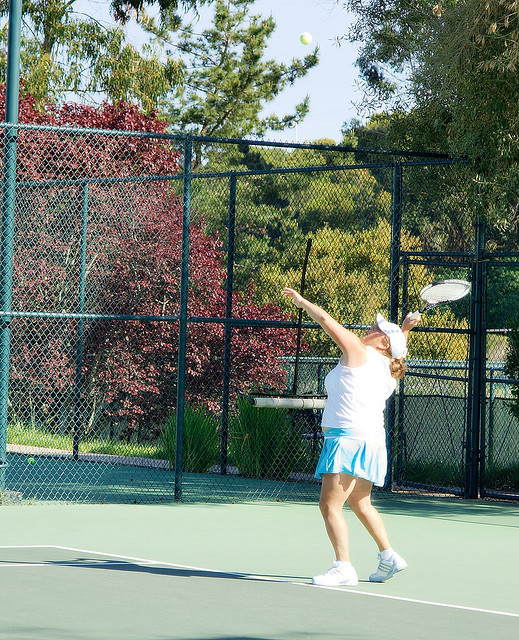

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

    8192/87910968 [..............................] - ETA: 1s

 4202496/87910968 [>.............................] - ETA: 1s

 8396800/87910968 [=>............................] - ETA: 2s

14090240/87910968 [===>..........................] - ETA: 1s

19767296/87910968 [=====>........................] - ETA: 1s

25452544/87910968 [=======>......................] - ETA: 1s

41295872/87910968 [=============>................] - ETA: 0s

50339840/87910968 [================>.............] - ETA: 0s

58728448/87910968 [===================>..........] - ETA: 0s

75571200/87910968 [========================>.....] - ETA: 0s

83894272/87910968 [===========================>..] - ETA: 0s

87916544/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [12]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24009, 24009, 6001, 6001)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0618


Epoch 1 Batch 100 Loss 1.1516


Epoch 1 Batch 200 Loss 0.9201


Epoch 1 Batch 300 Loss 0.8922


Epoch 1 Loss 1.040854
Time taken for 1 epoch 100.07987594604492 sec



Epoch 2 Batch 0 Loss 0.8678


Epoch 2 Batch 100 Loss 0.8257


Epoch 2 Batch 200 Loss 0.8268


Epoch 2 Batch 300 Loss 0.7109


Epoch 2 Loss 0.786627
Time taken for 1 epoch 36.52699089050293 sec



Epoch 3 Batch 0 Loss 0.7747


Epoch 3 Batch 100 Loss 0.7220


Epoch 3 Batch 200 Loss 0.7071


Epoch 3 Batch 300 Loss 0.7065


Epoch 3 Loss 0.708941
Time taken for 1 epoch 36.67209577560425 sec



Epoch 4 Batch 0 Loss 0.7542


Epoch 4 Batch 100 Loss 0.6422


Epoch 4 Batch 200 Loss 0.6024


Epoch 4 Batch 300 Loss 0.7107


Epoch 4 Loss 0.657265
Time taken for 1 epoch 36.70520520210266 sec



Epoch 5 Batch 0 Loss 0.6684


Epoch 5 Batch 100 Loss 0.6549


Epoch 5 Batch 200 Loss 0.6364


Epoch 5 Batch 300 Loss 0.6250


Epoch 5 Loss 0.616459
Time taken for 1 epoch 36.51219129562378 sec



Epoch 6 Batch 0 Loss 0.6531


Epoch 6 Batch 100 Loss 0.5622


Epoch 6 Batch 200 Loss 0.5688


Epoch 6 Batch 300 Loss 0.6302


Epoch 6 Loss 0.581336
Time taken for 1 epoch 37.36966156959534 sec



Epoch 7 Batch 0 Loss 0.5335


Epoch 7 Batch 100 Loss 0.5362


Epoch 7 Batch 200 Loss 0.5960


Epoch 7 Batch 300 Loss 0.5382


Epoch 7 Loss 0.558110
Time taken for 1 epoch 36.8504319190979 sec



Epoch 8 Batch 0 Loss 0.5242


Epoch 8 Batch 100 Loss 0.5142


Epoch 8 Batch 200 Loss 0.5458


Epoch 8 Batch 300 Loss 0.4814


Epoch 8 Loss 0.523847
Time taken for 1 epoch 36.90491819381714 sec



Epoch 9 Batch 0 Loss 0.5318


Epoch 9 Batch 100 Loss 0.4869


Epoch 9 Batch 200 Loss 0.4791


Epoch 9 Batch 300 Loss 0.4719


Epoch 9 Loss 0.496363
Time taken for 1 epoch 36.52782845497131 sec



Epoch 10 Batch 0 Loss 0.4707


Epoch 10 Batch 100 Loss 0.4642


Epoch 10 Batch 200 Loss 0.4685


Epoch 10 Batch 300 Loss 0.4659


Epoch 10 Loss 0.470341
Time taken for 1 epoch 36.24022054672241 sec



Epoch 11 Batch 0 Loss 0.4530


Epoch 11 Batch 100 Loss 0.4947


Epoch 11 Batch 200 Loss 0.4457


Epoch 11 Batch 300 Loss 0.4617


Epoch 11 Loss 0.447154
Time taken for 1 epoch 36.481024980545044 sec



Epoch 12 Batch 0 Loss 0.4359


Epoch 12 Batch 100 Loss 0.4257


Epoch 12 Batch 200 Loss 0.4124


Epoch 12 Batch 300 Loss 0.4302


Epoch 12 Loss 0.424052
Time taken for 1 epoch 37.11701226234436 sec



Epoch 13 Batch 0 Loss 0.4531


Epoch 13 Batch 100 Loss 0.4064


Epoch 13 Batch 200 Loss 0.3677


Epoch 13 Batch 300 Loss 0.3942


Epoch 13 Loss 0.402709
Time taken for 1 epoch 36.868356466293335 sec



Epoch 14 Batch 0 Loss 0.3967


Epoch 14 Batch 100 Loss 0.3455


Epoch 14 Batch 200 Loss 0.3742


Epoch 14 Batch 300 Loss 0.3905


Epoch 14 Loss 0.382572
Time taken for 1 epoch 36.95557117462158 sec



Epoch 15 Batch 0 Loss 0.3754


Epoch 15 Batch 100 Loss 0.3721


Epoch 15 Batch 200 Loss 0.3633


Epoch 15 Batch 300 Loss 0.3830


Epoch 15 Loss 0.364831
Time taken for 1 epoch 36.37884545326233 sec



Epoch 16 Batch 0 Loss 0.3873


Epoch 16 Batch 100 Loss 0.3499


Epoch 16 Batch 200 Loss 0.3437


Epoch 16 Batch 300 Loss 0.3232


Epoch 16 Loss 0.346227
Time taken for 1 epoch 36.44292426109314 sec



Epoch 17 Batch 0 Loss 0.3250


Epoch 17 Batch 100 Loss 0.3218


Epoch 17 Batch 200 Loss 0.3703


Epoch 17 Batch 300 Loss 0.2849


Epoch 17 Loss 0.328413
Time taken for 1 epoch 36.11301136016846 sec



Epoch 18 Batch 0 Loss 0.3032


Epoch 18 Batch 100 Loss 0.3321


Epoch 18 Batch 200 Loss 0.3112


Epoch 18 Batch 300 Loss 0.3129


Epoch 18 Loss 0.315071
Time taken for 1 epoch 36.2520546913147 sec



Epoch 19 Batch 0 Loss 0.3005


Epoch 19 Batch 100 Loss 0.3190


Epoch 19 Batch 200 Loss 0.3243


Epoch 19 Batch 300 Loss 0.2861


Epoch 19 Loss 0.301502
Time taken for 1 epoch 36.188610553741455 sec



Epoch 20 Batch 0 Loss 0.3263


Epoch 20 Batch 100 Loss 0.3182


Epoch 20 Batch 200 Loss 0.2885


Epoch 20 Batch 300 Loss 0.2923


Epoch 20 Loss 0.285932
Time taken for 1 epoch 36.192723989486694 sec



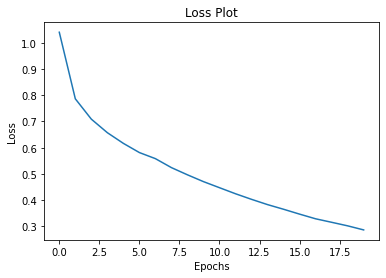

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a <unk> clock is on display on the surface of a building <end>
Prediction Caption: a metal wall with a brick in the middle is <unk> that has some brown wall that looks out the ground <end>


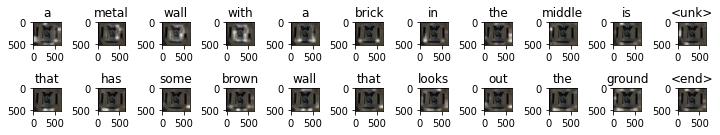

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


 8192/64400 [==>...........................] - ETA: 0s

16384/64400 [======>.......................] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

65536/64400 [==============================] - 0s 2us/step


Prediction Caption: a kid in <unk> their best to fall <end>


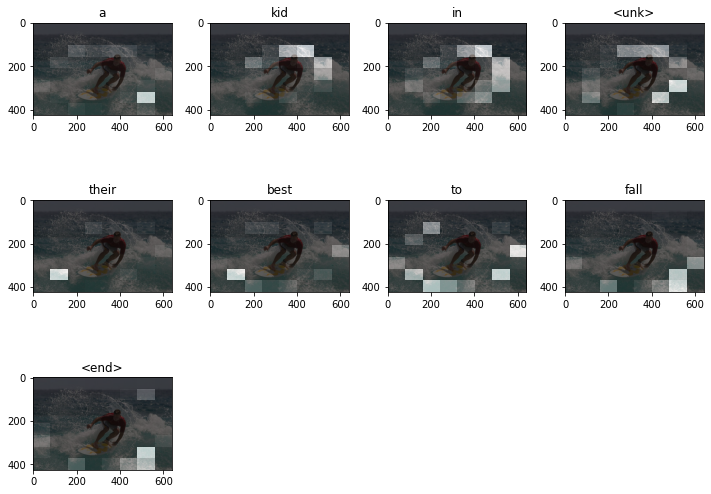

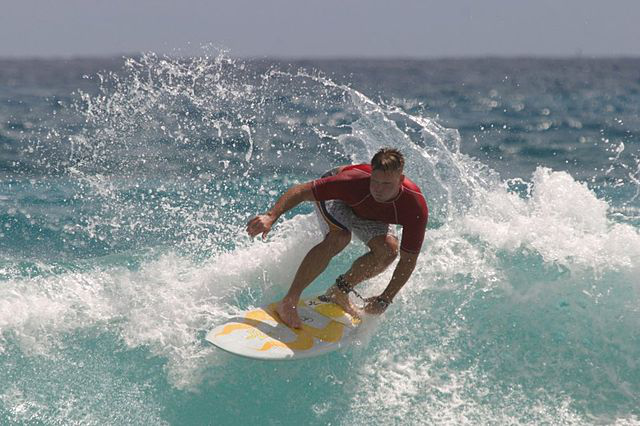

In [37]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.